# Classifying ALE SNPs and Essential Genes with Bitome

## Setup

### Import Required Packages

In [4]:
from pathlib import Path
import sys

from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from xgboost import XGBClassifier

BITOME_KB_PATH = Path('..', 'bitome-kb')
sys.path.append(BITOME_KB_PATH.absolute().as_posix())

from bitome.core import Bitome

### Define Global Variables

In [5]:
DATA_PATH = Path('..', 'data', 'classification')
LOCAL_CACHE_PATH = Path('..', 'local_cache')
FIG_PATH = Path('..', 'figures', 'figure_4')

### Load Pre-Prepared Bitome Knowledgebase

In [6]:
bitome = Bitome.init_from_file(Path(LOCAL_CACHE_PATH, 'bitome.pkl'))

## ALE SNPs

### Prepare Feature Matrix

Prepare versions that include/exclude the sequence features, as well as include ONLY the sequence features

In [7]:
# load the locus tags and SNP labels for training
snp_train_labels = pd.read_csv(Path(DATA_PATH, 'snp_train.csv'), index_col=0, squeeze=True)

snp_y = snp_train_labels.values

# extract the sub-matrix for each locus tag; ensure that they are all in the same "orientation";
# i.e. flip the reverse-strand matrices so that the translation start site is always on the "left"
snp_genes = []
snp_gene_sub_matrices = []
for locus_tag in snp_train_labels.index:
    
    # find the Gene object from the Bitome KB
    for g in bitome.genes:
        if g.locus_tag == locus_tag:
            gene = g
            snp_genes.append(gene)
            break
            
    # pull out the relevant portion of the matrix
    location = gene.location
    gene_range = location.start.position, location.end.position
    sub_matrix = bitome.extract(column_range=gene_range).tocsc()
    
    strand = location.strand
    if strand == -1:
        sub_matrix = sub_matrix[:, ::-1]
    
    snp_gene_sub_matrices.append(sub_matrix)
    
# now we can sum across the positions
X_snp_sum = np.array([np.asarray(sub_mat.sum(axis=1)).flatten() for sub_mat in snp_gene_sub_matrices])
print(f'X_snp shape: {X_snp_sum.shape}')

# also make sure to scale this summed matrix to ensure more equal feature importances
scaler = StandardScaler()
X_snp_sum = scaler.fit_transform(X_snp_sum)

# prepare final X_matrices for each of our desired feature sets
X_to_try = {
    'bitome': X_snp_sum,
    'seq_only': X_snp_sum[:, :8],
    'no_seq': X_snp_sum[:, 8:],
    'shuffled': np.random.permutation(X_snp_sum)
}

X_snp shape: (3349, 1634)


### Define Models to Try

In [5]:
models_to_try = {
    'LR': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        random_state=42
    ),
    'SVM': LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        random_state=42,
        verbose=1
    ),
    'RF': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        verbose=1
    ),
    'NN': MLPClassifier(verbose=1),
    'XGBoost': XGBClassifier(verbose=1)
}

### Model Selection

In [6]:
result_df = pd.DataFrame(
    columns=['model', 'x_matrix', 'train_auc', 'test_auc']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for X_name, X in X_to_try.items():
        print(f'{model_name}: {X_name}')
        
        cv_result = cross_validate(
            model,
            X,
            y=snp_y,
            cv=N_CV,
            scoring='roc_auc',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'x_matrix': [X_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

LR
LR: bitome


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   13.9s finished


LR: seq_only


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


LR: no_seq


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   12.0s finished


LR: shuffled


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.8s finished


SVM
SVM: bitome


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   42.0s finished


SVM: seq_only


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


SVM: no_seq


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   41.0s finished


SVM: shuffled


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   25.3s finished


RF
RF: bitome


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.1s finished


RF: seq_only


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.1s finished


RF: no_seq


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.0s finished


RF: shuffled


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.5s finished


NN
NN: bitome


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   24.9s finished


NN: seq_only


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished


NN: no_seq


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   26.7s finished


NN: shuffled


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   29.4s finished


XGBoost
XGBoost: bitome


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   31.5s finished


XGBoost: seq_only


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.5s finished


XGBoost: no_seq


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   36.7s finished


XGBoost: shuffled


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   34.5s finished


In [8]:
# save the result df so we don't have to run this initial screen again later
result_df.to_csv(Path(DATA_PATH, 'model_selection_snp.csv'))

#### SKIP TO HERE IF RESULT_DF UNCHANGED

In [9]:
result_df = pd.read_csv(Path(DATA_PATH, 'model_selection_snp.csv'))

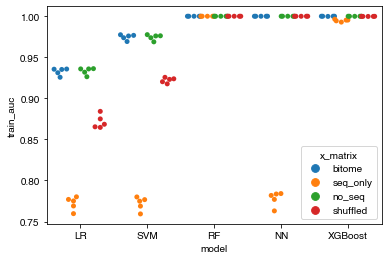

In [10]:
_, ax = plt.subplots()
sns.swarmplot(x='model', y='train_auc', data=result_df, hue='x_matrix', dodge=True, ax=ax)

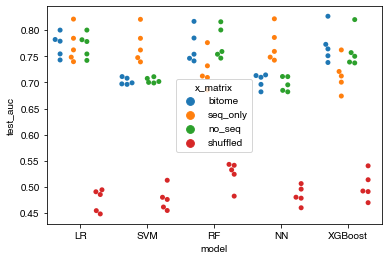

In [11]:
_, ax = plt.subplots()
sns.swarmplot(x='model', y='test_auc', data=result_df, hue='x_matrix', dodge=True, ax=ax)

### Hyperparameter Optimization

We're getting quite nice performance from all of these models; let's optimize all of their hyperparameters and see where we get

NOTE: interestingly, the SVM and NN actually perform better out of the box with just the sequence features

Let's use the full bitome features for these

#### Define Hyperparameter Distributions to Try

In [15]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver='saga',
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'C': np.arange(0.01, 5, 0.05)
        }
    },
    'SVM': {
        'model': LinearSVC(
            class_weight='balanced',
            dual=False,
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'squared_hinge'],
            'C': np.arange(0.01, 5, 0.05)
        }
    },
    'RF': {
        'model': RandomForestClassifier(
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'n_estimators': np.arange(50, 250, 10),
            'max_depth': np.arange(3, 15),
            'min_samples_split': np.arange(0.001, 0.02, 0.001),
            'min_samples_leaf': np.arange(5, 15)
        }
    },
    'XGBoost': {
        'model': XGBClassifier(verbose=1),
        'param_dists': {
            'n_estimators': np.arange(50, 250, 10),
            'max_depth': np.arange(3, 15),
            'learning_rate': np.arange(0.1, 0.9, 0.05)
        }
    }
}

#### Hyperoptimization Round 1

In [16]:
hyperopt_results = {}

for model_name, model_hyperopt_dict in hyperopt_models.items():
    print(model_name)

    random_search_hyperopt = RandomizedSearchCV(
        model_hyperopt_dict['model'],
        model_hyperopt_dict['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X_snp_sum, snp_y)
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_results[model_name] = hyperopt_results_df

LR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 8 seconds


/Users/cam/.virtualenvs/bitome/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished


SVM
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:  9.9min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 13.1min finished


[LibLinear]

/Users/cam/.virtualenvs/bitome/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RF
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   33.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 220 out of 220 | elapsed:    2.2s finished


XGBoost
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 20.6min finished


[11:45:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [27]:
# combine all the hyperopt results into a DF, making sure to add a 'model' column to track which model is which
dfs_with_models = []
for model_name, model_hyperopt_df in hyperopt_results.items():
    model_hyperopt_df['model'] = [model_name] * model_hyperopt_df.shape[0]
    dfs_with_models.append(model_hyperopt_df)
    
hyperopt_result_df = pd.concat(dfs_with_models, axis=0, ignore_index=True)
hyperopt_result_df.to_csv(Path(DATA_PATH, 'hyperopt_snp_1.csv'))

#### SKIP TO HERE IF ALREADY RAN FIRST ROUND OF HYPEROPT

In [8]:
hyperopt_result_df = pd.read_csv(Path(DATA_PATH, 'hyperopt_snp_1.csv'), index_col=0)

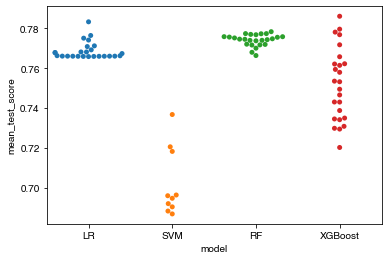

In [9]:
sns.swarmplot(x='model', y='mean_test_score', data=hyperopt_result_df)

SO LR and the Random Forest are turned in well, and XGBoost has some potential; let's continue with those; which parameters were best?

In [36]:
hyperopt_result_df[
    hyperopt_result_df['model'] == 'LR'
].sort_values(by='mean_test_score', ascending=False)[['params', 'mean_test_score', 'mean_train_score']].head()

,params,mean_test_score,mean_train_score
0,"{'penalty': 'l1', 'C': 0.21000000000000002}",0.783283,0.921459
1,"{'penalty': 'l1', 'C': 0.41000000000000003}",0.776423,0.928586
2,"{'penalty': 'l1', 'C': 0.51}",0.775071,0.929970
3,"{'penalty': 'l1', 'C': 0.6100000000000001}",0.774129,0.930897
4,"{'penalty': 'l1', 'C': 1.11}",0.771215,0.932906


For LR, it seems clear that strong L1 regularization helps the model; there's a little bit of overfitting but it's not too too bad. 

What about the RF?

In [43]:
hyperopt_result_df[
    hyperopt_result_df['model'] == 'RF'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
    'param_min_samples_leaf'
]].head()

,mean_test_score,mean_train_score,param_n_estimators,param_max_depth,param_learning_rate
50,0.778335,0.877746,220.0,10.0,NaN
51,0.777368,0.887718,100.0,13.0,NaN
52,0.777358,0.842895,190.0,9.0,NaN
53,0.777280,0.858451,180.0,13.0,NaN
54,0.776975,0.839256,80.0,9.0,NaN
55,0.776802,0.879036,130.0,13.0,NaN
56,0.775828,0.843714,140.0,8.0,NaN
57,0.775810,0.831703,90.0,7.0,NaN
58,0.775620,0.854091,50.0,13.0,NaN
59,0.775521,0.832391,120.0,8.0,NaN


A little harder to just eyeball, but we're seeing pretty similar performance overall; however, less overfitting with the lower max depth values; min_samples_ don't seem to matter much

And XGBoost?

In [44]:
hyperopt_result_df[
    hyperopt_result_df['model'] == 'XGBoost'
].sort_values(by='mean_test_score', ascending=False)[[
    'mean_test_score', 'mean_train_score', 'param_n_estimators', 'param_max_depth', 'param_learning_rate'
]]

,mean_test_score,mean_train_score,param_n_estimators,param_max_depth,param_learning_rate
75,0.786085,0.995607,90.0,8.0,0.10
76,0.779597,0.999955,210.0,7.0,0.10
77,0.778118,0.999126,200.0,5.0,0.15
78,0.776815,0.975430,120.0,3.0,0.30
79,0.771745,0.999698,80.0,6.0,0.30
80,0.765746,0.999648,130.0,5.0,0.25
81,0.762215,1.000000,150.0,9.0,0.20
82,0.762092,0.997953,60.0,5.0,0.45
83,0.761421,1.000000,160.0,9.0,0.20
84,0.759373,1.000000,140.0,9.0,0.25


All of these models appear significantly overfit; let's drop XGBoost and continue with LR and RF

#### Hyperoptimization Round 2

In [45]:
hyperopt_models_2 = {
    'LR': {
        'model': LogisticRegression(
            penalty='l1',
            solver='saga',
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'C': np.arange(0.0001, 0.05, 0.001)
        }
    },
    'RF': {
        'model': RandomForestClassifier(
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'n_estimators': np.arange(50, 500, 10),
            'max_depth': np.arange(2, 8)
        }
    }
}

In [46]:
hyperopt_results_2 = {}

for model_name, model_hyperopt_dict in hyperopt_models_2.items():
    print(model_name)

    random_search_hyperopt = RandomizedSearchCV(
        model_hyperopt_dict['model'],
        model_hyperopt_dict['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X_snp_sum, snp_y)
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_results_2[model_name] = hyperopt_results_df

LR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 6 seconds


/Users/cam/.virtualenvs/bitome/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s finished


RF
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    2.3s finished


In [47]:
# combine all the hyperopt results into a DF, making sure to add a 'model' column to track which model is which
dfs_with_models_2 = []
for model_name, model_hyperopt_df in hyperopt_results_2.items():
    model_hyperopt_df['model'] = [model_name] * model_hyperopt_df.shape[0]
    dfs_with_models_2.append(model_hyperopt_df)
    
hyperopt_result_df_2 = pd.concat(dfs_with_models_2, axis=0, ignore_index=True)
hyperopt_result_df_2.to_csv(Path(DATA_PATH, 'hyperopt_snp_2.csv'))

In [51]:
hyperopt_result_df_2 = pd.read_csv(Path(DATA_PATH, 'hyperopt_snp_2.csv'), index_col=0)

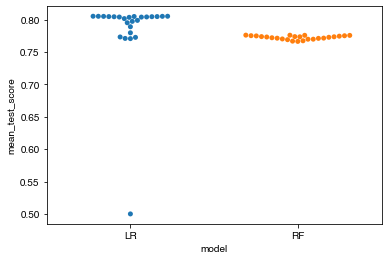

In [52]:
sns.swarmplot(x='model', y='mean_test_score', data=hyperopt_result_df_2)

So it seems we're not eking much more performance out of these models; let's check on the best parameters to see if there's at least any trend

In [55]:
hyperopt_result_df_2[
    hyperopt_result_df_2['model'] == 'LR'
].sort_values(by='mean_test_score', ascending=False)[['params', 'mean_test_score', 'mean_train_score']].head()

,params,mean_test_score,mean_train_score
0,{'C': 0.03610000000000001},0.805211,0.852865
1,{'C': 0.035100000000000006},0.805207,0.851011
2,{'C': 0.0311},0.805135,0.843289
3,{'C': 0.0291},0.805070,0.839284
4,{'C': 0.0281},0.805017,0.837229


That's actually a pretty nice model; AUC of 0.805, not particularly overfit; looks like C=0.03-0.04 is a good range

### TF/Keras Neural Net Sandbox

Initial bias setting from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [12]:
val_cutoff = int(X_snp_sum.shape[0]*0.8)

X = tf.convert_to_tensor(X_snp_sum[:val_cutoff, :])
y = tf.convert_to_tensor(snp_y[:val_cutoff].reshape((-1, 1)))
X_val = tf.convert_to_tensor(X_snp_sum[val_cutoff:, :])
y_val = tf.convert_to_tensor(snp_y[val_cutoff:].reshape((-1, 1)))

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=[0, 1],
    y=snp_y[:val_cutoff]
)
class_weight_dict = {k: v for k, v in zip([0, 1], class_weights)}

neg, pos = np.bincount(snp_y[:val_cutoff])
initial_bias = np.log([pos/neg])

In [13]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers_big', 2, 4)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 100, 500, 10), activation='relu'))
    model.add(layers.Dropout(hp.Float('rate', 0, 1)))
    model.add(layers.Dense(units=hp.Int('units_small', 25, 200, 5), activation='relu'))
    model.add(layers.Dense(
        1,
        activation='sigmoid',
        bias_initializer=tf.keras.initializers.Constant(initial_bias)
    ))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-2),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=3,
    directory=LOCAL_CACHE_PATH,
    project_name='ale_snp_scaled'
)

In [15]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

tuner.search(
    X, y,
    epochs=50,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.3793 - accuracy: 0.65 - ETA: 0s - loss: 3.4797 - accuracy: 0.57 - ETA: 0s - loss: 2.8339 - accuracy: 0.56 - ETA: 0s - loss: 2.2800 - accuracy: 0.57 - ETA: 0s - loss: 1.8788 - accuracy: 0.59 - ETA: 0s - loss: 1.6971 - accuracy: 0.61 - 1s 6ms/step - loss: 1.6015 - accuracy: 0.6163 - val_loss: 0.6017 - val_accuracy: 0.7239
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.59 - ETA: 0s - loss: 0.7116

84/84 [==============================] - ETA: 0s - loss: 0.8994 - accuracy: 0.71 - ETA: 0s - loss: 4.5373 - accuracy: 0.65 - ETA: 0s - loss: 3.7598 - accuracy: 0.59 - ETA: 0s - loss: 2.9279 - accuracy: 0.60 - ETA: 0s - loss: 2.3559 - accuracy: 0.62 - ETA: 0s - loss: 2.0176 - accuracy: 0.63 - 0s 5ms/step - loss: 1.9488 - accuracy: 0.6331 - val_loss: 0.6092 - val_accuracy: 0.7164
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.0809 - accuracy: 0.53 - ETA: 0s - loss: 0.8302 - accuracy: 0.65 - ETA: 0s - loss: 0.7697 - accuracy: 0.69 - ETA: 0s - loss: 0.7585 - accuracy: 0.67 - ETA: 0s - loss: 0.7401 - accuracy: 0.67 - 0s 4ms/step - loss: 0.7255 - accuracy: 0.6909 - val_loss: 0.6018 - val_accuracy: 0.7299
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.8491 - accuracy: 0.59 - ETA: 0s - loss: 0.6602 - accuracy: 0.70 - ETA: 0s - loss: 0.6300 - accuracy: 0.70 - ETA: 0s - loss: 0.6503 - accuracy: 0.72 - ETA: 0s - loss: 0.6846 - accuracy: 0.72 - 0s 4ms/

84/84 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.68 - ETA: 0s - loss: 4.6793 - accuracy: 0.59 - ETA: 0s - loss: 3.1831 - accuracy: 0.61 - ETA: 0s - loss: 2.5087 - accuracy: 0.60 - ETA: 0s - loss: 2.1551 - accuracy: 0.60 - ETA: 0s - loss: 1.9043 - accuracy: 0.61 - 0s 5ms/step - loss: 1.8138 - accuracy: 0.6211 - val_loss: 0.5938 - val_accuracy: 0.7179
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6223 - accuracy: 0.71 - ETA: 0s - loss: 0.7182 - accuracy: 0.68 - ETA: 0s - loss: 0.7167 - accuracy: 0.66 - ETA: 0s - loss: 0.7086 - accuracy: 0.66 - ETA: 0s - loss: 0.7145 - accuracy: 0.68 - ETA: 0s - loss: 0.7127 - accuracy: 0.69 - 0s 4ms/step - loss: 0.7156 - accuracy: 0.6902 - val_loss: 0.6477 - val_accuracy: 0.7119
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.71 - ETA: 0s - loss: 0.8106 - accuracy: 0.64 - ETA: 0s - loss: 0.7258 - accuracy: 0.66 - ETA: 0s - loss: 0.7099 - accuracy: 0.68 - ETA: 0s

Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.5496 - accuracy: 0.81 - ETA: 0s - loss: 0.5882 - accuracy: 0.78 - ETA: 0s - loss: 0.5881 - accuracy: 0.80 - ETA: 0s - loss: 0.5859 - accuracy: 0.79 - ETA: 0s - loss: 0.7815 - accuracy: 0.79 - ETA: 0s - loss: 0.8443 - accuracy: 0.78 - ETA: 0s - loss: 0.9132 - accuracy: 0.78 - 0s 4ms/step - loss: 0.8980 - accuracy: 0.7884 - val_loss: 0.6507 - val_accuracy: 0.7254
Epoch 22/50
84/84 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.78 - ETA: 0s - loss: 1.1748 - accuracy: 0.76 - ETA: 0s - loss: 1.0615 - accuracy: 0.76 - ETA: 0s - loss: 0.9238 - accuracy: 0.77 - ETA: 0s - loss: 0.8823 - accuracy: 0.76 - ETA: 0s - loss: 0.8178 - accuracy: 0.77 - 0s 4ms/step - loss: 0.8003 - accuracy: 0.7783 - val_loss: 0.7433 - val_accuracy: 0.7328
Epoch 23/50
84/84 [==============================] - ETA: 0s - loss: 0.5679 - accuracy: 0.81 - ETA: 0s - loss: 0.6190 - accuracy: 0.79 - ETA: 0s - loss: 0.6090 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8052 - accuracy: 0.62 - ETA: 0s - loss: 1.0010 - accuracy: 0.65 - ETA: 0s - loss: 0.7836 - accuracy: 0.69 - ETA: 0s - loss: 0.7114 - accuracy: 0.70 - 0s 4ms/step - loss: 0.7033 - accuracy: 0.7118 - val_loss: 0.5521 - val_accuracy: 0.7015
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.90 - ETA: 0s - loss: 0.5323 - accuracy: 0.78 - ETA: 0s - loss: 0.5250 - accuracy: 0.76 - 0s 2ms/step - loss: 0.

Epoch 28/50
84/84 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.96 - ETA: 0s - loss: 0.1900 - accuracy: 0.95 - ETA: 0s - loss: 0.2006 - accuracy: 0.95 - 0s 2ms/step - loss: 0.2157 - accuracy: 0.9496 - val_loss: 1.3915 - val_accuracy: 0.7149
Epoch 29/50
84/84 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.96 - ETA: 0s - loss: 0.2031 - accuracy: 0.95 - ETA: 0s - loss: 0.2088 - accuracy: 0.95 - 0s 2ms/step - loss: 0.2013 - accuracy: 0.9586 - val_loss: 2.1340 - val_accuracy: 0.7164
Epoch 30/50
84/84 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 1.00 - ETA: 0s - loss: 0.1817 - accuracy: 0.96 - ETA: 0s - loss: 0.1877 - accuracy: 0.96 - ETA: 0s - loss: 0.1969 - accuracy: 0.95 - 0s 2ms/step - loss: 0.2081 - accuracy: 0.9548 - val_loss: 1.4745 - val_accuracy: 0.7194
Epoch 31/50
84/84 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.96 - ETA: 0s - loss: 0.2079 - accuracy: 0.95 - ETA: 0s - loss: 0.20

Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.3408 - accuracy: 0.90 - ETA: 0s - loss: 0.3408 - accuracy: 0.87 - ETA: 0s - loss: 0.3292 - accuracy: 0.88 - 0s 2ms/step - loss: 0.3145 - accuracy: 0.8891 - val_loss: 1.9700 - val_accuracy: 0.7343
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 1.00 - ETA: 0s - loss: 0.3545 - accuracy: 0.90 - ETA: 0s - loss: 0.3587 - accuracy: 0.88 - 0s 2ms/step - loss: 0.3505 - accuracy: 0.8888 - val_loss: 0.7425 - val_accuracy: 0.7119
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.93 - ETA: 0s - loss: 0.2688 - accuracy: 0.92 - ETA: 0s - loss: 0.4935 - accuracy: 0.90 - 0s 2ms/step - loss: 0.4538 - accuracy: 0.8985 - val_loss: 0.6874 - val_accuracy: 0.7104
Epoch 22/50
84/84 [==============================] - ETA: 0s - loss: 0.2795 - accuracy: 0.90 - ETA: 0s - loss: 0.2875 - accuracy: 0.89 - ETA: 0s - loss: 0.2939 - accuracy: 0.89 - ETA: 0s - loss: 0.28

Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.2906 - accuracy: 0.90 - ETA: 0s - loss: 0.2222 - accuracy: 0.91 - ETA: 0s - loss: 0.2186 - accuracy: 0.91 - 0s 2ms/step - loss: 0.2243 - accuracy: 0.9078 - val_loss: 1.2652 - val_accuracy: 0.7075
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.1206 - accuracy: 0.93 - ETA: 0s - loss: 0.1800 - accuracy: 0.93 - ETA: 0s - loss: 0.2269 - accuracy: 0.92 - 0s 2ms/step - loss: 0.2463 - accuracy: 0.9171 - val_loss: 1.5018 - val_accuracy: 0.6866
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.90 - ETA: 0s - loss: 0.3308 - accuracy: 0.89 - ETA: 0s - loss: 0.3265 - accuracy: 0.90 - 0s 2ms/step - loss: 0.3017 - accuracy: 0.8992 - val_loss: 1.4288 - val_accuracy: 0.6866
Epoch 19/50
84/84 [==============================] - 0s 2ms/step - loss: 0.2285 - accuracy: 0.9197 - val_loss: 1.7224 - val_accuracy: 0.7149
Epoch 00019: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9710 - accuracy: 0.56 - ETA: 0s - loss: 1.5108 - accuracy: 0.62 - ETA: 0s - loss: 1.0276 - accuracy: 0.68 - ETA: 0s - loss: 0.8696 - accuracy: 0.69 - ETA: 0s - loss: 0.8037 - accuracy: 0.71 - ETA: 0s - loss: 0.7766 - accuracy: 0.71 - 1s 6ms/step - loss: 0.7605 - accuracy: 0.7126 - val_loss: 0.6248 - val_accuracy: 0.7179
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.68 - ETA: 0s - loss: 0.5833

Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.2479 - accuracy: 0.90 - ETA: 0s - loss: 0.3388 - accuracy: 0.85 - ETA: 0s - loss: 0.4183 - accuracy: 0.84 - ETA: 0s - loss: 0.4460 - accuracy: 0.84 - ETA: 0s - loss: 0.4490 - accuracy: 0.82 - ETA: 0s - loss: 0.4529 - accuracy: 0.82 - 0s 4ms/step - loss: 0.4519 - accuracy: 0.8253 - val_loss: 0.8996 - val_accuracy: 0.7179
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.7293 - accuracy: 0.78 - ETA: 0s - loss: 0.4957 - accuracy: 0.82 - ETA: 0s - loss: 0.4544 - accuracy: 0.83 - ETA: 0s - loss: 0.4521 - accuracy: 0.82 - ETA: 0s - loss: 0.4534 - accuracy: 0.83 - ETA: 0s - loss: 0.4570 - accuracy: 0.83 - 0s 4ms/step - loss: 0.4632 - accuracy: 0.8302 - val_loss: 0.5602 - val_accuracy: 0.7343
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.93 - ETA: 0s - loss: 0.4777 - accuracy: 0.83 - ETA: 0s - loss: 0.4621 - accuracy: 0.84 - ETA: 0s - loss: 0.4645 - accuracy: 0.8

Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.87 - ETA: 0s - loss: 0.3132 - accuracy: 0.87 - ETA: 0s - loss: 0.3098 - accuracy: 0.87 - ETA: 0s - loss: 0.3200 - accuracy: 0.87 - ETA: 0s - loss: 0.3246 - accuracy: 0.87 - ETA: 0s - loss: 0.3194 - accuracy: 0.87 - 0s 4ms/step - loss: 0.3228 - accuracy: 0.8712 - val_loss: 1.3287 - val_accuracy: 0.6418
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.3446 - accuracy: 0.78 - ETA: 0s - loss: 0.3127 - accuracy: 0.87 - ETA: 0s - loss: 0.3137 - accuracy: 0.86 - ETA: 0s - loss: 0.3069 - accuracy: 0.86 - ETA: 0s - loss: 0.3223 - accuracy: 0.87 - ETA: 0s - loss: 0.3122 - accuracy: 0.87 - 0s 4ms/step - loss: 0.3117 - accuracy: 0.8720 - val_loss: 2.5382 - val_accuracy: 0.6896
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.93 - ETA: 0s - loss: 0.3262 - accuracy: 0.90 - ETA: 0s - loss: 0.3438 - accuracy: 0.88 - ETA: 0s - loss: 0.3400 - accuracy: 0.

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.81 - ETA: 0s - loss: 1.4811 - accuracy: 0.65 - ETA: 0s - loss: 1.1526 - accuracy: 0.67 - ETA: 0s - loss: 0.9774 - accuracy: 0.68 - ETA: 0s - loss: 0.8775 - accuracy: 0.68 - ETA: 0s - loss: 0.8321 - accuracy: 0.69 - 0s 6ms/step - loss: 0.7996 - accuracy: 0.6984 - val_loss: 0.5771 - val_accuracy: 0.7149
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.84 - ETA: 0s - loss: 0.5064

84/84 [==============================] - ETA: 0s - loss: 0.4563 - accuracy: 0.78 - ETA: 0s - loss: 0.5015 - accuracy: 0.80 - ETA: 0s - loss: 0.4819 - accuracy: 0.81 - ETA: 0s - loss: 0.4962 - accuracy: 0.82 - ETA: 0s - loss: 0.4929 - accuracy: 0.82 - ETA: 0s - loss: 0.4752 - accuracy: 0.83 - 0s 4ms/step - loss: 0.4789 - accuracy: 0.8320 - val_loss: 0.7385 - val_accuracy: 0.7313
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.84 - ETA: 0s - loss: 0.4718 - accuracy: 0.84 - ETA: 0s - loss: 0.4482 - accuracy: 0.86 - ETA: 0s - loss: 0.4561 - accuracy: 0.85 - ETA: 0s - loss: 0.4638 - accuracy: 0.85 - ETA: 0s - loss: 0.4603 - accuracy: 0.85 - 0s 4ms/step - loss: 0.4539 - accuracy: 0.8518 - val_loss: 0.7054 - val_accuracy: 0.7209
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.87 - ETA: 0s - loss: 0.4347 - accuracy: 0.86 - ETA: 0s - loss: 0.4491 - accuracy: 0.85 - ETA: 0s - loss: 0.4559 - accuracy: 0.84 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.71 - ETA: 0s - loss: 1.7669 - accuracy: 0.62 - ETA: 0s - loss: 1.4108 - accuracy: 0.63 - ETA: 0s - loss: 1.2060 - accuracy: 0.64 - ETA: 0s - loss: 1.0614 - accuracy: 0.66 - ETA: 0s - loss: 0.9911 - accuracy: 0.67 - ETA: 0s - loss: 0.9237 - accuracy: 0.69 - 1s 6ms/step - loss: 0.8976 - accuracy: 0.7036 - val_loss: 0.5871 - val_accuracy: 0.7448
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6403

84/84 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.84 - ETA: 0s - loss: 0.4401 - accuracy: 0.86 - ETA: 0s - loss: 0.4621 - accuracy: 0.85 - ETA: 0s - loss: 0.4755 - accuracy: 0.84 - ETA: 0s - loss: 0.4762 - accuracy: 0.84 - ETA: 0s - loss: 0.4788 - accuracy: 0.84 - 0s 4ms/step - loss: 0.4783 - accuracy: 0.8421 - val_loss: 0.5838 - val_accuracy: 0.7328
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.4577 - accuracy: 0.87 - ETA: 0s - loss: 0.4346 - accuracy: 0.86 - ETA: 0s - loss: 0.4614 - accuracy: 0.86 - ETA: 0s - loss: 0.4542 - accuracy: 0.86 - ETA: 0s - loss: 0.4697 - accuracy: 0.85 - ETA: 0s - loss: 0.4772 - accuracy: 0.84 - 0s 4ms/step - loss: 0.4752 - accuracy: 0.8488 - val_loss: 0.5724 - val_accuracy: 0.7403
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.87 - ETA: 0s - loss: 0.4537 - accuracy: 0.85 - ETA: 0s - loss: 0.4261 - accuracy: 0.87 - ETA: 0s - loss: 0.4347 - accuracy: 0.86 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9803 - accuracy: 0.40 - ETA: 0s - loss: 3.6613 - accuracy: 0.61 - ETA: 0s - loss: 2.6786 - accuracy: 0.60 - ETA: 0s - loss: 2.0353 - accuracy: 0.62 - ETA: 0s - loss: 1.7431 - accuracy: 0.61 - ETA: 0s - loss: 1.5268 - accuracy: 0.62 - 0s 6ms/step - loss: 1.4056 - accuracy: 0.6282 - val_loss: 0.5790 - val_accuracy: 0.7134
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.71 - ETA: 0s - loss: 0.6615

Epoch 20/50
84/84 [==============================] - 0s 4ms/step - loss: 0.2563 - accuracy: 0.9097 - val_loss: 1.8530 - val_accuracy: 0.7239
Epoch 00020: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8763 - accuracy: 0.65 - ETA: 0s - loss: 2.5329 - accuracy: 0.60 - ETA: 0s - loss: 1.7664 - accuracy: 0.60 - ETA: 0s - loss: 1.4627 - accuracy: 0.60 - ETA: 0s - loss: 1.2833 - accuracy: 0.62 - ETA: 0s - loss: 1.1927 - accuracy: 0.63 - 0s 5ms/step - loss: 1.0998 - accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.0390 - accuracy: 0.53 - ETA: 0s - loss: 1.7545 - accuracy: 0.56 - ETA: 0s - loss: 1.2406 - accuracy: 0.61 - ETA: 0s - loss: 1.0289 - accuracy: 0.64 - ETA: 0s - loss: 0.9542 - accuracy: 0.65 - ETA: 0s - loss: 0.9029 - accuracy: 0.61 - 0s 5ms/step - loss: 0.8922 - accuracy: 0.6114 - val_loss: 0.6833 - val_accuracy: 0.7075
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.40 - ETA: 0s - loss: 0.6805

84/84 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.84 - ETA: 0s - loss: 0.4730 - accuracy: 0.84 - ETA: 0s - loss: 0.5242 - accuracy: 0.81 - ETA: 0s - loss: 0.5277 - accuracy: 0.81 - ETA: 0s - loss: 0.5289 - accuracy: 0.82 - 0s 3ms/step - loss: 0.5292 - accuracy: 0.8219 - val_loss: 0.5626 - val_accuracy: 0.7418
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.68 - ETA: 0s - loss: 0.5494 - accuracy: 0.82 - ETA: 0s - loss: 0.5669 - accuracy: 0.81 - ETA: 0s - loss: 0.5654 - accuracy: 0.81 - ETA: 0s - loss: 0.5557 - accuracy: 0.81 - ETA: 0s - loss: 0.5781 - accuracy: 0.80 - 0s 4ms/step - loss: 0.5801 - accuracy: 0.8040 - val_loss: 0.5993 - val_accuracy: 0.7373
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.75 - ETA: 0s - loss: 0.6813 - accuracy: 0.73 - ETA: 0s - loss: 0.6782 - accuracy: 0.75 - ETA: 0s - loss: 0.6774 - accuracy: 0.74 - ETA: 0s - loss: 0.6708 - accuracy: 0.75 - 0s 3m

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.3350 - accuracy: 0.53 - ETA: 0s - loss: 10.5418 - accuracy: 0.620 - ETA: 0s - loss: 7.3637 - accuracy: 0.621 - ETA: 0s - loss: 5.4367 - accuracy: 0.64 - ETA: 0s - loss: 4.3187 - accuracy: 0.65 - ETA: 0s - loss: 3.5917 - accuracy: 0.64 - ETA: 0s - loss: 3.0902 - accuracy: 0.62 - 1s 6ms/step - loss: 3.0902 - accuracy: 0.6278 - val_loss: 0.6719 - val_accuracy: 0.6970
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7

84/84 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.15 - ETA: 0s - loss: 0.6959 - accuracy: 0.32 - ETA: 0s - loss: 0.7015 - accuracy: 0.44 - ETA: 0s - loss: 0.7001 - accuracy: 0.41 - ETA: 0s - loss: 0.7021 - accuracy: 0.39 - ETA: 0s - loss: 0.6991 - accuracy: 0.38 - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4125 - val_loss: 0.6681 - val_accuracy: 0.6955
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.71 - ETA: 0s - loss: 0.6928 - accuracy: 0.68 - ETA: 0s - loss: 0.7042 - accuracy: 0.66 - ETA: 0s - loss: 0.7002 - accuracy: 0.57 - ETA: 0s - loss: 0.6904 - accuracy: 0.53 - ETA: 0s - loss: 0.6944 - accuracy: 0.56 - ETA: 0s - loss: 0.6951 - accuracy: 0.52 - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5259 - val_loss: 0.6986 - val_accuracy: 0.3045
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.6288 - accuracy: 0.18 - ETA: 0s - loss: 0.7001 - accuracy: 0.35 - ETA: 0s - loss: 0.6999 - accuracy: 0.51 - ETA: 0

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.81 - ETA: 0s - loss: 1.5693 - accuracy: 0.58 - ETA: 0s - loss: 1.1489 - accuracy: 0.62 - ETA: 0s - loss: 0.9660 - accuracy: 0.66 - ETA: 0s - loss: 0.8785 - accuracy: 0.69 - ETA: 0s - loss: 0.8429 - accuracy: 0.69 - 0s 6ms/step - loss: 0.8045 - accuracy: 0.7029 - val_loss: 0.6079 - val_accuracy: 0.7149
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5837 - accuracy: 0.68 - ETA: 0s - loss: 0.5931

Epoch 00019: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8421 - accuracy: 0.62 - ETA: 0s - loss: 1.6041 - accuracy: 0.64 - ETA: 0s - loss: 1.1052 - accuracy: 0.65 - ETA: 0s - loss: 0.9391 - accuracy: 0.69 - ETA: 0s - loss: 0.8529 - accuracy: 0.70 - ETA: 0s - loss: 0.8077 - accuracy: 0.71 - 0s 5ms/step - loss: 0.7902 - accuracy: 0.7126 - val_loss: 0.5993 - val_accuracy: 0.7254
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0

Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.75 - ETA: 0s - loss: 0.4417 - accuracy: 0.85 - ETA: 0s - loss: 0.4398 - accuracy: 0.84 - ETA: 0s - loss: 0.4583 - accuracy: 0.82 - ETA: 0s - loss: 0.4690 - accuracy: 0.81 - ETA: 0s - loss: 0.4806 - accuracy: 0.80 - 0s 4ms/step - loss: 0.4890 - accuracy: 0.8059 - val_loss: 0.8421 - val_accuracy: 0.6627
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.93 - ETA: 0s - loss: 0.4496 - accuracy: 0.83 - ETA: 0s - loss: 0.4665 - accuracy: 0.82 - ETA: 0s - loss: 0.5272 - accuracy: 0.82 - ETA: 0s - loss: 0.5326 - accuracy: 0.80 - ETA: 0s - loss: 0.5789 - accuracy: 0.80 - 0s 4ms/step - loss: 0.5669 - accuracy: 0.8070 - val_loss: 0.8793 - val_accuracy: 0.6910
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.4454 - accuracy: 0.78 - ETA: 0s - loss: 0.6619 - accuracy: 0.80 - ETA: 0s - loss: 0.5771 - accuracy: 0.79 - ETA: 0s - loss: 0.5490 - accuracy: 0.7

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9168 - accuracy: 0.50 - ETA: 0s - loss: 1.6177 - accuracy: 0.66 - ETA: 0s - loss: 1.1305 - accuracy: 0.65 - ETA: 0s - loss: 0.9650 - accuracy: 0.66 - ETA: 0s - loss: 0.8584 - accuracy: 0.69 - ETA: 0s - loss: 0.8161 - accuracy: 0.70 - 0s 5ms/step - loss: 0.8093 - accuracy: 0.7018 - val_loss: 0.5865 - val_accuracy: 0.7104
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5463 - accuracy: 0.81 - ETA: 0s - loss: 0.5885

84/84 [==============================] - ETA: 0s - loss: 0.8749 - accuracy: 0.59 - ETA: 0s - loss: 2.1894 - accuracy: 0.59 - ETA: 0s - loss: 1.5961 - accuracy: 0.63 - ETA: 0s - loss: 1.2850 - accuracy: 0.66 - ETA: 0s - loss: 1.1261 - accuracy: 0.67 - ETA: 0s - loss: 1.0195 - accuracy: 0.68 - 0s 5ms/step - loss: 0.9782 - accuracy: 0.6928 - val_loss: 0.5882 - val_accuracy: 0.7090
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.71 - ETA: 0s - loss: 0.5741 - accuracy: 0.69 - ETA: 0s - loss: 0.5937 - accuracy: 0.71 - ETA: 0s - loss: 0.5770 - accuracy: 0.73 - ETA: 0s - loss: 0.5684 - accuracy: 0.73 - ETA: 0s - loss: 0.5681 - accuracy: 0.74 - 0s 4ms/step - loss: 0.5664 - accuracy: 0.7492 - val_loss: 0.5930 - val_accuracy: 0.7239
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.4911 - accuracy: 0.78 - ETA: 0s - loss: 0.5103 - accuracy: 0.79 - ETA: 0s - loss: 0.4931 - accuracy: 0.80 - ETA: 0s - loss: 0.5162 - accuracy: 0.78 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.0221 - accuracy: 0.56 - ETA: 0s - loss: 0.8483 - accuracy: 0.66 - ETA: 0s - loss: 0.7096 - accuracy: 0.70 - 0s 4ms/step - loss: 0.6846 - accuracy: 0.7059 - val_loss: 0.5842 - val_accuracy: 0.7045
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5202 - accuracy: 0.87 - ETA: 0s - loss: 0.5300 - accuracy: 0.78 - ETA: 0s - loss: 0.5311 - accuracy: 0.77 - 0s 2ms/step - loss: 0.5404 - accuracy: 0.7745 - val_loss: 0.5562

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9153 - accuracy: 0.62 - ETA: 0s - loss: 1.7709 - accuracy: 0.59 - ETA: 0s - loss: 1.2217 - accuracy: 0.65 - ETA: 0s - loss: 1.0317 - accuracy: 0.66 - ETA: 0s - loss: 0.9458 - accuracy: 0.68 - ETA: 0s - loss: 0.8769 - accuracy: 0.69 - ETA: 0s - loss: 0.8243 - accuracy: 0.70 - 1s 7ms/step - loss: 0.8010 - accuracy: 0.7006 - val_loss: 0.5751 - val_accuracy: 0.7388
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6017

84/84 [==============================] - ETA: 0s - loss: 0.2967 - accuracy: 0.93 - ETA: 0s - loss: 0.3880 - accuracy: 0.86 - ETA: 0s - loss: 0.4116 - accuracy: 0.86 - ETA: 0s - loss: 0.4222 - accuracy: 0.86 - ETA: 0s - loss: 0.4325 - accuracy: 0.86 - ETA: 0s - loss: 0.4434 - accuracy: 0.85 - ETA: 0s - loss: 0.4408 - accuracy: 0.85 - 0s 5ms/step - loss: 0.4315 - accuracy: 0.8608 - val_loss: 0.9783 - val_accuracy: 0.7119
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.75 - ETA: 0s - loss: 0.4043 - accuracy: 0.87 - ETA: 0s - loss: 0.3856 - accuracy: 0.87 - ETA: 0s - loss: 0.4063 - accuracy: 0.87 - ETA: 0s - loss: 0.4076 - accuracy: 0.86 - ETA: 0s - loss: 0.4213 - accuracy: 0.86 - ETA: 0s - loss: 0.4232 - accuracy: 0.86 - 0s 5ms/step - loss: 0.4264 - accuracy: 0.8626 - val_loss: 0.6122 - val_accuracy: 0.7418
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.81 - ETA: 0s - loss: 0.4335 - accuracy: 0.86 - ETA: 0

84/84 [==============================] - 0s 5ms/step - loss: 0.4140 - accuracy: 0.8824 - val_loss: 1.4883 - val_accuracy: 0.7522
Epoch 00022: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.75 - ETA: 0s - loss: 2.3244 - accuracy: 0.67 - ETA: 0s - loss: 1.4195 - accuracy: 0.70 - ETA: 0s - loss: 1.1417 - accuracy: 0.72 - ETA: 0s - loss: 1.0053 - accuracy: 0.72 - ETA: 0s - loss: 0.9123 - accuracy: 0.72 - 1s 6ms/step - loss: 0.8777 - accuracy: 0.7268 - val_loss: 0.6099 - val_accuracy: 0.7075
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5561 - accuracy: 0.78 - ETA: 0s - loss: 0.5612

84/84 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.75 - ETA: 0s - loss: 0.4379 - accuracy: 0.85 - ETA: 0s - loss: 0.4289 - accuracy: 0.86 - ETA: 0s - loss: 0.4331 - accuracy: 0.85 - ETA: 0s - loss: 0.4298 - accuracy: 0.86 - ETA: 0s - loss: 0.4321 - accuracy: 0.86 - 0s 4ms/step - loss: 0.4332 - accuracy: 0.8619 - val_loss: 0.6872 - val_accuracy: 0.7582
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.81 - ETA: 0s - loss: 0.4266 - accuracy: 0.86 - ETA: 0s - loss: 0.4252 - accuracy: 0.87 - ETA: 0s - loss: 0.4518 - accuracy: 0.86 - ETA: 0s - loss: 0.4465 - accuracy: 0.86 - 0s 3ms/step - loss: 0.4459 - accuracy: 0.8675 - val_loss: 0.7543 - val_accuracy: 0.7358
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 1.00 - ETA: 0s - loss: 0.3918 - accuracy: 0.88 - ETA: 0s - loss: 0.3939 - accuracy: 0.88 - ETA: 0s - loss: 0.3946 - accuracy: 0.88 - ETA: 0s - loss: 0.4360 - accuracy: 0.87 - ETA: 

Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.90 - ETA: 0s - loss: 0.3832 - accuracy: 0.89 - ETA: 0s - loss: 0.4171 - accuracy: 0.87 - ETA: 0s - loss: 0.4045 - accuracy: 0.87 - ETA: 0s - loss: 0.4050 - accuracy: 0.87 - ETA: 0s - loss: 0.4086 - accuracy: 0.86 - 0s 4ms/step - loss: 0.4097 - accuracy: 0.8652 - val_loss: 0.6153 - val_accuracy: 0.7343
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.4982 - accuracy: 0.87 - ETA: 0s - loss: 0.3415 - accuracy: 0.88 - ETA: 0s - loss: 0.3678 - accuracy: 0.88 - ETA: 0s - loss: 0.3767 - accuracy: 0.87 - ETA: 0s - loss: 0.3855 - accuracy: 0.87 - ETA: 0s - loss: 0.3919 - accuracy: 0.87 - 0s 4ms/step - loss: 0.3918 - accuracy: 0.8757 - val_loss: 0.7465 - val_accuracy: 0.7119
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.93 - ETA: 0s - loss: 0.4117 - accuracy: 0.89 - ETA: 0s - loss: 0.3978 - accuracy: 0.88 - ETA: 0s - loss: 0.4179 - accuracy: 0

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.5463 - accuracy: 0.75 - ETA: 0s - loss: 1.7737 - accuracy: 0.62 - ETA: 0s - loss: 1.3521 - accuracy: 0.63 - ETA: 0s - loss: 1.1800 - accuracy: 0.64 - ETA: 0s - loss: 1.0408 - accuracy: 0.66 - ETA: 0s - loss: 0.9706 - accuracy: 0.66 - 0s 6ms/step - loss: 0.9324 - accuracy: 0.6760 - val_loss: 0.5703 - val_accuracy: 0.7060
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7356 - accuracy: 0.71 - ETA: 0s - loss: 0.6542

84/84 [==============================] - ETA: 0s - loss: 0.9128 - accuracy: 0.50 - ETA: 0s - loss: 1.9322 - accuracy: 0.58 - ETA: 0s - loss: 1.3540 - accuracy: 0.61 - ETA: 0s - loss: 1.1815 - accuracy: 0.62 - ETA: 0s - loss: 1.0511 - accuracy: 0.63 - ETA: 0s - loss: 0.9618 - accuracy: 0.65 - ETA: 0s - loss: 0.8940 - accuracy: 0.66 - 0s 6ms/step - loss: 0.8855 - accuracy: 0.6708 - val_loss: 0.5853 - val_accuracy: 0.7343
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.90 - ETA: 0s - loss: 0.5228 - accuracy: 0.80 - ETA: 0s - loss: 0.5327 - accuracy: 0.78 - ETA: 0s - loss: 0.5304 - accuracy: 0.78 - ETA: 0s - loss: 0.5456 - accuracy: 0.77 - ETA: 0s - loss: 0.5420 - accuracy: 0.77 - 0s 4ms/step - loss: 0.5455 - accuracy: 0.7757 - val_loss: 0.5826 - val_accuracy: 0.6970
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.6086 - accuracy: 0.75 - ETA: 0s - loss: 0.4377 - accuracy: 0.82 - ETA: 0s - loss: 0.4446 - accuracy: 0.80 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8466 - accuracy: 0.46 - ETA: 0s - loss: 1.5604 - accuracy: 0.64 - ETA: 0s - loss: 1.1189 - accuracy: 0.68 - ETA: 0s - loss: 0.9755 - accuracy: 0.69 - ETA: 0s - loss: 0.8782 - accuracy: 0.71 - ETA: 0s - loss: 0.8305 - accuracy: 0.71 - ETA: 0s - loss: 0.7931 - accuracy: 0.71 - 1s 6ms/step - loss: 0.7845 - accuracy: 0.7148 - val_loss: 0.5965 - val_accuracy: 0.7179
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5752

Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5392 - accuracy: 0.78 - ETA: 0s - loss: 0.6073 - accuracy: 0.74 - ETA: 0s - loss: 0.6000 - accuracy: 0.74 - ETA: 0s - loss: 0.5905 - accuracy: 0.74 - ETA: 0s - loss: 0.5866 - accuracy: 0.74 - ETA: 0s - loss: 0.5758 - accuracy: 0.75 - ETA: 0s - loss: 0.5780 - accuracy: 0.75 - 0s 4ms/step - loss: 0.5799 - accuracy: 0.7525 - val_loss: 0.5631 - val_accuracy: 0.7522
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.81 - ETA: 0s - loss: 0.5042 - accuracy: 0.83 - ETA: 0s - loss: 0.5584 - accuracy: 0.79 - ETA: 0s - loss: 0.5550 - accuracy: 0.78 - ETA: 0s - loss: 0.5681 - accuracy: 0.78 - ETA: 0s - loss: 0.5779 - accuracy: 0.77 - ETA: 0s - loss: 0.5680 - accuracy: 0.78 - 0s 4ms/step - loss: 0.5688 - accuracy: 0.7839 - val_loss: 0.6244 - val_accuracy: 0.7343
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.5609 - accuracy: 0.78 - ETA: 0s - loss: 0.4944 - accuracy: 0.8

Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.4008 - accuracy: 0.87 - ETA: 0s - loss: 0.6253 - accuracy: 0.79 - ETA: 0s - loss: 0.5942 - accuracy: 0.79 - ETA: 0s - loss: 0.5641 - accuracy: 0.79 - ETA: 0s - loss: 0.5582 - accuracy: 0.80 - ETA: 0s - loss: 0.5542 - accuracy: 0.80 - 0s 4ms/step - loss: 0.5546 - accuracy: 0.8040 - val_loss: 0.7067 - val_accuracy: 0.7299
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.4922 - accuracy: 0.84 - ETA: 0s - loss: 0.5464 - accuracy: 0.78 - ETA: 0s - loss: 0.5359 - accuracy: 0.79 - ETA: 0s - loss: 0.5096 - accuracy: 0.81 - ETA: 0s - loss: 0.5330 - accuracy: 0.81 - ETA: 0s - loss: 0.5287 - accuracy: 0.81 - 0s 4ms/step - loss: 0.5224 - accuracy: 0.8201 - val_loss: 0.6568 - val_accuracy: 0.7284
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.4255 - accuracy: 0.87 - ETA: 0s - loss: 0.4758 - accuracy: 0.84 - ETA: 0s - loss: 0.5014 - accuracy: 0.83 - ETA: 0s - loss: 0.4957 - accuracy: 0.

Epoch 28/50
84/84 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.81 - ETA: 0s - loss: 0.4365 - accuracy: 0.85 - ETA: 0s - loss: 0.4638 - accuracy: 0.85 - ETA: 0s - loss: 0.4521 - accuracy: 0.86 - ETA: 0s - loss: 0.4380 - accuracy: 0.86 - ETA: 0s - loss: 0.4390 - accuracy: 0.86 - 0s 4ms/step - loss: 0.4367 - accuracy: 0.8686 - val_loss: 0.8985 - val_accuracy: 0.7388
Epoch 29/50
84/84 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.87 - ETA: 0s - loss: 0.4551 - accuracy: 0.86 - ETA: 0s - loss: 0.4673 - accuracy: 0.86 - ETA: 0s - loss: 0.4621 - accuracy: 0.86 - ETA: 0s - loss: 0.4701 - accuracy: 0.86 - ETA: 0s - loss: 0.4671 - accuracy: 0.86 - ETA: 0s - loss: 0.4707 - accuracy: 0.85 - 0s 4ms/step - loss: 0.4707 - accuracy: 0.8589 - val_loss: 2.8971 - val_accuracy: 0.7522
Epoch 30/50
84/84 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.90 - ETA: 0s - loss: 0.4938 - accuracy: 0.84 - ETA: 0s - loss: 0.5062 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8642 - accuracy: 0.50 - ETA: 0s - loss: 2.6477 - accuracy: 0.60 - ETA: 0s - loss: 1.7783 - accuracy: 0.60 - ETA: 0s - loss: 1.3910 - accuracy: 0.63 - ETA: 0s - loss: 1.2294 - accuracy: 0.65 - 0s 5ms/step - loss: 1.1629 - accuracy: 0.6596 - val_loss: 0.5837 - val_accuracy: 0.7313
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.75 - ETA: 0s - loss: 0.5721 - accuracy: 0.76 - ETA: 0s - loss: 0.5924

Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.71 - ETA: 0s - loss: 0.6217 - accuracy: 0.73 - ETA: 0s - loss: 0.6109 - accuracy: 0.75 - ETA: 0s - loss: 0.6086 - accuracy: 0.74 - ETA: 0s - loss: 0.6098 - accuracy: 0.74 - 0s 3ms/step - loss: 0.6091 - accuracy: 0.7477 - val_loss: 0.5837 - val_accuracy: 0.7403
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.5392 - accuracy: 0.81 - ETA: 0s - loss: 0.5351 - accuracy: 0.78 - ETA: 0s - loss: 0.5349 - accuracy: 0.78 - ETA: 0s - loss: 0.5280 - accuracy: 0.79 - ETA: 0s - loss: 0.5321 - accuracy: 0.79 - 0s 3ms/step - loss: 0.5340 - accuracy: 0.7906 - val_loss: 0.5881 - val_accuracy: 0.7090
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.81 - ETA: 0s - loss: 0.5615 - accuracy: 0.80 - ETA: 0s - loss: 0.5601 - accuracy: 0.80 - ETA: 0s - loss: 0.5670 - accuracy: 0.79 - 0s 3ms/step - loss: 0.5639 - accuracy: 0.7999 - val_loss: 0.5556 - val_accuracy:

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9603 - accuracy: 0.43 - ETA: 0s - loss: 3.4438 - accuracy: 0.62 - ETA: 0s - loss: 2.2658 - accuracy: 0.62 - ETA: 0s - loss: 1.7205 - accuracy: 0.65 - ETA: 0s - loss: 1.4707 - accuracy: 0.65 - ETA: 0s - loss: 1.3114 - accuracy: 0.65 - 0s 6ms/step - loss: 1.2203 - accuracy: 0.6603 - val_loss: 0.6045 - val_accuracy: 0.6955
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.71 - ETA: 0s - loss: 0.6592

Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.6014 - accuracy: 0.78 - ETA: 0s - loss: 0.8934 - accuracy: 0.74 - ETA: 0s - loss: 0.8423 - accuracy: 0.74 - ETA: 0s - loss: 0.9033 - accuracy: 0.73 - ETA: 0s - loss: 0.8789 - accuracy: 0.72 - ETA: 0s - loss: 0.8690 - accuracy: 0.72 - 0s 4ms/step - loss: 0.8554 - accuracy: 0.7197 - val_loss: 0.6618 - val_accuracy: 0.7060
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.78 - ETA: 0s - loss: 0.6552 - accuracy: 0.73 - ETA: 0s - loss: 0.6659 - accuracy: 0.71 - ETA: 0s - loss: 0.6698 - accuracy: 0.70 - ETA: 0s - loss: 0.6643 - accuracy: 0.70 - ETA: 0s - loss: 0.6646 - accuracy: 0.70 - 0s 4ms/step - loss: 0.6657 - accuracy: 0.7040 - val_loss: 0.7133 - val_accuracy: 0.7090
Epoch 22/50
84/84 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.75 - ETA: 0s - loss: 0.6803 - accuracy: 0.69 - ETA: 0s - loss: 0.6756 - accuracy: 0.69 - ETA: 0s - loss: 0.6705 - accuracy: 

84/84 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.75 - ETA: 0s - loss: 0.5025 - accuracy: 0.82 - ETA: 0s - loss: 0.5072 - accuracy: 0.81 - ETA: 0s - loss: 0.4994 - accuracy: 0.82 - ETA: 0s - loss: 0.4935 - accuracy: 0.82 - ETA: 0s - loss: 0.5106 - accuracy: 0.82 - ETA: 0s - loss: 0.5140 - accuracy: 0.82 - 0s 4ms/step - loss: 0.5172 - accuracy: 0.8205 - val_loss: 0.5942 - val_accuracy: 0.7119
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.78 - ETA: 0s - loss: 0.5506 - accuracy: 0.80 - ETA: 0s - loss: 0.5074 - accuracy: 0.82 - ETA: 0s - loss: 0.5133 - accuracy: 0.82 - ETA: 0s - loss: 0.5000 - accuracy: 0.82 - ETA: 0s - loss: 0.5005 - accuracy: 0.82 - 0s 4ms/step - loss: 0.4977 - accuracy: 0.8268 - val_loss: 0.5954 - val_accuracy: 0.7328
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.2868 - accuracy: 0.87 - ETA: 0s - loss: 0.4347 - accuracy: 0.86 - ETA: 0s - loss: 0.4712 - accuracy: 0.84 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.75 - ETA: 0s - loss: 4.6359 - accuracy: 0.57 - ETA: 0s - loss: 2.9695 - accuracy: 0.61 - ETA: 0s - loss: 2.2001 - accuracy: 0.63 - ETA: 0s - loss: 1.8750 - accuracy: 0.62 - ETA: 0s - loss: 1.6694 - accuracy: 0.61 - ETA: 0s - loss: 1.4955 - accuracy: 0.63 - ETA: 0s - loss: 1.3731 - accuracy: 0.64 - 1s 7ms/step - loss: 1.3679 - accuracy: 0.6443 - val_loss: 0.6193 - val_accuracy: 0.6940
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.5331 - accuracy: 0.84 - ETA: 0s - loss: 0.6747 - accuracy: 0.73 - ETA: 0s - loss: 0.6875 - accuracy: 0.72 - ETA: 0s - loss: 0.6606 - accuracy: 0.74 - ETA: 0s - loss: 0.6592 - accuracy: 0.74 - ETA: 0s - loss: 0.6478 - accuracy: 0.74 - ETA: 0s - loss: 0.6384 - accuracy: 0.75 - 0s 5ms/step - loss: 0.6950 - accuracy: 0.7577 - val_loss: 0.6089 - val_accuracy: 0.7373
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.5583 - accuracy: 0.84 - ETA: 0s - loss: 0.5973 - accuracy: 0.81 - ETA: 0s - loss: 0.6652 - accuracy: 0.76 - ETA: 0s - loss: 0.6990 - accuracy: 0.75 - ETA: 0s - loss: 0.6810 - accuracy: 0.72 - ETA: 0s - loss: 0.6747 - accuracy: 0.71 - ETA: 0s - loss: 0.6767 - accuracy: 0.71 - ETA: 0s - loss: 0.6786 - accuracy: 0.71 - 0s 5ms/step - loss: 0.6834 - accuracy: 0.7137 - val_loss: 0.6370 - val_accuracy: 0.7164
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.7334 - accuracy: 0.59 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8424 - accuracy: 0.59 - ETA: 0s - loss: 2.8207 - accuracy: 0.59 - ETA: 0s - loss: 2.0856 - accuracy: 0.62 - ETA: 0s - loss: 1.5763 - accuracy: 0.65 - ETA: 0s - loss: 1.3186 - accuracy: 0.66 - ETA: 0s - loss: 1.1687 - accuracy: 0.68 - 0s 6ms/step - loss: 1.0817 - accuracy: 0.6857 - val_loss: 0.6098 - val_accuracy: 0.7104
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.75 - ETA: 0s - loss: 0.5801

Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.81 - ETA: 0s - loss: 0.5665 - accuracy: 0.79 - ETA: 0s - loss: 0.5651 - accuracy: 0.79 - ETA: 0s - loss: 0.5816 - accuracy: 0.79 - ETA: 0s - loss: 0.5932 - accuracy: 0.78 - ETA: 0s - loss: 0.6035 - accuracy: 0.77 - 0s 4ms/step - loss: 0.6048 - accuracy: 0.7786 - val_loss: 0.5977 - val_accuracy: 0.7299
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.5629 - accuracy: 0.81 - ETA: 0s - loss: 0.5764 - accuracy: 0.77 - ETA: 0s - loss: 0.5744 - accuracy: 0.78 - ETA: 0s - loss: 0.6095 - accuracy: 0.78 - ETA: 0s - loss: 0.6097 - accuracy: 0.77 - ETA: 0s - loss: 0.6119 - accuracy: 0.76 - 0s 4ms/step - loss: 0.6106 - accuracy: 0.7716 - val_loss: 0.5868 - val_accuracy: 0.7388
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.75 - ETA: 0s - loss: 0.5940 - accuracy: 0.76 - ETA: 0s - loss: 0.5860 - accuracy: 0.77 - ETA: 0s - loss: 0.5902 - accuracy: 0.7

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.0655 - accuracy: 0.37 - ETA: 0s - loss: 2.8287 - accuracy: 0.53 - ETA: 0s - loss: 1.7568 - accuracy: 0.61 - ETA: 0s - loss: 1.5050 - accuracy: 0.64 - ETA: 0s - loss: 1.3042 - accuracy: 0.66 - ETA: 0s - loss: 1.1655 - accuracy: 0.68 - ETA: 0s - loss: 1.0700 - accuracy: 0.69 - ETA: 0s - loss: 1.0261 - accuracy: 0.70 - 1s 7ms/step - loss: 0.9862 - accuracy: 0.7018 - val_loss: 0.6047 - val_accuracy: 0.7090
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.4718 - accuracy: 0.84 - ETA: 0s - loss: 0.4153 - accuracy: 0.87 - ETA: 0s - loss: 0.3960 - accuracy: 0.88 - ETA: 0s - loss: 0.3902 - accuracy: 0.89 - ETA: 0s - loss: 0.3812 - accuracy: 0.89 - ETA: 0s - loss: 0.3889 - accuracy: 0.89 - ETA: 0s - loss: 0.3785 - accuracy: 0.89 - ETA: 0s - loss: 0.3866 - accuracy: 0.89 - ETA: 0s - loss: 0.3905 - accuracy: 0.88 - 0s 6ms/step - loss: 0.3904 - accuracy: 0.8873 - val_loss: 1.0668 - val_accuracy: 0.7284
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.87 - ETA: 0s - loss: 0.3751 - accuracy: 0.90 - ETA: 0s - loss: 0.3807 - accuracy: 0.89 - ETA: 0s - loss: 0.4058 - accuracy: 0.88 - ETA: 0s - loss: 0.4226 - accuracy: 0.87 - ETA: 0s - loss: 0.4118 - accuracy: 0.88 - ETA: 0s - loss: 0.4382 - accuracy: 0.88 - ETA: 0s - loss: 0.4386 - accuracy: 0.88 - ETA: 0s - loss: 0.4303 - accuracy: 0.88 - 1s 6ms/step - loss: 0.4272 - accuracy: 0.8828 - val_loss: 1.00

84/84 [==============================] - ETA: 0s - loss: 0.6328 - accuracy: 0.78 - ETA: 0s - loss: 0.7263 - accuracy: 0.66 - ETA: 0s - loss: 0.7009 - accuracy: 0.69 - ETA: 0s - loss: 0.7011 - accuracy: 0.71 - ETA: 0s - loss: 0.6941 - accuracy: 0.71 - ETA: 0s - loss: 0.6967 - accuracy: 0.71 - ETA: 0s - loss: 0.7029 - accuracy: 0.70 - ETA: 0s - loss: 0.7018 - accuracy: 0.68 - 0s 5ms/step - loss: 0.7015 - accuracy: 0.6495 - val_loss: 0.6973 - val_accuracy: 0.3045
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.28 - ETA: 0s - loss: 0.6924 - accuracy: 0.29 - ETA: 0s - loss: 0.6885 - accuracy: 0.29 - ETA: 0s - loss: 0.6919 - accuracy: 0.29 - ETA: 0s - loss: 0.6941 - accuracy: 0.30 - ETA: 0s - loss: 0.6937 - accuracy: 0.30 - ETA: 0s - loss: 0.6945 - accuracy: 0.30 - ETA: 0s - loss: 0.6911 - accuracy: 0.29 - 0s 5ms/step - loss: 0.6925 - accuracy: 0.3191 - val_loss: 0.6916 - val_accuracy: 0.6955
Epoch 20/50
84/84 [==============================] - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9209 - accuracy: 0.50 - ETA: 0s - loss: 1.7359 - accuracy: 0.64 - ETA: 0s - loss: 1.2610 - accuracy: 0.63 - ETA: 0s - loss: 1.0510 - accuracy: 0.65 - ETA: 0s - loss: 0.9413 - accuracy: 0.66 - 0s 5ms/step - loss: 0.9125 - accuracy: 0.6708 - val_loss: 0.5832 - val_accuracy: 0.7313
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.68 - ETA: 0s - loss: 0.5744 - accuracy: 0.73 - ETA: 0s - loss: 0.5638

Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.93 - ETA: 0s - loss: 0.2356 - accuracy: 0.90 - ETA: 0s - loss: 0.2411 - accuracy: 0.90 - ETA: 0s - loss: 0.2566 - accuracy: 0.89 - ETA: 0s - loss: 0.2954 - accuracy: 0.88 - 0s 3ms/step - loss: 0.2954 - accuracy: 0.8820 - val_loss: 0.7587 - val_accuracy: 0.7134
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.90 - ETA: 0s - loss: 0.2909 - accuracy: 0.89 - ETA: 0s - loss: 0.3236 - accuracy: 0.87 - ETA: 0s - loss: 0.3254 - accuracy: 0.87 - ETA: 0s - loss: 0.3281 - accuracy: 0.87 - 0s 3ms/step - loss: 0.3258 - accuracy: 0.8694 - val_loss: 0.9873 - val_accuracy: 0.7045
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.81 - ETA: 0s - loss: 0.2390 - accuracy: 0.91 - ETA: 0s - loss: 0.2597 - accuracy: 0.90 - ETA: 0s - loss: 0.2731 - accuracy: 0.90 - ETA: 0s - loss: 0.2621 - accuracy: 0.90 - 0s 3ms/step - loss: 0.2597 - accura

84/84 [==============================] - ETA: 0s - loss: 0.5456 - accuracy: 0.78 - ETA: 0s - loss: 1.3276 - accuracy: 0.60 - ETA: 0s - loss: 1.2142 - accuracy: 0.60 - ETA: 0s - loss: 1.0615 - accuracy: 0.62 - ETA: 0s - loss: 0.9393 - accuracy: 0.64 - 0s 4ms/step - loss: 0.8900 - accuracy: 0.6596 - val_loss: 0.5877 - val_accuracy: 0.6955
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.71 - ETA: 0s - loss: 0.5819 - accuracy: 0.69 - ETA: 0s - loss: 0.5555 - accuracy: 0.72 - ETA: 0s - loss: 0.5516 - accuracy: 0.72 - 0s 3ms/step - loss: 0.5413 - accuracy: 0.7309 - val_loss: 0.5738 - val_accuracy: 0.6881
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.81 - ETA: 0s - loss: 0.4702 - accuracy: 0.78 - ETA: 0s - loss: 0.4800 - accuracy: 0.78 - ETA: 0s - loss: 0.4939 - accuracy: 0.77 - ETA: 0s - loss: 0.4935 - accuracy: 0.77 - 0s 3ms/step - loss: 0.4935 - accuracy: 0.7760 - val_loss: 0.5997 - val_accuracy: 0.6955
Epo

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.1686 - accuracy: 0.46 - ETA: 0s - loss: 0.9264 - accuracy: 0.64 - ETA: 0s - loss: 0.7851 - accuracy: 0.68 - ETA: 0s - loss: 0.7326 - accuracy: 0.68 - 0s 4ms/step - loss: 0.7230 - accuracy: 0.6909 - val_loss: 0.6003 - val_accuracy: 0.7015
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.68 - ETA: 0s - loss: 0.5896 - accuracy: 0.75 - ETA: 0s - loss: 0.5810 - accuracy: 0.75 - ETA: 0s - loss: 0.5862

Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.2814 - accuracy: 0.96 - ETA: 0s - loss: 0.3506 - accuracy: 0.89 - ETA: 0s - loss: 0.3312 - accuracy: 0.90 - 0s 2ms/step - loss: 0.3335 - accuracy: 0.8977 - val_loss: 0.7612 - val_accuracy: 0.7194
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.87 - ETA: 0s - loss: 0.2737 - accuracy: 0.91 - ETA: 0s - loss: 0.3054 - accuracy: 0.90 - 0s 2ms/step - loss: 0.3251 - accuracy: 0.9018 - val_loss: 0.7980 - val_accuracy: 0.7239
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.87 - ETA: 0s - loss: 0.3157 - accuracy: 0.90 - ETA: 0s - loss: 0.3078 - accuracy: 0.91 - 0s 2ms/step - loss: 0.3175 - accuracy: 0.9059 - val_loss: 0.8111 - val_accuracy: 0.7104
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.84 - ETA: 0s - loss: 0.2701 - accuracy: 0.91 - ETA: 0s - loss: 0.2786 - accuracy: 0.90 - 0s 2ms/step - loss: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9011 - accuracy: 0.40 - ETA: 0s - loss: 2.1272 - accuracy: 0.60 - ETA: 0s - loss: 1.4027 - accuracy: 0.63 - ETA: 0s - loss: 1.1161 - accuracy: 0.66 - 0s 4ms/step - loss: 1.0463 - accuracy: 0.6689 - val_loss: 0.5605 - val_accuracy: 0.7522
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8482 - accuracy: 0.62 - ETA: 0s - loss: 0.6463 - accuracy: 0.74 - ETA: 0s - loss: 0.6206 - accuracy: 0.75 - ETA: 0s - loss: 0.6144

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.78 - ETA: 0s - loss: 1.9922 - accuracy: 0.62 - ETA: 0s - loss: 1.4846 - accuracy: 0.61 - 0s 4ms/step - loss: 1.2196 - accuracy: 0.6346 - val_loss: 0.5831 - val_accuracy: 0.7000
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.71 - ETA: 0s - loss: 0.6217 - accuracy: 0.71 - ETA: 0s - loss: 0.6172 - accuracy: 0.72 - 0s 2ms/step - loss: 0.6232 - accuracy: 0.7264 - val_loss: 0.5773

Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.93 - ETA: 0s - loss: 0.4336 - accuracy: 0.86 - ETA: 0s - loss: 0.4594 - accuracy: 0.84 - 0s 2ms/step - loss: 0.4546 - accuracy: 0.8447 - val_loss: 0.6194 - val_accuracy: 0.7104
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.84 - ETA: 0s - loss: 0.4396 - accuracy: 0.84 - ETA: 0s - loss: 0.4542 - accuracy: 0.85 - 0s 2ms/step - loss: 0.4525 - accuracy: 0.8537 - val_loss: 0.6117 - val_accuracy: 0.7119
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.6050 - accuracy: 0.75 - ETA: 0s - loss: 0.4287 - accuracy: 0.85 - ETA: 0s - loss: 0.4243 - accuracy: 0.85 - 0s 2ms/step - loss: 0.4373 - accuracy: 0.8522 - val_loss: 0.5765 - val_accuracy: 0.7269
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.87 - ETA: 0s - loss: 0.4051 - accuracy: 0.86 - ETA: 0s - loss: 0.4863 - accuracy: 0.86 - 0s 2ms/step - loss: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.75 - ETA: 0s - loss: 1.0285 - accuracy: 0.66 - ETA: 0s - loss: 0.8597 - accuracy: 0.66 - 0s 4ms/step - loss: 0.7779 - accuracy: 0.6760 - val_loss: 0.5427 - val_accuracy: 0.7403
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.84 - ETA: 0s - loss: 0.5444 - accuracy: 0.77 - ETA: 0s - loss: 0.5484 - accuracy: 0.74 - 0s 2ms/step - loss: 0.5548 - accuracy: 0.7439 - val_loss: 0.5673

Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.2665 - accuracy: 0.96 - ETA: 0s - loss: 0.3514 - accuracy: 0.89 - ETA: 0s - loss: 0.3564 - accuracy: 0.89 - 0s 2ms/step - loss: 0.3750 - accuracy: 0.8820 - val_loss: 0.8444 - val_accuracy: 0.7075
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.75 - ETA: 0s - loss: 0.3655 - accuracy: 0.87 - ETA: 0s - loss: 0.3695 - accuracy: 0.88 - 0s 2ms/step - loss: 0.4028 - accuracy: 0.8854 - val_loss: 0.9887 - val_accuracy: 0.7179
Epoch 15/50
84/84 [==============================] - 0s 2ms/step - loss: 0.3866 - accuracy: 0.8847 - val_loss: 0.8668 - val_accuracy: 0.7194
Epoch 00015: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('flo

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8117 - accuracy: 0.62 - ETA: 0s - loss: 4.2591 - accuracy: 0.62 - ETA: 0s - loss: 2.9433 - accuracy: 0.62 - ETA: 0s - loss: 2.3752 - accuracy: 0.62 - ETA: 0s - loss: 1.9514 - accuracy: 0.63 - ETA: 0s - loss: 1.7109 - accuracy: 0.66 - ETA: 0s - loss: 1.5488 - accuracy: 0.66 - 1s 6ms/step - loss: 1.5096 - accuracy: 0.6614 - val_loss: 0.5657 - val_accuracy: 0.7179
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5814

84/84 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.87 - ETA: 0s - loss: 0.4327 - accuracy: 0.83 - ETA: 0s - loss: 0.4077 - accuracy: 0.84 - ETA: 0s - loss: 0.4118 - accuracy: 0.84 - ETA: 0s - loss: 0.4077 - accuracy: 0.84 - ETA: 0s - loss: 0.4063 - accuracy: 0.84 - 0s 4ms/step - loss: 0.4041 - accuracy: 0.8473 - val_loss: 0.6633 - val_accuracy: 0.7254
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.90 - ETA: 0s - loss: 0.3340 - accuracy: 0.87 - ETA: 0s - loss: 0.3418 - accuracy: 0.86 - ETA: 0s - loss: 0.3405 - accuracy: 0.87 - ETA: 0s - loss: 0.3530 - accuracy: 0.86 - ETA: 0s - loss: 0.3864 - accuracy: 0.85 - ETA: 0s - loss: 0.3921 - accuracy: 0.84 - 0s 4ms/step - loss: 0.3955 - accuracy: 0.8425 - val_loss: 0.7196 - val_accuracy: 0.7075
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.78 - ETA: 0s - loss: 0.3702 - accuracy: 0.84 - ETA: 0s - loss: 0.3628 - accuracy: 0.85 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8767 - accuracy: 0.65 - ETA: 0s - loss: 1.6752 - accuracy: 0.59 - ETA: 0s - loss: 1.1610 - accuracy: 0.62 - ETA: 0s - loss: 0.9650 - accuracy: 0.65 - ETA: 0s - loss: 0.8703 - accuracy: 0.67 - ETA: 0s - loss: 0.8070 - accuracy: 0.68 - ETA: 0s - loss: 0.7756 - accuracy: 0.68 - 1s 6ms/step - loss: 0.7607 - accuracy: 0.6887 - val_loss: 0.6230 - val_accuracy: 0.7269
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8458

84/84 [==============================] - ETA: 0s - loss: 0.3502 - accuracy: 0.84 - ETA: 0s - loss: 0.3427 - accuracy: 0.90 - ETA: 0s - loss: 0.3622 - accuracy: 0.89 - ETA: 0s - loss: 0.3955 - accuracy: 0.87 - ETA: 0s - loss: 0.3998 - accuracy: 0.87 - ETA: 0s - loss: 0.3892 - accuracy: 0.88 - ETA: 0s - loss: 0.3975 - accuracy: 0.87 - ETA: 0s - loss: 0.3831 - accuracy: 0.88 - 0s 6ms/step - loss: 0.3828 - accuracy: 0.8832 - val_loss: 0.9885 - val_accuracy: 0.7194
Epoch 24/50
84/84 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.96 - ETA: 0s - loss: 0.3437 - accuracy: 0.90 - ETA: 0s - loss: 0.3498 - accuracy: 0.89 - ETA: 0s - loss: 0.3474 - accuracy: 0.89 - ETA: 0s - loss: 0.4110 - accuracy: 0.89 - ETA: 0s - loss: 0.4082 - accuracy: 0.89 - ETA: 0s - loss: 0.8210 - accuracy: 0.89 - 0s 4ms/step - loss: 0.8132 - accuracy: 0.8914 - val_loss: 0.7404 - val_accuracy: 0.6955
Epoch 25/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.8328 -

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8194 - accuracy: 0.62 - ETA: 0s - loss: 4.8499 - accuracy: 0.63 - ETA: 0s - loss: 2.7498 - accuracy: 0.66 - ETA: 0s - loss: 2.0373 - accuracy: 0.68 - ETA: 0s - loss: 1.6778 - accuracy: 0.69 - ETA: 0s - loss: 1.4859 - accuracy: 0.70 - ETA: 0s - loss: 1.3373 - accuracy: 0.70 - ETA: 0s - loss: 1.2289 - accuracy: 0.70 - 1s 7ms/step - loss: 1.1678 - accuracy: 0.7036 - val_loss: 0.6017 - val_accuracy: 0.7209
Epoch 2/50
84/84 [==============

Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.81 - ETA: 0s - loss: 0.6205 - accuracy: 0.79 - ETA: 0s - loss: 0.5844 - accuracy: 0.76 - ETA: 0s - loss: 0.5726 - accuracy: 0.77 - ETA: 0s - loss: 0.5570 - accuracy: 0.77 - ETA: 0s - loss: 0.5546 - accuracy: 0.78 - ETA: 0s - loss: 0.5595 - accuracy: 0.78 - 0s 5ms/step - loss: 0.5586 - accuracy: 0.7824 - val_loss: 0.6719 - val_accuracy: 0.6388
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.84 - ETA: 0s - loss: 0.4671 - accuracy: 0.80 - ETA: 0s - loss: 0.4755 - accuracy: 0.82 - ETA: 0s - loss: 0.4794 - accuracy: 0.82 - ETA: 0s - loss: 0.4839 - accuracy: 0.81 - ETA: 0s - loss: 0.4969 - accuracy: 0.80 - ETA: 0s - loss: 0.4995 - accuracy: 0.80 - ETA: 0s - loss: 0.4964 - accuracy: 0.80 - 0s 5ms/step - loss: 0.5013 - accuracy: 0.8066 - val_loss: 0.7978 - val_accuracy: 0.7060
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.3983 - accuracy: 0.8

84/84 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.75 - ETA: 0s - loss: 0.6600 - accuracy: 0.76 - ETA: 0s - loss: 0.6740 - accuracy: 0.77 - ETA: 0s - loss: 0.6282 - accuracy: 0.78 - ETA: 0s - loss: 0.6065 - accuracy: 0.79 - ETA: 0s - loss: 0.6312 - accuracy: 0.80 - ETA: 0s - loss: 0.6258 - accuracy: 0.80 - ETA: 0s - loss: 0.6119 - accuracy: 0.80 - ETA: 0s - loss: 0.5994 - accuracy: 0.81 - 0s 6ms/step - loss: 0.5994 - accuracy: 0.8137 - val_loss: 1.1562 - val_accuracy: 0.7522
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.7941 - accuracy: 0.68 - ETA: 0s - loss: 0.5388 - accuracy: 0.81 - ETA: 0s - loss: 0.6002 - accuracy: 0.82 - ETA: 0s - loss: 0.5575 - accuracy: 0.83 - ETA: 0s - loss: 0.5366 - accuracy: 0.83 - ETA: 0s - loss: 0.5209 - accuracy: 0.84 - ETA: 0s - loss: 0.5076 - accuracy: 0.85 - ETA: 0s - loss: 0.5078 - accuracy: 0.84 - 0s 5ms/step - loss: 0.5129 - accuracy: 0.8473 - val_loss: 0.6781 - val_accuracy: 0.7030
Epoch 21/50
84/8

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8045 - accuracy: 0.65 - ETA: 0s - loss: 3.1360 - accuracy: 0.58 - ETA: 0s - loss: 1.9392 - accuracy: 0.64 - ETA: 0s - loss: 1.4903 - accuracy: 0.69 - ETA: 0s - loss: 1.2660 - accuracy: 0.70 - ETA: 0s - loss: 1.1340 - accuracy: 0.71 - ETA: 0s - loss: 1.0470 - accuracy: 0.71 - ETA: 0s - loss: 0.9864 - accuracy: 0.71 - 1s 7ms/step - loss: 0.9631 - accuracy: 0.7088 - val_loss: 0.5788 - val_accuracy: 0.7134
Epoch 2/50
84/84 [==============

Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.78 - ETA: 0s - loss: 0.6180 - accuracy: 0.78 - ETA: 0s - loss: 0.6032 - accuracy: 0.78 - ETA: 0s - loss: 0.6017 - accuracy: 0.78 - ETA: 0s - loss: 0.5770 - accuracy: 0.80 - ETA: 0s - loss: 0.5739 - accuracy: 0.79 - ETA: 0s - loss: 0.5617 - accuracy: 0.80 - ETA: 0s - loss: 0.5524 - accuracy: 0.80 - 0s 5ms/step - loss: 0.5591 - accuracy: 0.8070 - val_loss: 0.6751 - val_accuracy: 0.7537
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.84 - ETA: 0s - loss: 0.5288 - accuracy: 0.81 - ETA: 0s - loss: 0.5657 - accuracy: 0.80 - ETA: 0s - loss: 0.5466 - accuracy: 0.81 - ETA: 0s - loss: 0.5510 - accuracy: 0.81 - ETA: 0s - loss: 0.5462 - accuracy: 0.81 - ETA: 0s - loss: 0.5462 - accuracy: 0.80 - ETA: 0s - loss: 0.5467 - accuracy: 0.80 - 0s 5ms/step - loss: 0.5459 - accuracy: 0.8081 - val_loss: 0.6813 - val_accuracy: 0.7388
Epoch 17/50
84/84 [===========================

Epoch 25/50
84/84 [==============================] - ETA: 0s - loss: 0.3768 - accuracy: 0.87 - ETA: 0s - loss: 0.4126 - accuracy: 0.83 - ETA: 0s - loss: 0.4337 - accuracy: 0.83 - ETA: 0s - loss: 0.4288 - accuracy: 0.84 - ETA: 0s - loss: 0.4192 - accuracy: 0.84 - ETA: 0s - loss: 0.4078 - accuracy: 0.85 - ETA: 0s - loss: 0.3997 - accuracy: 0.84 - ETA: 0s - loss: 0.3995 - accuracy: 0.84 - 0s 5ms/step - loss: 0.3992 - accuracy: 0.8455 - val_loss: 2.2851 - val_accuracy: 0.7537
Epoch 26/50
84/84 [==============================] - ETA: 0s - loss: 0.3503 - accuracy: 0.84 - ETA: 0s - loss: 0.2798 - accuracy: 0.89 - ETA: 0s - loss: 0.3065 - accuracy: 0.88 - ETA: 0s - loss: 0.3134 - accuracy: 0.87 - ETA: 0s - loss: 0.3714 - accuracy: 0.87 - ETA: 0s - loss: 0.6422 - accuracy: 0.86 - ETA: 0s - loss: 0.6635 - accuracy: 0.86 - ETA: 0s - loss: 0.6428 - accuracy: 0.85 - 0s 5ms/step - loss: 0.6427 - accuracy: 0.8548 - val_loss: 0.8250 - val_accuracy: 0.7343
Epoch 27/50
84/84 [===========================

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.3336 - accuracy: 0.53 - ETA: 0s - loss: 4.3437 - accuracy: 0.52 - ETA: 0s - loss: 3.1348 - accuracy: 0.54 - ETA: 0s - loss: 2.7207 - accuracy: 0.56 - ETA: 0s - loss: 2.2905 - accuracy: 0.59 - ETA: 0s - loss: 2.0057 - accuracy: 0.60 - 0s 5ms/step - loss: 1.9388 - accuracy: 0.6043 - val_loss: 0.6014 - val_accuracy: 0.7418
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.9867 - accuracy: 0.53 - ETA: 0s - loss: 0.8251

84/84 [==============================] - ETA: 0s - loss: 0.7700 - accuracy: 0.65 - ETA: 0s - loss: 0.5723 - accuracy: 0.79 - ETA: 0s - loss: 1.3168 - accuracy: 0.78 - ETA: 0s - loss: 1.0964 - accuracy: 0.79 - ETA: 0s - loss: 0.9635 - accuracy: 0.79 - ETA: 0s - loss: 0.9092 - accuracy: 0.79 - 0s 4ms/step - loss: 0.9155 - accuracy: 0.7928 - val_loss: 0.9076 - val_accuracy: 0.7463
Epoch 39/50
84/84 [==============================] - ETA: 0s - loss: 1.1786 - accuracy: 0.84 - ETA: 0s - loss: 0.8930 - accuracy: 0.77 - ETA: 0s - loss: 1.6824 - accuracy: 0.77 - ETA: 0s - loss: 1.6643 - accuracy: 0.75 - ETA: 0s - loss: 1.4184 - accuracy: 0.75 - ETA: 0s - loss: 1.3301 - accuracy: 0.74 - 0s 4ms/step - loss: 1.2439 - accuracy: 0.7536 - val_loss: 0.6487 - val_accuracy: 0.7343
Epoch 40/50
84/84 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.75 - ETA: 0s - loss: 0.9139 - accuracy: 0.77 - ETA: 0s - loss: 0.8156 - accuracy: 0.77 - ETA: 0s - loss: 0.7901 - accuracy: 0.75 - ETA: 

Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.90 - ETA: 0s - loss: 0.8917 - accuracy: 0.83 - ETA: 0s - loss: 0.7611 - accuracy: 0.80 - ETA: 0s - loss: 0.7336 - accuracy: 0.80 - ETA: 0s - loss: 0.7022 - accuracy: 0.80 - ETA: 0s - loss: 0.6904 - accuracy: 0.79 - 0s 4ms/step - loss: 0.6881 - accuracy: 0.7984 - val_loss: 0.6552 - val_accuracy: 0.7448
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.8891 - accuracy: 0.59 - ETA: 0s - loss: 0.6571 - accuracy: 0.76 - ETA: 0s - loss: 0.6503 - accuracy: 0.77 - ETA: 0s - loss: 0.6414 - accuracy: 0.77 - ETA: 0s - loss: 0.6365 - accuracy: 0.77 - ETA: 0s - loss: 0.6234 - accuracy: 0.78 - 0s 4ms/step - loss: 0.6196 - accuracy: 0.7842 - val_loss: 0.7498 - val_accuracy: 0.7373
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.90 - ETA: 0s - loss: 0.6146 - accuracy: 0.82 - ETA: 0s - loss: 0.6305 - accuracy: 0.80 - ETA: 0s - loss: 0.6999 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8918 - accuracy: 0.53 - ETA: 0s - loss: 2.0514 - accuracy: 0.62 - ETA: 0s - loss: 1.3027 - accuracy: 0.65 - ETA: 0s - loss: 1.0813 - accuracy: 0.67 - ETA: 0s - loss: 0.9564 - accuracy: 0.68 - 0s 5ms/step - loss: 0.9536 - accuracy: 0.6838 - val_loss: 0.6483 - val_accuracy: 0.6985
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6366 - accuracy: 0.68 - ETA: 0s - loss: 0.5364 - accuracy: 0.78 - ETA: 0s - loss: 0.5737

Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.81 - ETA: 0s - loss: 0.5869 - accuracy: 0.74 - ETA: 0s - loss: 0.5928 - accuracy: 0.73 - ETA: 0s - loss: 0.5712 - accuracy: 0.74 - ETA: 0s - loss: 0.5836 - accuracy: 0.74 - 0s 3ms/step - loss: 0.5866 - accuracy: 0.7424 - val_loss: 0.5716 - val_accuracy: 0.7299
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.78 - ETA: 0s - loss: 0.5552 - accuracy: 0.76 - ETA: 0s - loss: 0.5281 - accuracy: 0.79 - ETA: 0s - loss: 0.5292 - accuracy: 0.79 - 0s 3ms/step - loss: 0.5444 - accuracy: 0.7865 - val_loss: 0.5670 - val_accuracy: 0.7224
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.90 - ETA: 0s - loss: 0.5440 - accuracy: 0.78 - ETA: 0s - loss: 0.5721 - accuracy: 0.78 - ETA: 0s - loss: 0.5489 - accuracy: 0.79 - ETA: 0s - loss: 0.5390 - accuracy: 0.80 - 0s 3ms/step - loss: 0.5364 - accuracy: 0.8052 - val_loss: 0.5661 - val_accuracy:

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7311 - accuracy: 0.78 - ETA: 0s - loss: 1.8645 - accuracy: 0.65 - ETA: 0s - loss: 1.2709 - accuracy: 0.66 - ETA: 0s - loss: 1.0400 - accuracy: 0.69 - ETA: 0s - loss: 0.9215 - accuracy: 0.71 - 0s 5ms/step - loss: 0.8954 - accuracy: 0.7107 - val_loss: 0.5408 - val_accuracy: 0.7463
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.68 - ETA: 0s - loss: 0.6123 - accuracy: 0.72 - ETA: 0s - loss: 0.5832

Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.75 - ETA: 0s - loss: 0.3654 - accuracy: 0.89 - ETA: 0s - loss: 0.3686 - accuracy: 0.89 - ETA: 0s - loss: 0.3625 - accuracy: 0.88 - ETA: 0s - loss: 0.3725 - accuracy: 0.88 - 0s 3ms/step - loss: 0.3661 - accuracy: 0.8858 - val_loss: 0.8212 - val_accuracy: 0.7299
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.87 - ETA: 0s - loss: 0.3824 - accuracy: 0.88 - ETA: 0s - loss: 0.4108 - accuracy: 0.87 - ETA: 0s - loss: 0.4049 - accuracy: 0.88 - ETA: 0s - loss: 0.4944 - accuracy: 0.87 - 0s 3ms/step - loss: 0.4909 - accuracy: 0.8757 - val_loss: 0.7408 - val_accuracy: 0.7164
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.6687 - accuracy: 0.78 - ETA: 0s - loss: 0.3910 - accuracy: 0.87 - ETA: 0s - loss: 0.3824 - accuracy: 0.88 - ETA: 0s - loss: 0.3765 - accuracy: 0.88 - ETA: 0s - loss: 0.4038 - accuracy: 0.87 - 0s 3ms/step - loss: 0.4070 - accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.4360 - accuracy: 0.87 - ETA: 0s - loss: 0.8732 - accuracy: 0.68 - ETA: 0s - loss: 0.7636 - accuracy: 0.68 - 0s 4ms/step - loss: 0.7033 - accuracy: 0.6965 - val_loss: 0.5433 - val_accuracy: 0.7149
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.84 - ETA: 0s - loss: 0.5325 - accuracy: 0.76 - ETA: 0s - loss: 0.5485 - accuracy: 0.76 - 0s 2ms/step - loss: 0.5448 - accuracy: 0.7581 - val_loss: 0.6215

Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.90 - ETA: 0s - loss: 0.3403 - accuracy: 0.83 - ETA: 0s - loss: 0.4026 - accuracy: 0.81 - 0s 2ms/step - loss: 0.4076 - accuracy: 0.8257 - val_loss: 1.6313 - val_accuracy: 0.6791
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.7868 - accuracy: 0.84 - ETA: 0s - loss: 0.3747 - accuracy: 0.83 - ETA: 0s - loss: 0.3787 - accuracy: 0.83 - 0s 2ms/step - loss: 0.3657 - accuracy: 0.8399 - val_loss: 1.9883 - val_accuracy: 0.7134
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.3132 - accuracy: 0.87 - ETA: 0s - loss: 0.4473 - accuracy: 0.83 - ETA: 0s - loss: 0.4059 - accuracy: 0.84 - 0s 2ms/step - loss: 0.4079 - accuracy: 0.8395 - val_loss: 0.8713 - val_accuracy: 0.6881
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.71 - ETA: 0s - loss: 0.3135 - accuracy: 0.88 - ETA: 0s - loss: 0.3521 - accuracy: 0.86 - 0s 2ms/step - loss: 0

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.78 - ETA: 0s - loss: 1.2328 - accuracy: 0.61 - ETA: 0s - loss: 0.9971 - accuracy: 0.63 - ETA: 0s - loss: 0.8597 - accuracy: 0.67 - ETA: 0s - loss: 0.8368 - accuracy: 0.67 - ETA: 0s - loss: 0.7993 - accuracy: 0.67 - 0s 5ms/step - loss: 0.7958 - accuracy: 0.6797 - val_loss: 0.5663 - val_accuracy: 0.7537
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8226 - accuracy: 0.59 - ETA: 0s - loss: 0.5686

Epoch 23/50
84/84 [==============================] - 0s 3ms/step - loss: 0.5026 - accuracy: 0.8544 - val_loss: 1.1852 - val_accuracy: 0.7269
Epoch 00023: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.5195 - accuracy: 0.84 - ETA: 0s - loss: 1.4895 - accuracy: 0.59 - ETA: 0s - loss: 1.0926 - accuracy: 0.62 - ETA: 0s - loss: 0.9548 - accuracy: 0.65 - ETA: 0s - loss: 0.8604 - accuracy: 0.67 - 0s 4ms/step - loss: 0.8522 - accuracy: 0.6786 - val_loss: 0.5806 - val_accura

84/84 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.75 - ETA: 0s - loss: 1.4954 - accuracy: 0.65 - ETA: 0s - loss: 1.0930 - accuracy: 0.67 - ETA: 0s - loss: 0.9298 - accuracy: 0.68 - ETA: 0s - loss: 0.8806 - accuracy: 0.68 - 0s 5ms/step - loss: 0.8533 - accuracy: 0.6876 - val_loss: 0.5734 - val_accuracy: 0.7552
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 1.1220 - accuracy: 0.62 - ETA: 0s - loss: 0.6683 - accuracy: 0.70 - ETA: 0s - loss: 0.6406 - accuracy: 0.71 - ETA: 0s - loss: 0.6280 - accuracy: 0.73 - ETA: 0s - loss: 0.6133 - accuracy: 0.74 - ETA: 0s - loss: 0.5944 - accuracy: 0.75 - 0s 4ms/step - loss: 0.6024 - accuracy: 0.7525 - val_loss: 0.5555 - val_accuracy: 0.7463
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.6002 - accuracy: 0.68 - ETA: 0s - loss: 0.5336 - accuracy: 0.79 - ETA: 0s - loss: 0.5251 - accuracy: 0.80 - ETA: 0s - loss: 0.5313 - accuracy: 0.79 - 0s 3ms/step - loss: 0.5370 - accuracy: 0.7932 - v

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8379 - accuracy: 0.78 - ETA: 0s - loss: 8.7132 - accuracy: 0.59 - ETA: 0s - loss: 6.1729 - accuracy: 0.61 - ETA: 0s - loss: 4.5320 - accuracy: 0.64 - ETA: 0s - loss: 3.5728 - accuracy: 0.59 - ETA: 0s - loss: 2.8859 - accuracy: 0.52 - 0s 5ms/step - loss: 2.8407 - accuracy: 0.5200 - val_loss: 0.6980 - val_accuracy: 0.3776
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.15 - ETA: 0s - loss: 0.7739

Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.28 - ETA: 0s - loss: 0.6905 - accuracy: 0.29 - ETA: 0s - loss: 0.6929 - accuracy: 0.47 - ETA: 0s - loss: 0.6948 - accuracy: 0.43 - ETA: 0s - loss: 0.6946 - accuracy: 0.43 - 0s 3ms/step - loss: 0.6939 - accuracy: 0.4856 - val_loss: 0.6843 - val_accuracy: 0.6955
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.5905 - accuracy: 0.84 - ETA: 0s - loss: 0.6873 - accuracy: 0.70 - ETA: 0s - loss: 0.6918 - accuracy: 0.66 - ETA: 0s - loss: 0.6904 - accuracy: 0.62 - ETA: 0s - loss: 0.6941 - accuracy: 0.59 - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5741 - val_loss: 0.7035 - val_accuracy: 0.3045
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.31 - ETA: 0s - loss: 0.6893 - accuracy: 0.40 - ETA: 0s - loss: 0.6976 - accuracy: 0.41 - ETA: 0s - loss: 0.7068 - accuracy: 0.40 - ETA: 0s - loss: 0.7020 - accuracy: 0.47 - 0s 3ms/step - loss: 0.7031 - accuracy:

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7457 - accuracy: 0.65 - ETA: 0s - loss: 12.9239 - accuracy: 0.619 - ETA: 0s - loss: 10.9215 - accuracy: 0.616 - ETA: 0s - loss: 9.2005 - accuracy: 0.618 - ETA: 0s - loss: 8.0811 - accuracy: 0.61 - ETA: 0s - loss: 6.9027 - accuracy: 0.59 - ETA: 0s - loss: 6.1068 - accuracy: 0.60 - 1s 6ms/step - loss: 6.0726 - accuracy: 0.6021 - val_loss: 0.6461 - val_accuracy: 0.6955
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 3

Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.81 - ETA: 0s - loss: 0.8302 - accuracy: 0.76 - ETA: 0s - loss: 0.8509 - accuracy: 0.75 - ETA: 0s - loss: 0.8347 - accuracy: 0.74 - ETA: 0s - loss: 0.8659 - accuracy: 0.74 - ETA: 0s - loss: 0.8452 - accuracy: 0.74 - ETA: 0s - loss: 0.8288 - accuracy: 0.75 - 0s 4ms/step - loss: 0.8201 - accuracy: 0.7529 - val_loss: 0.6248 - val_accuracy: 0.7313
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.84 - ETA: 0s - loss: 0.8900 - accuracy: 0.76 - ETA: 0s - loss: 0.7827 - accuracy: 0.75 - ETA: 0s - loss: 1.0224 - accuracy: 0.74 - ETA: 0s - loss: 0.9449 - accuracy: 0.74 - ETA: 0s - loss: 0.9169 - accuracy: 0.73 - ETA: 0s - loss: 0.9751 - accuracy: 0.73 - 0s 4ms/step - loss: 0.9659 - accuracy: 0.7327 - val_loss: 0.6630 - val_accuracy: 0.6970
Epoch 20/50
84/84 [==============================] - 0s 4ms/step - loss: 1.0649 - accuracy: 0.7193 - val_loss: 0.6570 - val_accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8404 - accuracy: 0.62 - ETA: 0s - loss: 1.1911 - accuracy: 0.63 - ETA: 0s - loss: 0.9106 - accuracy: 0.66 - ETA: 0s - loss: 0.7984 - accuracy: 0.69 - 0s 4ms/step - loss: 0.7775 - accuracy: 0.6917 - val_loss: 0.5968 - val_accuracy: 0.7060
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4965 - accuracy: 0.71 - ETA: 0s - loss: 0.5340 - accuracy: 0.73 - ETA: 0s - loss: 0.5380 - accuracy: 0.74 - ETA: 0s - loss: 0.5462

84/84 [==============================] - ETA: 0s - loss: 0.9037 - accuracy: 0.65 - ETA: 0s - loss: 1.0563 - accuracy: 0.64 - ETA: 0s - loss: 0.8455 - accuracy: 0.67 - ETA: 0s - loss: 0.7688 - accuracy: 0.69 - 0s 4ms/step - loss: 0.7406 - accuracy: 0.6932 - val_loss: 0.5504 - val_accuracy: 0.7179
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.75 - ETA: 0s - loss: 0.5142 - accuracy: 0.76 - ETA: 0s - loss: 0.5078 - accuracy: 0.77 - ETA: 0s - loss: 0.5359 - accuracy: 0.76 - 0s 2ms/step - loss: 0.5359 - accuracy: 0.7645 - val_loss: 0.5783 - val_accuracy: 0.7164
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.84 - ETA: 0s - loss: 0.4724 - accuracy: 0.78 - ETA: 0s - loss: 0.4869 - accuracy: 0.78 - 0s 2ms/step - loss: 0.5092 - accuracy: 0.7768 - val_loss: 0.5488 - val_accuracy: 0.7433
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.93 - ETA: 0s - loss: 0.4236 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8804 - accuracy: 0.65 - ETA: 0s - loss: 0.9171 - accuracy: 0.64 - ETA: 0s - loss: 0.7753 - accuracy: 0.65 - ETA: 0s - loss: 0.7053 - accuracy: 0.68 - 0s 4ms/step - loss: 0.6962 - accuracy: 0.6827 - val_loss: 0.5624 - val_accuracy: 0.7343
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.81 - ETA: 0s - loss: 0.5436 - accuracy: 0.76 - ETA: 0s - loss: 0.5297 - accuracy: 0.77 - 0s 2ms/step - loss: 0.

Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.90 - ETA: 0s - loss: 0.3174 - accuracy: 0.85 - ETA: 0s - loss: 0.2887 - accuracy: 0.86 - 0s 2ms/step - loss: 0.2927 - accuracy: 0.8690 - val_loss: 3.0115 - val_accuracy: 0.7119
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.4585 - accuracy: 0.87 - ETA: 0s - loss: 0.2983 - accuracy: 0.88 - ETA: 0s - loss: 0.2883 - accuracy: 0.89 - 0s 2ms/step - loss: 0.2916 - accuracy: 0.8906 - val_loss: 1.4292 - val_accuracy: 0.7299
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 1.00 - ETA: 0s - loss: 0.2598 - accuracy: 0.91 - ETA: 0s - loss: 0.2557 - accuracy: 0.91 - 0s 2ms/step - loss: 0.3085 - accuracy: 0.8985 - val_loss: 2.9524 - val_accuracy: 0.7075
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.81 - ETA: 0s - loss: 0.3152 - accuracy: 0.87 - ETA: 0s - loss: 0.3818 - accuracy: 0.88 - 0s 2ms/step - loss: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8183 - accuracy: 0.59 - ETA: 0s - loss: 1.3629 - accuracy: 0.64 - ETA: 0s - loss: 1.0610 - accuracy: 0.63 - ETA: 0s - loss: 0.9369 - accuracy: 0.65 - 0s 4ms/step - loss: 0.9369 - accuracy: 0.6529 - val_loss: 0.5832 - val_accuracy: 0.7224
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.75 - ETA: 0s - loss: 0.5986 - accuracy: 0.71 - ETA: 0s - loss: 0.5969 - accuracy: 0.71 - 0s 2ms/step - loss: 0.

84/84 [==============================] - 0s 2ms/step - loss: 0.4931 - accuracy: 0.8529 - val_loss: 1.8868 - val_accuracy: 0.7149
Epoch 00013: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9462 - accuracy: 0.56 - ETA: 0s - loss: 1.0972 - accuracy: 0.64 - ETA: 0s - loss: 0.9248 - accuracy: 0.64 - ETA: 0s - loss: 0.8150 - accuracy: 0.66 - 0s 4ms/step - loss: 0.8005 - accuracy: 0.6697 - val_loss: 0.5690 - val_accuracy: 0.7254
Epoch 2/50
84/84 [=========================

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7985 - accuracy: 0.62 - ETA: 0s - loss: 2.0639 - accuracy: 0.64 - ETA: 0s - loss: 1.8050 - accuracy: 0.62 - ETA: 0s - loss: 1.4408 - accuracy: 0.64 - ETA: 0s - loss: 1.2336 - accuracy: 0.65 - ETA: 0s - loss: 1.0954 - accuracy: 0.66 - 0s 5ms/step - loss: 1.0512 - accuracy: 0.6719 - val_loss: 0.5846 - val_accuracy: 0.7045
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8310 - accuracy: 0.78 - ETA: 0s - loss: 0.6005

Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.81 - ETA: 0s - loss: 0.4499 - accuracy: 0.84 - ETA: 0s - loss: 0.4574 - accuracy: 0.84 - ETA: 0s - loss: 0.4426 - accuracy: 0.85 - ETA: 0s - loss: 0.4379 - accuracy: 0.85 - 0s 3ms/step - loss: 0.4582 - accuracy: 0.8511 - val_loss: 0.7698 - val_accuracy: 0.7313
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.4302 - accuracy: 0.81 - ETA: 0s - loss: 0.4493 - accuracy: 0.88 - ETA: 0s - loss: 0.4844 - accuracy: 0.85 - ETA: 0s - loss: 0.4898 - accuracy: 0.84 - ETA: 0s - loss: 0.4943 - accuracy: 0.84 - 0s 3ms/step - loss: 0.5004 - accuracy: 0.8447 - val_loss: 0.6136 - val_accuracy: 0.7448
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.3277 - accuracy: 0.87 - ETA: 0s - loss: 0.4535 - accuracy: 0.84 - ETA: 0s - loss: 0.4558 - accuracy: 0.85 - ETA: 0s - loss: 0.4860 - accuracy: 0.84 - ETA: 0s - loss: 0.5072 - accuracy: 0.83 - 0s 3ms/step - loss: 0.4981 - accura

Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.87 - ETA: 0s - loss: 0.2836 - accuracy: 0.93 - ETA: 0s - loss: 0.3192 - accuracy: 0.91 - ETA: 0s - loss: 0.3249 - accuracy: 0.91 - ETA: 0s - loss: 0.3395 - accuracy: 0.91 - 0s 3ms/step - loss: 0.3472 - accuracy: 0.9067 - val_loss: 1.2781 - val_accuracy: 0.7254
Epoch 22/50
84/84 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.93 - ETA: 0s - loss: 0.2899 - accuracy: 0.92 - ETA: 0s - loss: 0.3358 - accuracy: 0.91 - ETA: 0s - loss: 0.3808 - accuracy: 0.90 - ETA: 0s - loss: 0.3861 - accuracy: 0.90 - 0s 3ms/step - loss: 0.4501 - accuracy: 0.8843 - val_loss: 1.0867 - val_accuracy: 0.7254
Epoch 23/50
84/84 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.90 - ETA: 0s - loss: 0.6921 - accuracy: 0.77 - ETA: 0s - loss: 0.7204 - accuracy: 0.75 - ETA: 0s - loss: 0.7092 - accuracy: 0.75 - ETA: 0s - loss: 0.7155 - accuracy: 0.76 - ETA: 0s - loss: 0.7045 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9715 - accuracy: 0.56 - ETA: 0s - loss: 2.6376 - accuracy: 0.61 - ETA: 0s - loss: 2.5631 - accuracy: 0.60 - ETA: 0s - loss: 2.2218 - accuracy: 0.62 - 0s 4ms/step - loss: 1.9607 - accuracy: 0.6334 - val_loss: 0.6123 - val_accuracy: 0.6940
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.62 - ETA: 0s - loss: 0.7315 - accuracy: 0.70 - ETA: 0s - loss: 0.7016 - accuracy: 0.71 - 0s 2ms/step - loss: 0.

84/84 [==============================] - ETA: 0s - loss: 0.7982 - accuracy: 0.71 - ETA: 0s - loss: 0.5926 - accuracy: 0.79 - ETA: 0s - loss: 0.5800 - accuracy: 0.79 - 0s 2ms/step - loss: 0.5844 - accuracy: 0.7973 - val_loss: 0.5905 - val_accuracy: 0.7582
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.7961 - accuracy: 0.81 - ETA: 0s - loss: 0.6076 - accuracy: 0.78 - ETA: 0s - loss: 0.6762 - accuracy: 0.78 - 0s 2ms/step - loss: 0.6733 - accuracy: 0.7828 - val_loss: 0.5874 - val_accuracy: 0.7254
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.7996 - accuracy: 0.65 - ETA: 0s - loss: 0.7406 - accuracy: 0.74 - ETA: 0s - loss: 0.7331 - accuracy: 0.76 - 0s 2ms/step - loss: 0.7867 - accuracy: 0.7581 - val_loss: 0.7136 - val_accuracy: 0.6507
Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.87 - ETA: 0s - loss: 0.8386 - accuracy: 0.73 - ETA: 0s - loss: 0.7584 - accuracy: 0.73 - 0s 2ms/step - loss: 0.7549 - acc

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.2975 - accuracy: 0.62 - ETA: 0s - loss: 1.5427 - accuracy: 0.61 - ETA: 0s - loss: 1.1080 - accuracy: 0.67 - ETA: 0s - loss: 0.9765 - accuracy: 0.68 - ETA: 0s - loss: 0.8919 - accuracy: 0.68 - ETA: 0s - loss: 0.8369 - accuracy: 0.69 - ETA: 0s - loss: 0.7899 - accuracy: 0.71 - 1s 7ms/step - loss: 0.7734 - accuracy: 0.7118 - val_loss: 0.6456 - val_accuracy: 0.7119
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6046

84/84 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0.62 - ETA: 0s - loss: 2.1651 - accuracy: 0.63 - ETA: 0s - loss: 1.3444 - accuracy: 0.67 - ETA: 0s - loss: 1.1286 - accuracy: 0.69 - ETA: 0s - loss: 1.0084 - accuracy: 0.70 - ETA: 0s - loss: 0.9237 - accuracy: 0.71 - ETA: 0s - loss: 0.8677 - accuracy: 0.72 - ETA: 0s - loss: 0.8307 - accuracy: 0.72 - 1s 6ms/step - loss: 0.8284 - accuracy: 0.7208 - val_loss: 0.5771 - val_accuracy: 0.7328
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.78 - ETA: 0s - loss: 0.5470 - accuracy: 0.77 - ETA: 0s - loss: 0.5359 - accuracy: 0.79 - ETA: 0s - loss: 0.5583 - accuracy: 0.79 - ETA: 0s - loss: 0.5754 - accuracy: 0.77 - ETA: 0s - loss: 0.5761 - accuracy: 0.77 - ETA: 0s - loss: 0.5739 - accuracy: 0.77 - 0s 5ms/step - loss: 0.5734 - accuracy: 0.7719 - val_loss: 0.5553 - val_accuracy: 0.7567
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.87 - ETA: 0s

Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.3925 - accuracy: 0.84 - ETA: 0s - loss: 0.5206 - accuracy: 0.82 - ETA: 0s - loss: 0.5222 - accuracy: 0.82 - ETA: 0s - loss: 0.5137 - accuracy: 0.83 - ETA: 0s - loss: 0.5175 - accuracy: 0.83 - ETA: 0s - loss: 0.5156 - accuracy: 0.83 - ETA: 0s - loss: 0.5157 - accuracy: 0.83 - 0s 5ms/step - loss: 0.5177 - accuracy: 0.8309 - val_loss: 0.6759 - val_accuracy: 0.7373
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.3742 - accuracy: 0.90 - ETA: 0s - loss: 0.4531 - accuracy: 0.86 - ETA: 0s - loss: 0.4696 - accuracy: 0.84 - ETA: 0s - loss: 0.4906 - accuracy: 0.83 - ETA: 0s - loss: 0.4940 - accuracy: 0.83 - ETA: 0s - loss: 0.4911 - accuracy: 0.83 - ETA: 0s - loss: 0.5019 - accuracy: 0.83 - 0s 4ms/step - loss: 0.5049 - accuracy: 0.8287 - val_loss: 0.5791 - val_accuracy: 0.7239
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.6176 - accuracy: 0.75 - ETA: 0s - loss: 0.5417 - accuracy: 0.8

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7745 - accuracy: 0.75 - ETA: 0s - loss: 2.3454 - accuracy: 0.64 - ETA: 0s - loss: 1.6268 - accuracy: 0.64 - ETA: 0s - loss: 1.3513 - accuracy: 0.63 - ETA: 0s - loss: 1.1796 - accuracy: 0.64 - ETA: 0s - loss: 1.0690 - accuracy: 0.66 - 1s 6ms/step - loss: 1.0012 - accuracy: 0.6723 - val_loss: 0.5875 - val_accuracy: 0.7269
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4917 - accuracy: 0.87 - ETA: 0s - loss: 0.6627

Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.84 - ETA: 0s - loss: 0.5943 - accuracy: 0.79 - ETA: 0s - loss: 0.5709 - accuracy: 0.80 - ETA: 0s - loss: 0.5679 - accuracy: 0.80 - ETA: 0s - loss: 0.5457 - accuracy: 0.81 - ETA: 0s - loss: 0.5431 - accuracy: 0.82 - 0s 4ms/step - loss: 0.5443 - accuracy: 0.8186 - val_loss: 0.7940 - val_accuracy: 0.7522
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.5933 - accuracy: 0.78 - ETA: 0s - loss: 0.4653 - accuracy: 0.86 - ETA: 0s - loss: 0.4718 - accuracy: 0.85 - ETA: 0s - loss: 0.4821 - accuracy: 0.85 - ETA: 0s - loss: 0.5371 - accuracy: 0.84 - ETA: 0s - loss: 0.5473 - accuracy: 0.83 - 0s 4ms/step - loss: 0.5536 - accuracy: 0.8305 - val_loss: 0.9449 - val_accuracy: 0.7522
Epoch 22/50
84/84 [==============================] - ETA: 0s - loss: 2.1753 - accuracy: 0.78 - ETA: 0s - loss: 0.8882 - accuracy: 0.76 - ETA: 0s - loss: 0.7497 - accuracy: 0.77 - ETA: 0s - loss: 0.6976 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9861 - accuracy: 0.59 - ETA: 0s - loss: 6.6236 - accuracy: 0.61 - ETA: 0s - loss: 3.5481 - accuracy: 0.61 - ETA: 0s - loss: 2.6247 - accuracy: 0.64 - ETA: 0s - loss: 2.0779 - accuracy: 0.66 - ETA: 0s - loss: 1.7866 - accuracy: 0.67 - ETA: 0s - loss: 1.5889 - accuracy: 0.69 - ETA: 0s - loss: 1.4615 - accuracy: 0.69 - 1s 7ms/step - loss: 1.3836 - accuracy: 0.6980 - val_loss: 0.5914 - val_accuracy: 0.7403
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.8572 - accuracy: 0.56 - ETA: 0s - loss: 5.0291 - accuracy: 0.61 - ETA: 0s - loss: 3.8186 - accuracy: 0.60 - ETA: 0s - loss: 2.7557 - accuracy: 0.61 - ETA: 0s - loss: 2.2100 - accuracy: 0.63 - ETA: 0s - loss: 1.8844 - accuracy: 0.65 - ETA: 0s - loss: 1.6706 - accuracy: 0.67 - ETA: 0s - loss: 1.5365 - accuracy: 0.68 - 1s 7ms/step - loss: 1.4407 - accuracy: 0.6891 - val_loss: 0.5740 - val_accuracy: 0.7284
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.65 - ETA: 0s - loss: 0.6149 - accuracy: 0.75 - ETA: 0s - loss: 0.6150 - accuracy: 0.74 - ETA: 0s - loss: 0.6197 - accuracy: 0.74 - ETA: 0s - loss: 0.6155 - accuracy: 0.75 - ETA: 0s - loss: 0.6147 - accuracy: 0.75 - ETA: 0s - loss: 0.6214 - accuracy: 0.75 - ETA: 0s - loss: 0.6175 - accuracy: 0.75 - 0s 5ms/step - loss: 0.6137 - accuracy: 0.7563 - val_loss: 0.6059 - val_accuracy: 0.7194
Epoch 3/50
84/84 [==============================] - ETA: 0s

84/84 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.56 - ETA: 0s - loss: 0.6795 - accuracy: 0.64 - ETA: 0s - loss: 0.6720 - accuracy: 0.63 - ETA: 0s - loss: 0.6690 - accuracy: 0.64 - ETA: 0s - loss: 0.6643 - accuracy: 0.65 - ETA: 0s - loss: 0.6561 - accuracy: 0.66 - ETA: 0s - loss: 0.6471 - accuracy: 0.67 - ETA: 0s - loss: 0.6437 - accuracy: 0.68 - ETA: 0s - loss: 0.6444 - accuracy: 0.69 - 0s 6ms/step - loss: 0.6444 - accuracy: 0.6965 - val_loss: 0.9744 - val_accuracy: 0.7493
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.71 - ETA: 0s - loss: 0.5573 - accuracy: 0.80 - ETA: 0s - loss: 0.6793 - accuracy: 0.77 - ETA: 0s - loss: 0.6715 - accuracy: 0.77 - ETA: 0s - loss: 0.7089 - accuracy: 0.74 - ETA: 0s - loss: 0.7171 - accuracy: 0.71 - ETA: 0s - loss: 0.7130 - accuracy: 0.69 - ETA: 0s - loss: 0.7115 - accuracy: 0.67 - ETA: 0s - loss: 0.7060 - accuracy: 0.64 - ETA: 0s - loss: 0.7074 - accuracy: 0.63 - 1s 7ms/step - loss: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9522 - accuracy: 0.62 - ETA: 0s - loss: 1.4970 - accuracy: 0.58 - ETA: 0s - loss: 1.0746 - accuracy: 0.63 - ETA: 0s - loss: 0.9153 - accuracy: 0.65 - ETA: 0s - loss: 0.8268 - accuracy: 0.66 - ETA: 0s - loss: 0.7741 - accuracy: 0.67 - ETA: 0s - loss: 0.7441 - accuracy: 0.68 - 1s 7ms/step - loss: 0.7250 - accuracy: 0.6846 - val_loss: 0.5275 - val_accuracy: 0.7373
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6327

84/84 [==============================] - ETA: 0s - loss: 0.7006 - accuracy: 0.59 - ETA: 0s - loss: 1.3883 - accuracy: 0.62 - ETA: 0s - loss: 0.9865 - accuracy: 0.67 - ETA: 0s - loss: 0.8509 - accuracy: 0.69 - ETA: 0s - loss: 0.8009 - accuracy: 0.69 - ETA: 0s - loss: 0.7600 - accuracy: 0.69 - ETA: 0s - loss: 0.7318 - accuracy: 0.69 - 1s 6ms/step - loss: 0.7109 - accuracy: 0.7029 - val_loss: 0.6280 - val_accuracy: 0.6985
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4132 - accuracy: 0.84 - ETA: 0s - loss: 0.5298 - accuracy: 0.79 - ETA: 0s - loss: 0.5395 - accuracy: 0.77 - ETA: 0s - loss: 0.5394 - accuracy: 0.77 - ETA: 0s - loss: 0.5317 - accuracy: 0.78 - ETA: 0s - loss: 0.5313 - accuracy: 0.77 - ETA: 0s - loss: 0.5321 - accuracy: 0.77 - 0s 4ms/step - loss: 0.5301 - accuracy: 0.7749 - val_loss: 0.5920 - val_accuracy: 0.7179
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.2879 - accuracy: 1.00 - ETA: 0s - loss: 0.4819 - accuracy: 0.82 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8895 - accuracy: 0.56 - ETA: 0s - loss: 1.4797 - accuracy: 0.63 - ETA: 0s - loss: 1.0199 - accuracy: 0.67 - ETA: 0s - loss: 0.8747 - accuracy: 0.69 - ETA: 0s - loss: 0.8023 - accuracy: 0.70 - 0s 5ms/step - loss: 0.7847 - accuracy: 0.7081 - val_loss: 0.5709 - val_accuracy: 0.7075
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.75 - ETA: 0s - loss: 0.5819 - accuracy: 0.76 - ETA: 0s - loss: 0.5584

84/84 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.68 - ETA: 0s - loss: 1.6846 - accuracy: 0.64 - ETA: 0s - loss: 1.0917 - accuracy: 0.69 - ETA: 0s - loss: 0.9260 - accuracy: 0.71 - ETA: 0s - loss: 0.8324 - accuracy: 0.72 - 0s 4ms/step - loss: 0.8171 - accuracy: 0.7219 - val_loss: 0.7047 - val_accuracy: 0.6597
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.68 - ETA: 0s - loss: 0.5481 - accuracy: 0.77 - ETA: 0s - loss: 0.5532 - accuracy: 0.76 - ETA: 0s - loss: 0.5499 - accuracy: 0.76 - 0s 3ms/step - loss: 0.5535 - accuracy: 0.7570 - val_loss: 0.5584 - val_accuracy: 0.7045
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.3898 - accuracy: 0.93 - ETA: 0s - loss: 0.5085 - accuracy: 0.79 - ETA: 0s - loss: 0.4984 - accuracy: 0.79 - ETA: 0s - loss: 0.4946 - accuracy: 0.80 - ETA: 0s - loss: 0.4948 - accuracy: 0.80 - 0s 3ms/step - loss: 0.4993 - accuracy: 0.7977 - val_loss: 0.6392 - val_accuracy: 0.7269
Epo

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9234 - accuracy: 0.65 - ETA: 0s - loss: 4.9429 - accuracy: 0.57 - ETA: 0s - loss: 4.2099 - accuracy: 0.59 - ETA: 0s - loss: 3.2408 - accuracy: 0.59 - ETA: 0s - loss: 2.6801 - accuracy: 0.61 - ETA: 0s - loss: 2.3359 - accuracy: 0.63 - ETA: 0s - loss: 2.1776 - accuracy: 0.63 - ETA: 0s - loss: 1.9661 - accuracy: 0.60 - 1s 7ms/step - loss: 1.9220 - accuracy: 0.5984 - val_loss: 0.6681 - val_accuracy: 0.5836
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.59 - ETA: 0s - loss: 4.3150 - accuracy: 0.59 - ETA: 0s - loss: 3.6478 - accuracy: 0.58 - ETA: 0s - loss: 3.0168 - accuracy: 0.61 - ETA: 0s - loss: 2.4926 - accuracy: 0.62 - ETA: 0s - loss: 2.1922 - accuracy: 0.58 - ETA: 0s - loss: 1.9574 - accuracy: 0.55 - ETA: 0s - loss: 1.7802 - accuracy: 0.57 - 1s 6ms/step - loss: 1.7192 - accuracy: 0.5842 - val_loss: 0.6571 - val_accuracy: 0.7164
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6162 - accuracy: 0.78 - ETA: 0s - loss: 0.6757 - accuracy: 0.71 - ETA: 0s - loss: 0.6581 - accuracy: 0.73 - ETA: 0s - loss: 0.6669 - accuracy: 0.73 - ETA: 0s - loss: 0.6608 - accuracy: 0.73 - ETA: 0s - loss: 0.6694 - accuracy: 0.73 - ETA: 0s - loss: 0.6694 - accuracy: 0.72 - ETA: 0s - loss: 0.6711 - accuracy: 0.72 - ETA: 0s - loss: 0.6875 - accuracy: 0.72 - 0s 6ms/step - loss: 0.6875 - accuracy: 0.7249 - val_loss: 0.6498 - val_accuracy: 0.7388
Epoch 3/50
84/84 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8676 - accuracy: 0.59 - ETA: 0s - loss: 0.8697 - accuracy: 0.67 - ETA: 0s - loss: 0.7399 - accuracy: 0.69 - 0s 4ms/step - loss: 0.6902 - accuracy: 0.6999 - val_loss: 0.5922 - val_accuracy: 0.6776
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5341 - accuracy: 0.75 - ETA: 0s - loss: 0.4956 - accuracy: 0.77 - ETA: 0s - loss: 0.5150 - accuracy: 0.75 - 0s 2ms/step - loss: 0.5151 - accuracy: 0.7611 - val_loss: 0.5763

Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.2661 - accuracy: 0.90 - ETA: 0s - loss: 0.2980 - accuracy: 0.90 - ETA: 0s - loss: 0.2928 - accuracy: 0.89 - 0s 2ms/step - loss: 0.2872 - accuracy: 0.8888 - val_loss: 7.4494 - val_accuracy: 0.6940
Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 1.00 - ETA: 0s - loss: 0.4457 - accuracy: 0.85 - ETA: 0s - loss: 0.4346 - accuracy: 0.85 - 0s 2ms/step - loss: 0.4414 - accuracy: 0.8518 - val_loss: 0.9313 - val_accuracy: 0.7299
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.93 - ETA: 0s - loss: 0.3972 - accuracy: 0.86 - ETA: 0s - loss: 0.4561 - accuracy: 0.87 - 0s 2ms/step - loss: 0.5466 - accuracy: 0.8346 - val_loss: 0.6151 - val_accuracy: 0.6955
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.8115 - accuracy: 0.68 - ETA: 0s - loss: 0.7553 - accuracy: 0.68 - ETA: 0s - loss: 0.7215 - accuracy: 0.69 - 0s 2ms/step - loss: 

Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.90 - ETA: 0s - loss: 0.3898 - accuracy: 0.86 - ETA: 0s - loss: 0.3964 - accuracy: 0.86 - ETA: 0s - loss: 0.3954 - accuracy: 0.87 - ETA: 0s - loss: 0.3775 - accuracy: 0.88 - ETA: 0s - loss: 0.3729 - accuracy: 0.88 - 0s 4ms/step - loss: 0.3731 - accuracy: 0.8850 - val_loss: 0.6774 - val_accuracy: 0.7134
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.2769 - accuracy: 0.90 - ETA: 0s - loss: 0.2561 - accuracy: 0.93 - ETA: 0s - loss: 0.2986 - accuracy: 0.91 - ETA: 0s - loss: 0.3253 - accuracy: 0.90 - 0s 2ms/step - loss: 0.3310 - accuracy: 0.9063 - val_loss: 1.0167 - val_accuracy: 0.7194
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.96 - ETA: 0s - loss: 0.3111 - accuracy: 0.91 - ETA: 0s - loss: 0.3241 - accuracy: 0.91 - ETA: 0s - loss: 0.3214 - accuracy: 0.91 - 0s 2ms/step - loss: 0.3253 - accuracy: 0.9130 - val_loss: 0.7926 - val_accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.8170 - accuracy: 0.21 - ETA: 0s - loss: 8.3395 - accuracy: 0.49 - ETA: 0s - loss: 7.1027 - accuracy: 0.54 - ETA: 0s - loss: 5.5256 - accuracy: 0.57 - ETA: 0s - loss: 4.3826 - accuracy: 0.59 - ETA: 0s - loss: 3.7737 - accuracy: 0.60 - ETA: 0s - loss: 3.4055 - accuracy: 0.60 - ETA: 0s - loss: 3.0489 - accuracy: 0.62 - ETA: 0s - loss: 2.8177 - accuracy: 0.63 - 1s 8ms/step - loss: 2.7586 - accuracy: 0.6297 - val_loss: 0.5683 - val_accurac

Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.9223 - accuracy: 0.62 - ETA: 0s - loss: 0.7834 - accuracy: 0.63 - ETA: 0s - loss: 0.7467 - accuracy: 0.69 - ETA: 0s - loss: 0.7331 - accuracy: 0.71 - ETA: 0s - loss: 0.7093 - accuracy: 0.73 - ETA: 0s - loss: 0.7187 - accuracy: 0.72 - ETA: 0s - loss: 0.7250 - accuracy: 0.72 - ETA: 0s - loss: 0.7246 - accuracy: 0.72 - 0s 5ms/step - loss: 0.7276 - accuracy: 0.7260 - val_loss: 0.6370 - val_accuracy: 0.6955
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.81 - ETA: 0s - loss: 0.7100 - accuracy: 0.73 - ETA: 0s - loss: 0.6860 - accuracy: 0.74 - ETA: 0s - loss: 0.6886 - accuracy: 0.74 - ETA: 0s - loss: 0.6900 - accuracy: 0.73 - ETA: 0s - loss: 0.6850 - accuracy: 0.74 - ETA: 0s - loss: 0.6820 - accuracy: 0.73 - ETA: 0s - loss: 0.6863 - accuracy: 0.73 - 0s 5ms/step - loss: 0.6843 - accuracy: 0.7368 - val_loss: 0.6375 - val_accuracy: 0.7104
Epoch 8/50
84/84 [==============================

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.87 - ETA: 0s - loss: 1.6010 - accuracy: 0.63 - ETA: 0s - loss: 1.1665 - accuracy: 0.65 - ETA: 0s - loss: 1.0044 - accuracy: 0.68 - ETA: 0s - loss: 0.9106 - accuracy: 0.70 - ETA: 0s - loss: 0.8586 - accuracy: 0.70 - ETA: 0s - loss: 0.8247 - accuracy: 0.71 - ETA: 0s - loss: 0.7964 - accuracy: 0.72 - 1s 7ms/step - loss: 0.7807 - accuracy: 0.7212 - val_loss: 0.6531 - val_accuracy: 0.6910
Epoch 2/50
84/84 [==============

Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.5654 - accuracy: 0.81 - ETA: 0s - loss: 0.3978 - accuracy: 0.88 - ETA: 0s - loss: 0.4445 - accuracy: 0.85 - ETA: 0s - loss: 0.4605 - accuracy: 0.85 - ETA: 0s - loss: 0.4589 - accuracy: 0.85 - ETA: 0s - loss: 0.4704 - accuracy: 0.84 - ETA: 0s - loss: 0.4743 - accuracy: 0.84 - ETA: 0s - loss: 0.4721 - accuracy: 0.84 - ETA: 0s - loss: 0.4731 - accuracy: 0.84 - 0s 6ms/step - loss: 0.4731 - accuracy: 0.8414 - val_loss: 0.8131 - val_accuracy: 0.7104
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.84 - ETA: 0s - loss: 0.4594 - accuracy: 0.83 - ETA: 0s - loss: 0.4475 - accuracy: 0.84 - ETA: 0s - loss: 0.4428 - accuracy: 0.84 - ETA: 0s - loss: 0.4515 - accuracy: 0.84 - ETA: 0s - loss: 0.4437 - accuracy: 0.85 - ETA: 0s - loss: 0.4417 - accuracy: 0.85 - ETA: 0s - loss: 0.4538 - accuracy: 0.84 - ETA: 0s - loss: 0.4544 - accuracy: 0.84 - 0s 6ms/step - loss: 0.4560 - accuracy: 0.8466 - val_

84/84 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.31 - ETA: 0s - loss: 0.7093 - accuracy: 0.33 - ETA: 0s - loss: 0.6997 - accuracy: 0.31 - ETA: 0s - loss: 0.6930 - accuracy: 0.33 - ETA: 0s - loss: 0.6852 - accuracy: 0.43 - ETA: 0s - loss: 0.6922 - accuracy: 0.47 - ETA: 0s - loss: 0.6949 - accuracy: 0.49 - ETA: 0s - loss: 0.6962 - accuracy: 0.46 - ETA: 0s - loss: 0.6936 - accuracy: 0.44 - 0s 6ms/step - loss: 0.6936 - accuracy: 0.4431 - val_loss: 0.7059 - val_accuracy: 0.3045
Epoch 26/50
84/84 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.31 - ETA: 0s - loss: 0.6884 - accuracy: 0.51 - ETA: 0s - loss: 0.6955 - accuracy: 0.59 - ETA: 0s - loss: 0.6939 - accuracy: 0.61 - ETA: 0s - loss: 0.6945 - accuracy: 0.55 - ETA: 0s - loss: 0.6884 - accuracy: 0.52 - ETA: 0s - loss: 0.6889 - accuracy: 0.55 - ETA: 0s - loss: 0.6905 - accuracy: 0.56 - ETA: 0s - loss: 0.6919 - accuracy: 0.54 - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5394 - val_loss: 0.70

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8744 - accuracy: 0.65 - ETA: 0s - loss: 2.1694 - accuracy: 0.58 - ETA: 0s - loss: 1.4675 - accuracy: 0.64 - ETA: 0s - loss: 1.1794 - accuracy: 0.66 - ETA: 0s - loss: 1.0555 - accuracy: 0.67 - ETA: 0s - loss: 0.9846 - accuracy: 0.68 - ETA: 0s - loss: 0.9313 - accuracy: 0.68 - ETA: 0s - loss: 0.8873 - accuracy: 0.69 - 1s 7ms/step - loss: 0.8859 - accuracy: 0.6939 - val_loss: 0.5799 - val_accuracy: 0.7478
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.4728 - accuracy: 0.81 - ETA: 0s - loss: 0.4241 - accuracy: 0.88 - ETA: 0s - loss: 0.3842 - accuracy: 0.89 - ETA: 0s - loss: 0.3880 - accuracy: 0.88 - ETA: 0s - loss: 0.3825 - accuracy: 0.88 - ETA: 0s - loss: 0.3738 - accuracy: 0.88 - ETA: 0s - loss: 0.3678 - accuracy: 0.88 - ETA: 0s - loss: 0.3624 - accuracy: 0.88 - 0s 5ms/step - loss: 0.3601 - accuracy: 0.8862 - val_loss: 1.1568 - val_accuracy: 0.7090
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.96 - ETA: 0s - loss: 0.2736 - accuracy: 0.91 - ETA: 0s - loss: 0.2847 - accuracy: 0.90 - ETA: 0s - loss: 0.2875 - accuracy: 0.90 - ETA: 0s - loss: 0.3125 - accuracy: 0.90 - ETA: 0s - loss: 0.3307 - accuracy: 0.89 - ETA: 0s - loss: 0.3296 - accuracy: 0.90 - ETA: 0s - loss: 0.3411 - accuracy: 0.89 - 0s 5ms/step - loss: 0.3395 - accuracy: 0.8962 - val_loss: 0.8672 - val_accuracy: 0.7090
Epoch 14/50
84/84 [==============================] - ETA: 

84/84 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.87 - ETA: 0s - loss: 0.5450 - accuracy: 0.76 - ETA: 0s - loss: 0.4893 - accuracy: 0.79 - ETA: 0s - loss: 0.4601 - accuracy: 0.81 - ETA: 0s - loss: 0.4362 - accuracy: 0.83 - ETA: 0s - loss: 0.4255 - accuracy: 0.83 - ETA: 0s - loss: 0.4197 - accuracy: 0.83 - ETA: 0s - loss: 0.4279 - accuracy: 0.83 - 0s 5ms/step - loss: 0.4364 - accuracy: 0.8350 - val_loss: 0.5630 - val_accuracy: 0.7433
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.3677 - accuracy: 0.90 - ETA: 0s - loss: 0.5107 - accuracy: 0.78 - ETA: 0s - loss: 0.4714 - accuracy: 0.81 - ETA: 0s - loss: 0.5143 - accuracy: 0.79 - ETA: 0s - loss: 0.5024 - accuracy: 0.79 - ETA: 0s - loss: 0.4814 - accuracy: 0.81 - ETA: 0s - loss: 0.4756 - accuracy: 0.82 - ETA: 0s - loss: 0.4780 - accuracy: 0.81 - ETA: 0s - loss: 0.5058 - accuracy: 0.81 - 0s 6ms/step - loss: 0.5058 - accuracy: 0.8115 - val_loss: 0.9417 - val_accuracy: 0.6925
Epoch 12/50
84/8

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8838 - accuracy: 0.65 - ETA: 0s - loss: 1.0710 - accuracy: 0.64 - ETA: 0s - loss: 0.9223 - accuracy: 0.66 - ETA: 0s - loss: 0.8647 - accuracy: 0.67 - ETA: 0s - loss: 0.8397 - accuracy: 0.68 - ETA: 0s - loss: 0.8088 - accuracy: 0.69 - ETA: 0s - loss: 0.7928 - accuracy: 0.69 - 1s 6ms/step - loss: 0.7910 - accuracy: 0.6920 - val_loss: 0.6372 - val_accuracy: 0.6955
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7938

84/84 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.71 - ETA: 0s - loss: 0.4263 - accuracy: 0.86 - ETA: 0s - loss: 0.4511 - accuracy: 0.86 - ETA: 0s - loss: 0.4378 - accuracy: 0.86 - ETA: 0s - loss: 0.4262 - accuracy: 0.86 - ETA: 0s - loss: 0.4437 - accuracy: 0.85 - ETA: 0s - loss: 0.4569 - accuracy: 0.85 - 0s 5ms/step - loss: 0.4657 - accuracy: 0.8529 - val_loss: 0.6862 - val_accuracy: 0.7239
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.78 - ETA: 0s - loss: 0.4470 - accuracy: 0.84 - ETA: 0s - loss: 0.4445 - accuracy: 0.85 - ETA: 0s - loss: 0.4265 - accuracy: 0.86 - ETA: 0s - loss: 0.4291 - accuracy: 0.86 - ETA: 0s - loss: 0.4350 - accuracy: 0.86 - ETA: 0s - loss: 0.4359 - accuracy: 0.86 - 0s 5ms/step - loss: 0.4340 - accuracy: 0.8611 - val_loss: 0.8355 - val_accuracy: 0.7403
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.87 - ETA: 0s - loss: 0.4403 - accuracy: 0.87 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8434 - accuracy: 0.65 - ETA: 0s - loss: 1.3524 - accuracy: 0.63 - ETA: 0s - loss: 1.0044 - accuracy: 0.67 - ETA: 0s - loss: 0.8697 - accuracy: 0.69 - ETA: 0s - loss: 0.8198 - accuracy: 0.70 - ETA: 0s - loss: 0.7768 - accuracy: 0.70 - 0s 6ms/step - loss: 0.7768 - accuracy: 0.7088 - val_loss: 0.5767 - val_accuracy: 0.7328
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6395 - accuracy: 0.71 - ETA: 0s - loss: 0.6233

84/84 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.78 - ETA: 0s - loss: 0.5432 - accuracy: 0.80 - ETA: 0s - loss: 0.5620 - accuracy: 0.78 - ETA: 0s - loss: 0.5306 - accuracy: 0.79 - ETA: 0s - loss: 0.5134 - accuracy: 0.79 - 0s 3ms/step - loss: 0.5094 - accuracy: 0.8007 - val_loss: 0.5791 - val_accuracy: 0.7478
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.4685 - accuracy: 0.84 - ETA: 0s - loss: 0.4354 - accuracy: 0.83 - ETA: 0s - loss: 0.4242 - accuracy: 0.85 - ETA: 0s - loss: 0.4452 - accuracy: 0.84 - ETA: 0s - loss: 0.4464 - accuracy: 0.84 - 0s 3ms/step - loss: 0.4431 - accuracy: 0.8432 - val_loss: 0.7981 - val_accuracy: 0.7015
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.81 - ETA: 0s - loss: 0.4905 - accuracy: 0.84 - ETA: 0s - loss: 0.5521 - accuracy: 0.80 - ETA: 0s - loss: 0.4924 - accuracy: 0.82 - ETA: 0s - loss: 0.4759 - accuracy: 0.82 - 0s 3ms/step - loss: 0.4669 - accuracy: 0.8287 - v

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9857 - accuracy: 0.71 - ETA: 0s - loss: 1.5399 - accuracy: 0.59 - ETA: 0s - loss: 1.1504 - accuracy: 0.57 - ETA: 0s - loss: 1.0057 - accuracy: 0.54 - 0s 4ms/step - loss: 0.9892 - accuracy: 0.5364 - val_loss: 0.6915 - val_accuracy: 0.7015
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.56 - ETA: 0s - loss: 0.6815 - accuracy: 0.49 - ETA: 0s - loss: 0.6795 - accuracy: 0.60 - ETA: 0s - loss: 0.6809

84/84 [==============================] - ETA: 0s - loss: 0.7505 - accuracy: 0.62 - ETA: 0s - loss: 0.6893 - accuracy: 0.70 - ETA: 0s - loss: 0.6943 - accuracy: 0.59 - ETA: 0s - loss: 0.6929 - accuracy: 0.53 - 0s 2ms/step - loss: 0.6934 - accuracy: 0.5390 - val_loss: 0.6886 - val_accuracy: 0.6955
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.78 - ETA: 0s - loss: 0.6868 - accuracy: 0.56 - ETA: 0s - loss: 0.6926 - accuracy: 0.50 - ETA: 0s - loss: 0.6965 - accuracy: 0.44 - 0s 3ms/step - loss: 0.6932 - accuracy: 0.4300 - val_loss: 0.6833 - val_accuracy: 0.6955
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.68 - ETA: 0s - loss: 0.7034 - accuracy: 0.61 - ETA: 0s - loss: 0.6994 - accuracy: 0.46 - ETA: 0s - loss: 0.6940 - accuracy: 0.45 - 0s 3ms/step - loss: 0.6927 - accuracy: 0.4763 - val_loss: 0.8109 - val_accuracy: 0.6940
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.6792 - accurac

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7359 - accuracy: 0.62 - ETA: 0s - loss: 2.1158 - accuracy: 0.61 - ETA: 0s - loss: 1.5050 - accuracy: 0.63 - ETA: 0s - loss: 1.2388 - accuracy: 0.65 - ETA: 0s - loss: 1.1082 - accuracy: 0.66 - ETA: 0s - loss: 1.0116 - accuracy: 0.67 - ETA: 0s - loss: 0.9497 - accuracy: 0.67 - ETA: 0s - loss: 0.9002 - accuracy: 0.68 - ETA: 0s - loss: 0.8704 - accuracy: 0.68 - 1s 8ms/step - loss: 0.8677 - accuracy: 0.6876 - val_loss: 0.6059 - val_accurac

84/84 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.71 - ETA: 0s - loss: 0.4845 - accuracy: 0.84 - ETA: 0s - loss: 0.4845 - accuracy: 0.84 - ETA: 0s - loss: 0.5204 - accuracy: 0.83 - ETA: 0s - loss: 0.5269 - accuracy: 0.83 - ETA: 0s - loss: 0.5343 - accuracy: 0.82 - ETA: 0s - loss: 0.5409 - accuracy: 0.81 - ETA: 0s - loss: 0.5455 - accuracy: 0.81 - ETA: 0s - loss: 0.5478 - accuracy: 0.81 - ETA: 0s - loss: 0.5457 - accuracy: 0.81 - 1s 7ms/step - loss: 0.5445 - accuracy: 0.8186 - val_loss: 0.6787 - val_accuracy: 0.7328
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.4278 - accuracy: 0.90 - ETA: 0s - loss: 0.5170 - accuracy: 0.82 - ETA: 0s - loss: 0.5332 - accuracy: 0.81 - ETA: 0s - loss: 0.5270 - accuracy: 0.82 - ETA: 0s - loss: 0.5172 - accuracy: 0.82 - ETA: 0s - loss: 0.5261 - accuracy: 0.82 - ETA: 0s - loss: 0.5227 - accuracy: 0.82 - ETA: 0s - loss: 0.5293 - accuracy: 0.82 - ETA: 0s - loss: 0.5185 - accuracy: 0.82 - ETA: 0s - loss: 0.51

84/84 [==============================] - ETA: 0s - loss: 0.4326 - accuracy: 0.90 - ETA: 0s - loss: 0.4918 - accuracy: 0.83 - ETA: 0s - loss: 0.4802 - accuracy: 0.84 - ETA: 0s - loss: 0.4680 - accuracy: 0.85 - ETA: 0s - loss: 0.4755 - accuracy: 0.85 - ETA: 0s - loss: 0.4771 - accuracy: 0.85 - ETA: 0s - loss: 0.4707 - accuracy: 0.86 - ETA: 0s - loss: 0.4672 - accuracy: 0.86 - 0s 5ms/step - loss: 0.4992 - accuracy: 0.8589 - val_loss: 1.7782 - val_accuracy: 0.7493
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.4001 - accuracy: 0.87 - ETA: 0s - loss: 0.6520 - accuracy: 0.80 - ETA: 0s - loss: 0.6274 - accuracy: 0.80 - ETA: 0s - loss: 0.6230 - accuracy: 0.79 - ETA: 0s - loss: 0.6190 - accuracy: 0.78 - ETA: 0s - loss: 0.6281 - accuracy: 0.79 - ETA: 0s - loss: 0.6314 - accuracy: 0.79 - ETA: 0s - loss: 0.6280 - accuracy: 0.78 - 0s 5ms/step - loss: 0.6274 - accuracy: 0.7895 - val_loss: 0.6599 - val_accuracy: 0.7269
Epoch 22/50
84/84 [==============================] - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8941 - accuracy: 0.59 - ETA: 0s - loss: 2.0220 - accuracy: 0.63 - ETA: 0s - loss: 1.2915 - accuracy: 0.70 - ETA: 0s - loss: 1.1073 - accuracy: 0.70 - ETA: 0s - loss: 0.9932 - accuracy: 0.70 - ETA: 0s - loss: 0.9320 - accuracy: 0.70 - 0s 6ms/step - loss: 0.9007 - accuracy: 0.7055 - val_loss: 0.5707 - val_accuracy: 0.7104
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.84 - ETA: 0s - loss: 0.6767

84/84 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.75 - ETA: 0s - loss: 2.0222 - accuracy: 0.58 - ETA: 0s - loss: 1.3982 - accuracy: 0.63 - ETA: 0s - loss: 1.1233 - accuracy: 0.67 - ETA: 0s - loss: 0.9899 - accuracy: 0.68 - ETA: 0s - loss: 0.9360 - accuracy: 0.69 - 0s 5ms/step - loss: 0.9017 - accuracy: 0.6928 - val_loss: 0.5925 - val_accuracy: 0.7209
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7091 - accuracy: 0.59 - ETA: 0s - loss: 0.6139 - accuracy: 0.74 - ETA: 0s - loss: 0.6091 - accuracy: 0.74 - ETA: 0s - loss: 0.5960 - accuracy: 0.73 - ETA: 0s - loss: 0.6008 - accuracy: 0.73 - ETA: 0s - loss: 0.6006 - accuracy: 0.72 - 0s 4ms/step - loss: 0.5975 - accuracy: 0.7331 - val_loss: 0.6362 - val_accuracy: 0.6970
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.75 - ETA: 0s - loss: 0.5602 - accuracy: 0.77 - ETA: 0s - loss: 0.5313 - accuracy: 0.76 - ETA: 0s - loss: 0.5879 - accuracy: 0.78 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.3391 - accuracy: 0.65 - ETA: 0s - loss: 9.2877 - accuracy: 0.54 - ETA: 0s - loss: 6.8774 - accuracy: 0.54 - ETA: 0s - loss: 4.8118 - accuracy: 0.60 - ETA: 0s - loss: 3.7109 - accuracy: 0.63 - ETA: 0s - loss: 3.0141 - accuracy: 0.65 - ETA: 0s - loss: 2.5768 - accuracy: 0.66 - ETA: 0s - loss: 2.2950 - accuracy: 0.67 - 1s 7ms/step - loss: 2.2616 - accuracy: 0.6775 - val_loss: 0.6139 - val_accuracy: 0.7179
Epoch 2/50
84/84 [==============

Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.59 - ETA: 0s - loss: 0.6991 - accuracy: 0.61 - ETA: 0s - loss: 0.6877 - accuracy: 0.62 - ETA: 0s - loss: 0.6905 - accuracy: 0.62 - ETA: 0s - loss: 0.6913 - accuracy: 0.61 - ETA: 0s - loss: 0.6955 - accuracy: 0.60 - ETA: 0s - loss: 0.6954 - accuracy: 0.59 - ETA: 0s - loss: 0.6940 - accuracy: 0.58 - ETA: 0s - loss: 0.6927 - accuracy: 0.58 - 0s 6ms/step - loss: 0.6937 - accuracy: 0.5801 - val_loss: 0.6800 - val_accuracy: 0.6955
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.65 - ETA: 0s - loss: 0.6755 - accuracy: 0.58 - ETA: 0s - loss: 0.6926 - accuracy: 0.60 - ETA: 0s - loss: 0.6875 - accuracy: 0.60 - ETA: 0s - loss: 0.6891 - accuracy: 0.60 - ETA: 0s - loss: 0.6887 - accuracy: 0.60 - ETA: 0s - loss: 0.6888 - accuracy: 0.59 - ETA: 0s - loss: 0.6915 - accuracy: 0.58 - ETA: 0s - loss: 0.6915 - accuracy: 0.58 - ETA: 0s - loss: 0.6899 - accuracy: 0.58 - ETA: 0s 

Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.6996 - accuracy: 0.65 - ETA: 0s - loss: 0.7225 - accuracy: 0.63 - ETA: 0s - loss: 0.6845 - accuracy: 0.63 - ETA: 0s - loss: 0.6755 - accuracy: 0.63 - ETA: 0s - loss: 0.6838 - accuracy: 0.62 - ETA: 0s - loss: 0.6822 - accuracy: 0.63 - ETA: 0s - loss: 0.6811 - accuracy: 0.63 - ETA: 0s - loss: 0.6727 - accuracy: 0.63 - ETA: 0s - loss: 0.6628 - accuracy: 0.64 - 1s 6ms/step - loss: 0.6733 - accuracy: 0.6469 - val_loss: 0.6489 - val_accuracy: 0.6985
Epoch 11/50
84/84 [==============================] - 1s 8ms/step - loss: 0.6949 - accuracy: 0.6125 - val_loss: 0.6626 - val_accuracy: 0.6985
Epoch 00011: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9009 - accuracy: 0.81 - ETA: 0s - loss: 6.0638 - accuracy: 0.59 - ETA: 0s - loss: 5.2231 - accuracy: 0.60 - ETA: 0s - loss: 4.3955 - accuracy: 0.56 - ETA: 0s - loss: 3.3777 - accuracy: 0.59 - ETA: 0s - loss: 2.9137 - accuracy: 0.60 - ETA: 0s - loss: 2.6247 - accuracy: 0.62 - ETA: 0s - loss: 2.4929 - accuracy: 0.63 - ETA: 0s - loss: 2.4161 - accuracy: 0.63 - ETA: 0s - loss: 2.3336 - accuracy: 0.62 - ETA: 0s - loss: 2.2233 - accuracy: 0

84/84 [==============================] - ETA: 0s - loss: 0.7924 - accuracy: 0.71 - ETA: 0s - loss: 0.7687 - accuracy: 0.72 - ETA: 0s - loss: 0.8047 - accuracy: 0.70 - ETA: 0s - loss: 0.8096 - accuracy: 0.70 - ETA: 0s - loss: 0.7793 - accuracy: 0.72 - ETA: 0s - loss: 0.8204 - accuracy: 0.73 - ETA: 0s - loss: 0.8619 - accuracy: 0.71 - 0s 5ms/step - loss: 0.8621 - accuracy: 0.7193 - val_loss: 0.6493 - val_accuracy: 0.7433
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.7569 - accuracy: 0.68 - ETA: 0s - loss: 0.8797 - accuracy: 0.70 - ETA: 0s - loss: 0.9411 - accuracy: 0.69 - ETA: 0s - loss: 0.8671 - accuracy: 0.69 - ETA: 0s - loss: 0.9062 - accuracy: 0.70 - ETA: 0s - loss: 0.8807 - accuracy: 0.70 - ETA: 0s - loss: 0.8722 - accuracy: 0.70 - ETA: 0s - loss: 0.8553 - accuracy: 0.71 - ETA: 0s - loss: 0.8321 - accuracy: 0.71 - 1s 6ms/step - loss: 0.8097 - accuracy: 0.7204 - val_loss: 0.6325 - val_accuracy: 0.7343
Epoch 7/50
84/84 [==============================] - ETA: 0s

84/84 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.65 - ETA: 0s - loss: 0.6862 - accuracy: 0.77 - ETA: 0s - loss: 1.2069 - accuracy: 0.79 - ETA: 0s - loss: 1.0042 - accuracy: 0.79 - ETA: 0s - loss: 0.9272 - accuracy: 0.78 - ETA: 0s - loss: 0.8912 - accuracy: 0.77 - 0s 4ms/step - loss: 0.8687 - accuracy: 0.7719 - val_loss: 0.7302 - val_accuracy: 0.7418
Epoch 22/50
84/84 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.71 - ETA: 0s - loss: 0.6567 - accuracy: 0.74 - ETA: 0s - loss: 0.8763 - accuracy: 0.74 - ETA: 0s - loss: 0.8189 - accuracy: 0.76 - ETA: 0s - loss: 0.7733 - accuracy: 0.76 - ETA: 0s - loss: 0.7634 - accuracy: 0.76 - ETA: 0s - loss: 0.7453 - accuracy: 0.75 - 0s 4ms/step - loss: 0.7420 - accuracy: 0.7585 - val_loss: 0.6735 - val_accuracy: 0.7358
Epoch 23/50
84/84 [==============================] - ETA: 0s - loss: 0.6429 - accuracy: 0.71 - ETA: 0s - loss: 0.7628 - accuracy: 0.75 - ETA: 0s - loss: 0.6961 - accuracy: 0.75 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.78 - ETA: 0s - loss: 0.9929 - accuracy: 0.62 - ETA: 0s - loss: 0.8843 - accuracy: 0.65 - ETA: 0s - loss: 0.8130 - accuracy: 0.67 - 0s 4ms/step - loss: 0.8031 - accuracy: 0.6771 - val_loss: 0.6230 - val_accuracy: 0.7254
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.84 - ETA: 0s - loss: 0.6377 - accuracy: 0.73 - ETA: 0s - loss: 0.6456 - accuracy: 0.73 - 0s 2ms/step - loss: 0.

Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.90 - ETA: 0s - loss: 0.3887 - accuracy: 0.86 - ETA: 0s - loss: 0.3966 - accuracy: 0.86 - 0s 2ms/step - loss: 0.4033 - accuracy: 0.8671 - val_loss: 0.5770 - val_accuracy: 0.7328
Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.4494 - accuracy: 0.81 - ETA: 0s - loss: 0.3714 - accuracy: 0.87 - ETA: 0s - loss: 0.3652 - accuracy: 0.88 - 0s 2ms/step - loss: 0.3764 - accuracy: 0.8798 - val_loss: 0.7694 - val_accuracy: 0.7134
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.9128 - accuracy: 0.71 - ETA: 0s - loss: 0.4173 - accuracy: 0.85 - ETA: 0s - loss: 0.4207 - accuracy: 0.85 - ETA: 0s - loss: 0.4119 - accuracy: 0.85 - 0s 3ms/step - loss: 0.4092 - accuracy: 0.8596 - val_loss: 0.8338 - val_accuracy: 0.7030
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.84 - ETA: 0s - loss: 0.3953 - accuracy: 0.87 - ETA: 0s - loss: 0.40

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.59 - ETA: 0s - loss: 1.1361 - accuracy: 0.64 - ETA: 0s - loss: 0.8923 - accuracy: 0.67 - ETA: 0s - loss: 0.8052 - accuracy: 0.69 - 0s 4ms/step - loss: 0.7715 - accuracy: 0.6954 - val_loss: 0.6190 - val_accuracy: 0.7179
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.81 - ETA: 0s - loss: 0.5597 - accuracy: 0.73 - ETA: 0s - loss: 0.5629 - accuracy: 0.75 - ETA: 0s - loss: 0.5820

Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.3783 - accuracy: 0.90 - ETA: 0s - loss: 0.4742 - accuracy: 0.82 - ETA: 0s - loss: 0.5092 - accuracy: 0.81 - ETA: 0s - loss: 0.4922 - accuracy: 0.81 - 0s 3ms/step - loss: 0.4803 - accuracy: 0.8268 - val_loss: 0.7881 - val_accuracy: 0.7343
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.84 - ETA: 0s - loss: 0.4719 - accuracy: 0.85 - ETA: 0s - loss: 0.4710 - accuracy: 0.84 - ETA: 0s - loss: 0.4593 - accuracy: 0.84 - 0s 3ms/step - loss: 0.4567 - accuracy: 0.8477 - val_loss: 0.7159 - val_accuracy: 0.7119
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.5040 - accuracy: 0.81 - ETA: 0s - loss: 0.4401 - accuracy: 0.85 - ETA: 0s - loss: 0.4387 - accuracy: 0.84 - ETA: 0s - loss: 0.4421 - accuracy: 0.84 - 0s 3ms/step - loss: 0.4440 - accuracy: 0.8470 - val_loss: 0.5973 - val_accuracy: 0.7343
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.343

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.2399 - accuracy: 0.56 - ETA: 0s - loss: 13.1398 - accuracy: 0.593 - ETA: 0s - loss: 9.4117 - accuracy: 0.593 - ETA: 0s - loss: 7.1748 - accuracy: 0.60 - ETA: 0s - loss: 5.6709 - accuracy: 0.61 - ETA: 0s - loss: 4.7937 - accuracy: 0.59 - ETA: 0s - loss: 4.1777 - accuracy: 0.55 - ETA: 0s - loss: 3.7327 - accuracy: 0.53 - 1s 7ms/step - loss: 3.7327 - accuracy: 0.5327 - val_loss: 0.6889 - val_accuracy: 0.6955
Epoch 2/50
84/84 [===========

Epoch 11/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4856 - val_loss: 0.6832 - val_accuracy: 0.6955
Epoch 00011: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9404 - accuracy: 0.62 - ETA: 0s - loss: 3.3182 - accuracy: 0.51 - ETA: 0s - loss: 2.1153 - accuracy: 0.60 - ETA: 0s - loss: 1.6378 - accuracy: 0.63 - ETA: 0s - loss: 1.4216 - accuracy: 0.64 - ETA: 0s - loss: 1.2538 - accuracy: 0.66 - ETA: 0s - loss: 1.1499 - accuracy: 0.67 - ETA: 0s - loss: 1.0903 - accuracy: 0.68 - ETA: 0s - loss: 1.0401 - accuracy: 0.67 - 1s 7ms/step - loss: 1.0397 - accuracy: 0.6782 - val_loss: 0.5726 - val_accurac

84/84 [==============================] - ETA: 0s - loss: 0.9738 - accuracy: 0.59 - ETA: 0s - loss: 2.3774 - accuracy: 0.50 - ETA: 0s - loss: 1.5386 - accuracy: 0.59 - ETA: 0s - loss: 1.2310 - accuracy: 0.64 - ETA: 0s - loss: 1.0817 - accuracy: 0.66 - ETA: 0s - loss: 0.9922 - accuracy: 0.66 - ETA: 0s - loss: 0.9366 - accuracy: 0.67 - ETA: 0s - loss: 0.8895 - accuracy: 0.67 - ETA: 0s - loss: 0.8474 - accuracy: 0.68 - 1s 7ms/step - loss: 0.8441 - accuracy: 0.6883 - val_loss: 0.6313 - val_accuracy: 0.7164
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.78 - ETA: 0s - loss: 0.5520 - accuracy: 0.79 - ETA: 0s - loss: 0.5486 - accuracy: 0.78 - ETA: 0s - loss: 0.5590 - accuracy: 0.77 - ETA: 0s - loss: 0.5740 - accuracy: 0.76 - ETA: 0s - loss: 0.5769 - accuracy: 0.74 - ETA: 0s - loss: 0.5844 - accuracy: 0.74 - ETA: 0s - loss: 0.5786 - accuracy: 0.74 - ETA: 0s - loss: 0.5768 - accuracy: 0.75 - 0s 6ms/step - loss: 0.5805 - accuracy: 0.7518 - val_loss: 0.562

Epoch 13/50
84/84 [==============================] - 1s 6ms/step - loss: 0.4303 - accuracy: 0.8485 - val_loss: 0.7985 - val_accuracy: 0.7119
Epoch 00013: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.1754 - accuracy: 0.31 - ETA: 0s - loss: 3.1531 - accuracy: 0.55 - ETA: 0s - loss: 2.0321 - accuracy: 0.61 - ETA: 0s - loss: 1.6042 - accuracy: 0.63 - ETA: 0s - loss: 1.3540 - accuracy: 0.66 - 0s 5ms/step - loss: 1.2751 - accuracy: 0.6670 - val_loss: 0.5952 - val_accuracy: 0.6985
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7244 - accuracy: 0.62 - ETA: 0s - loss: 0.6745 - accuracy: 0.73 - ETA: 0s - loss: 0.6717

Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.8611 - accuracy: 0.68 - ETA: 0s - loss: 0.6031 - accuracy: 0.77 - ETA: 0s - loss: 0.6143 - accuracy: 0.75 - ETA: 0s - loss: 0.6352 - accuracy: 0.74 - ETA: 0s - loss: 0.6445 - accuracy: 0.74 - 0s 3ms/step - loss: 0.6499 - accuracy: 0.7484 - val_loss: 0.6077 - val_accuracy: 0.7358
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.71 - ETA: 0s - loss: 0.6839 - accuracy: 0.74 - ETA: 0s - loss: 0.7286 - accuracy: 0.75 - ETA: 0s - loss: 0.7286 - accuracy: 0.75 - ETA: 0s - loss: 0.7370 - accuracy: 0.74 - 0s 3ms/step - loss: 0.7407 - accuracy: 0.7447 - val_loss: 0.6525 - val_accuracy: 0.7328
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.75 - ETA: 0s - loss: 0.8498 - accuracy: 0.73 - ETA: 0s - loss: 0.8009 - accuracy: 0.69 - ETA: 0s - loss: 0.8310 - accuracy: 0.68 - ETA: 0s - loss: 0.7845 - accuracy: 0.66 - 0s 3ms/step - loss: 0.7722 - accuracy:

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.68 - ETA: 0s - loss: 2.4629 - accuracy: 0.59 - ETA: 0s - loss: 1.9234 - accuracy: 0.61 - ETA: 0s - loss: 1.5523 - accuracy: 0.63 - ETA: 0s - loss: 1.3564 - accuracy: 0.64 - 0s 5ms/step - loss: 1.2712 - accuracy: 0.6398 - val_loss: 0.6136 - val_accuracy: 0.7134
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.65 - ETA: 0s - loss: 0.6665 - accuracy: 0.71 - ETA: 0s - loss: 0.6579

Epoch 23/50
84/84 [==============================] - ETA: 0s - loss: 0.8313 - accuracy: 0.62 - ETA: 0s - loss: 0.5095 - accuracy: 0.83 - ETA: 0s - loss: 0.7676 - accuracy: 0.83 - ETA: 0s - loss: 0.7129 - accuracy: 0.83 - ETA: 0s - loss: 0.6867 - accuracy: 0.83 - 0s 3ms/step - loss: 0.6739 - accuracy: 0.8313 - val_loss: 0.6962 - val_accuracy: 0.7478
Epoch 24/50
84/84 [==============================] - ETA: 0s - loss: 0.3621 - accuracy: 0.90 - ETA: 0s - loss: 0.4803 - accuracy: 0.83 - ETA: 0s - loss: 0.4902 - accuracy: 0.84 - ETA: 0s - loss: 0.4960 - accuracy: 0.84 - ETA: 0s - loss: 0.5008 - accuracy: 0.84 - 0s 3ms/step - loss: 0.4986 - accuracy: 0.8417 - val_loss: 0.6864 - val_accuracy: 0.7269
Epoch 25/50
84/84 [==============================] - ETA: 0s - loss: 0.4080 - accuracy: 0.84 - ETA: 0s - loss: 0.4602 - accuracy: 0.85 - ETA: 0s - loss: 0.4781 - accuracy: 0.84 - ETA: 0s - loss: 0.4729 - accuracy: 0.84 - ETA: 0s - loss: 0.4632 - accuracy: 0.85 - 0s 3ms/step - loss: 0.4566 - accura

Epoch 13/50
84/84 [==============================] - 0s 3ms/step - loss: 0.4949 - accuracy: 0.8205 - val_loss: 0.7481 - val_accuracy: 0.7075
Epoch 00013: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7486 - accuracy: 0.59 - ETA: 0s - loss: 2.8223 - accuracy: 0.61 - ETA: 0s - loss: 2.1212 - accuracy: 0.61 - ETA: 0s - loss: 1.6471 - accuracy: 0.63 - ETA: 0s - loss: 1.4370 - accuracy: 0.64 - 0s 5ms/step - loss: 1.3171 - accuracy: 0.6529 - val_loss: 0.5996 - val_accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.75 - ETA: 0s - loss: 4.9942 - accuracy: 0.63 - ETA: 0s - loss: 2.6886 - accuracy: 0.67 - ETA: 0s - loss: 1.9366 - accuracy: 0.69 - ETA: 0s - loss: 1.5664 - accuracy: 0.70 - ETA: 0s - loss: 1.3662 - accuracy: 0.70 - 0s 6ms/step - loss: 1.2591 - accuracy: 0.7088 - val_loss: 0.5880 - val_accuracy: 0.7119
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.87 - ETA: 0s - loss: 0.5487

84/84 [==============================] - ETA: 0s - loss: 0.7222 - accuracy: 0.75 - ETA: 0s - loss: 2.2148 - accuracy: 0.60 - ETA: 0s - loss: 1.4021 - accuracy: 0.66 - ETA: 0s - loss: 1.1207 - accuracy: 0.66 - ETA: 0s - loss: 0.9712 - accuracy: 0.69 - ETA: 0s - loss: 0.8838 - accuracy: 0.70 - 0s 5ms/step - loss: 0.8576 - accuracy: 0.7092 - val_loss: 0.5718 - val_accuracy: 0.6910
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4347 - accuracy: 0.93 - ETA: 0s - loss: 0.5374 - accuracy: 0.77 - ETA: 0s - loss: 0.5713 - accuracy: 0.75 - ETA: 0s - loss: 0.5649 - accuracy: 0.75 - ETA: 0s - loss: 0.5514 - accuracy: 0.75 - ETA: 0s - loss: 0.5471 - accuracy: 0.76 - 0s 4ms/step - loss: 0.5512 - accuracy: 0.7626 - val_loss: 0.6114 - val_accuracy: 0.7164
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.5103 - accuracy: 0.68 - ETA: 0s - loss: 0.4237 - accuracy: 0.83 - ETA: 0s - loss: 0.4753 - accuracy: 0.82 - ETA: 0s - loss: 0.5042 - accuracy: 0.81 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.3519 - accuracy: 0.43 - ETA: 0s - loss: 1.8748 - accuracy: 0.59 - ETA: 0s - loss: 1.4111 - accuracy: 0.61 - 0s 4ms/step - loss: 1.2348 - accuracy: 0.6256 - val_loss: 0.5533 - val_accuracy: 0.6955
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.9292 - accuracy: 0.68 - ETA: 0s - loss: 0.7570 - accuracy: 0.66 - ETA: 0s - loss: 0.7371 - accuracy: 0.69 - 0s 2ms/step - loss: 0.7180 - accuracy: 0.6988 - val_loss: 0.6000

Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.68 - ETA: 0s - loss: 0.6053 - accuracy: 0.76 - ETA: 0s - loss: 0.6179 - accuracy: 0.75 - 0s 2ms/step - loss: 0.6234 - accuracy: 0.7544 - val_loss: 0.6077 - val_accuracy: 0.7194
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.6317 - accuracy: 0.68 - ETA: 0s - loss: 0.6105 - accuracy: 0.76 - ETA: 0s - loss: 0.5995 - accuracy: 0.77 - 0s 2ms/step - loss: 0.5985 - accuracy: 0.7749 - val_loss: 0.6141 - val_accuracy: 0.6955
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.71 - ETA: 0s - loss: 0.5882 - accuracy: 0.78 - ETA: 0s - loss: 0.5743 - accuracy: 0.79 - 0s 2ms/step - loss: 0.5785 - accuracy: 0.7869 - val_loss: 0.6054 - val_accuracy: 0.7119
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.81 - ETA: 0s - loss: 0.5735 - accuracy: 0.78 - ETA: 0s - loss: 0.5595 - accuracy: 0.79 - 0s 2ms/step - loss: 0.56

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9814 - accuracy: 0.50 - ETA: 0s - loss: 1.8214 - accuracy: 0.60 - ETA: 0s - loss: 1.1969 - accuracy: 0.63 - ETA: 0s - loss: 0.9860 - accuracy: 0.67 - ETA: 0s - loss: 0.8879 - accuracy: 0.69 - ETA: 0s - loss: 0.8397 - accuracy: 0.69 - 0s 6ms/step - loss: 0.8111 - accuracy: 0.6991 - val_loss: 0.5695 - val_accuracy: 0.7328
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5969 - accuracy: 0.78 - ETA: 0s - loss: 0.5334

Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.84 - ETA: 0s - loss: 0.3577 - accuracy: 0.88 - ETA: 0s - loss: 0.3841 - accuracy: 0.87 - ETA: 0s - loss: 0.4152 - accuracy: 0.86 - ETA: 0s - loss: 0.4046 - accuracy: 0.87 - ETA: 0s - loss: 0.4149 - accuracy: 0.87 - 0s 4ms/step - loss: 0.4189 - accuracy: 0.8750 - val_loss: 0.5976 - val_accuracy: 0.7478
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.81 - ETA: 0s - loss: 0.2909 - accuracy: 0.90 - ETA: 0s - loss: 0.3515 - accuracy: 0.89 - ETA: 0s - loss: 0.3673 - accuracy: 0.88 - ETA: 0s - loss: 0.3689 - accuracy: 0.88 - 0s 3ms/step - loss: 0.3687 - accuracy: 0.8832 - val_loss: 1.1302 - val_accuracy: 0.6881
Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.96 - ETA: 0s - loss: 0.3936 - accuracy: 0.87 - ETA: 0s - loss: 0.3990 - accuracy: 0.86 - ETA: 0s - loss: 0.3790 - accuracy: 0.88 - ETA: 0s - loss: 0.3678 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7557 - accuracy: 0.75 - ETA: 0s - loss: 1.7714 - accuracy: 0.57 - ETA: 0s - loss: 1.3748 - accuracy: 0.59 - ETA: 0s - loss: 1.1693 - accuracy: 0.62 - ETA: 0s - loss: 1.0503 - accuracy: 0.63 - ETA: 0s - loss: 0.9608 - accuracy: 0.65 - 0s 5ms/step - loss: 0.9478 - accuracy: 0.6573 - val_loss: 0.5547 - val_accuracy: 0.7254
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.68 - ETA: 0s - loss: 0.5917

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7931 - accuracy: 0.68 - ETA: 0s - loss: 0.8237 - accuracy: 0.67 - ETA: 0s - loss: 0.7127 - accuracy: 0.69 - ETA: 0s - loss: 0.6773 - accuracy: 0.70 - 0s 4ms/step - loss: 0.6773 - accuracy: 0.7021 - val_loss: 0.5868 - val_accuracy: 0.7119
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.75 - ETA: 0s - loss: 0.5060 - accuracy: 0.75 - ETA: 0s - loss: 0.5136 - accuracy: 0.75 - 0s 2ms/step - loss: 0.

Epoch 35/50
84/84 [==============================] - 0s 2ms/step - loss: 0.0942 - accuracy: 0.9735 - val_loss: 2.2519 - val_accuracy: 0.6746
Epoch 00035: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.78 - ETA: 0s - loss: 0.8152 - accuracy: 0.67 - ETA: 0s - loss: 0.7227 - accuracy: 0.67 - ETA: 0s - loss: 0.6788 - accuracy: 0.68 - 0s 4ms/step - loss: 0.6755 - accuracy: 0.6876 - val_loss: 0.5859 - val_accuracy: 0.6925
Epoch 2/50
84/84 [=============

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.71 - ETA: 0s - loss: 3.0102 - accuracy: 0.59 - ETA: 0s - loss: 1.9601 - accuracy: 0.62 - ETA: 0s - loss: 1.4956 - accuracy: 0.62 - ETA: 0s - loss: 1.3204 - accuracy: 0.63 - ETA: 0s - loss: 1.1797 - accuracy: 0.66 - ETA: 0s - loss: 1.0916 - accuracy: 0.66 - ETA: 0s - loss: 1.0377 - accuracy: 0.66 - 1s 7ms/step - loss: 0.9997 - accuracy: 0.6704 - val_loss: 0.5974 - val_accuracy: 0.7493
Epoch 2/50
84/84 [==============

Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.87 - ETA: 0s - loss: 0.6304 - accuracy: 0.78 - ETA: 0s - loss: 0.6061 - accuracy: 0.77 - ETA: 0s - loss: 0.5926 - accuracy: 0.78 - ETA: 0s - loss: 0.5738 - accuracy: 0.79 - ETA: 0s - loss: 0.5835 - accuracy: 0.78 - ETA: 0s - loss: 0.5826 - accuracy: 0.78 - ETA: 0s - loss: 0.5854 - accuracy: 0.78 - 0s 5ms/step - loss: 0.5840 - accuracy: 0.7813 - val_loss: 0.6019 - val_accuracy: 0.7015
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.8023 - accuracy: 0.59 - ETA: 0s - loss: 0.5435 - accuracy: 0.82 - ETA: 0s - loss: 0.5352 - accuracy: 0.80 - ETA: 0s - loss: 0.5361 - accuracy: 0.80 - ETA: 0s - loss: 0.5409 - accuracy: 0.79 - ETA: 0s - loss: 0.5380 - accuracy: 0.79 - ETA: 0s - loss: 0.5496 - accuracy: 0.79 - ETA: 0s - loss: 0.5510 - accuracy: 0.79 - 0s 5ms/step - loss: 0.5522 - accuracy: 0.7962 - val_loss: 0.5679 - val_accuracy: 0.7403
Epoch 5/50
84/84 [==============================

84/84 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.71 - ETA: 0s - loss: 0.5313 - accuracy: 0.81 - ETA: 0s - loss: 0.4885 - accuracy: 0.84 - ETA: 0s - loss: 0.5170 - accuracy: 0.83 - ETA: 0s - loss: 0.5150 - accuracy: 0.83 - ETA: 0s - loss: 0.5458 - accuracy: 0.82 - ETA: 0s - loss: 0.5404 - accuracy: 0.82 - ETA: 0s - loss: 0.5388 - accuracy: 0.82 - ETA: 0s - loss: 0.5759 - accuracy: 0.81 - 0s 6ms/step - loss: 0.5833 - accuracy: 0.8167 - val_loss: 0.6337 - val_accuracy: 0.7149
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.81 - ETA: 0s - loss: 0.5649 - accuracy: 0.79 - ETA: 0s - loss: 1.4129 - accuracy: 0.79 - ETA: 0s - loss: 1.1660 - accuracy: 0.79 - ETA: 0s - loss: 1.0716 - accuracy: 0.78 - ETA: 0s - loss: 0.9775 - accuracy: 0.78 - ETA: 0s - loss: 0.9162 - accuracy: 0.78 - ETA: 0s - loss: 0.8684 - accuracy: 0.78 - ETA: 0s - loss: 0.8374 - accuracy: 0.78 - 0s 6ms/step - loss: 0.8330 - accuracy: 0.7794 - val_loss: 0.93

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8516 - accuracy: 0.65 - ETA: 0s - loss: 2.1218 - accuracy: 0.60 - ETA: 0s - loss: 1.4463 - accuracy: 0.64 - ETA: 0s - loss: 1.1792 - accuracy: 0.63 - ETA: 0s - loss: 1.0521 - accuracy: 0.63 - ETA: 0s - loss: 0.9770 - accuracy: 0.64 - ETA: 0s - loss: 0.9199 - accuracy: 0.65 - ETA: 0s - loss: 0.8808 - accuracy: 0.65 - 1s 7ms/step - loss: 0.8442 - accuracy: 0.6700 - val_loss: 0.6110 - val_accuracy: 0.6866
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.4498 - accuracy: 0.84 - ETA: 0s - loss: 0.5094 - accuracy: 0.82 - ETA: 0s - loss: 0.5223 - accuracy: 0.81 - ETA: 0s - loss: 0.5314 - accuracy: 0.80 - ETA: 0s - loss: 0.5186 - accuracy: 0.81 - ETA: 0s - loss: 0.5085 - accuracy: 0.82 - ETA: 0s - loss: 0.4976 - accuracy: 0.82 - ETA: 0s - loss: 0.5008 - accuracy: 0.82 - 0s 5ms/step - loss: 0.5017 - accuracy: 0.8257 - val_loss: 0.6509 - val_accuracy: 0.7194
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.87 - ETA: 0s - loss: 0.4333 - accuracy: 0.84 - ETA: 0s - loss: 0.4485 - accuracy: 0.84 - ETA: 0s - loss: 0.4761 - accuracy: 0.83 - ETA: 0s - loss: 0.4699 - accuracy: 0.83 - ETA: 0s - loss: 0.4682 - accuracy: 0.83 - ETA: 0s - loss: 0.4731 - accuracy: 0.83 - ETA: 0s - loss: 0.4720 - accuracy: 0.83 - 0s 5ms/step - loss: 0.4785 - accuracy: 0.8317 - val_loss: 0.8064 - val_accuracy: 0.7269
Epoch 10/50
84/84 [==============================] - ETA: 0

Epoch 27/50
84/84 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.87 - ETA: 0s - loss: 0.2851 - accuracy: 0.93 - ETA: 0s - loss: 0.3206 - accuracy: 0.91 - ETA: 0s - loss: 0.3171 - accuracy: 0.92 - ETA: 0s - loss: 0.3602 - accuracy: 0.90 - ETA: 0s - loss: 0.3737 - accuracy: 0.90 - ETA: 0s - loss: 0.3855 - accuracy: 0.89 - ETA: 0s - loss: 0.3838 - accuracy: 0.89 - 0s 5ms/step - loss: 0.3817 - accuracy: 0.8973 - val_loss: 1.3117 - val_accuracy: 0.7388
Epoch 28/50
84/84 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.93 - ETA: 0s - loss: 0.4217 - accuracy: 0.89 - ETA: 0s - loss: 0.4066 - accuracy: 0.88 - ETA: 0s - loss: 0.3894 - accuracy: 0.89 - ETA: 0s - loss: 0.3803 - accuracy: 0.89 - ETA: 0s - loss: 0.3694 - accuracy: 0.89 - ETA: 0s - loss: 0.3772 - accuracy: 0.90 - ETA: 0s - loss: 0.3858 - accuracy: 0.89 - 0s 5ms/step - loss: 0.3861 - accuracy: 0.8947 - val_loss: 0.8007 - val_accuracy: 0.7284
Epoch 29/50
84/84 [===========================

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8317 - accuracy: 0.59 - ETA: 0s - loss: 1.7562 - accuracy: 0.54 - ETA: 0s - loss: 1.2009 - accuracy: 0.62 - ETA: 0s - loss: 1.0251 - accuracy: 0.64 - ETA: 0s - loss: 0.9128 - accuracy: 0.65 - ETA: 0s - loss: 0.8519 - accuracy: 0.66 - 0s 5ms/step - loss: 0.8426 - accuracy: 0.6700 - val_loss: 0.5650 - val_accuracy: 0.7433
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.87 - ETA: 0s - loss: 0.5689

84/84 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.62 - ETA: 0s - loss: 1.6914 - accuracy: 0.59 - ETA: 0s - loss: 1.1804 - accuracy: 0.66 - ETA: 0s - loss: 0.9477 - accuracy: 0.70 - ETA: 0s - loss: 0.8621 - accuracy: 0.70 - ETA: 0s - loss: 0.8138 - accuracy: 0.70 - 0s 5ms/step - loss: 0.8027 - accuracy: 0.7130 - val_loss: 0.6469 - val_accuracy: 0.6731
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5364 - accuracy: 0.75 - ETA: 0s - loss: 0.5246 - accuracy: 0.76 - ETA: 0s - loss: 0.5511 - accuracy: 0.75 - ETA: 0s - loss: 0.5395 - accuracy: 0.75 - ETA: 0s - loss: 0.5509 - accuracy: 0.75 - 0s 3ms/step - loss: 0.5548 - accuracy: 0.7563 - val_loss: 0.6852 - val_accuracy: 0.6373
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.65 - ETA: 0s - loss: 0.6734 - accuracy: 0.75 - ETA: 0s - loss: 0.5870 - accuracy: 0.77 - ETA: 0s - loss: 0.5509 - accuracy: 0.77 - ETA: 0s - loss: 0.5393 - accuracy: 0.77 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.4314 - accuracy: 0.87 - ETA: 0s - loss: 1.3268 - accuracy: 0.64 - ETA: 0s - loss: 1.0660 - accuracy: 0.65 - ETA: 0s - loss: 0.9241 - accuracy: 0.67 - 0s 4ms/step - loss: 0.9092 - accuracy: 0.6723 - val_loss: 0.6250 - val_accuracy: 0.7224
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.68 - ETA: 0s - loss: 0.6033 - accuracy: 0.76 - ETA: 0s - loss: 0.6305 - accuracy: 0.74 - 0s 3ms/step - loss: 0.

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.0969 - accuracy: 0.43 - ETA: 0s - loss: 5.4199 - accuracy: 0.54 - ETA: 0s - loss: 3.6047 - accuracy: 0.57 - ETA: 0s - loss: 2.7419 - accuracy: 0.59 - ETA: 0s - loss: 2.2243 - accuracy: 0.61 - ETA: 0s - loss: 1.9009 - accuracy: 0.62 - 0s 6ms/step - loss: 1.6967 - accuracy: 0.6424 - val_loss: 0.6056 - val_accuracy: 0.7313
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8824 - accuracy: 0.78 - ETA: 0s - loss: 0.6723

84/84 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.75 - ETA: 0s - loss: 0.6411 - accuracy: 0.76 - ETA: 0s - loss: 0.6681 - accuracy: 0.76 - ETA: 0s - loss: 0.6830 - accuracy: 0.75 - ETA: 0s - loss: 0.6946 - accuracy: 0.75 - ETA: 0s - loss: 0.6907 - accuracy: 0.75 - ETA: 0s - loss: 0.6890 - accuracy: 0.75 - 0s 5ms/step - loss: 0.6826 - accuracy: 0.7589 - val_loss: 0.6273 - val_accuracy: 0.6955
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.5926 - accuracy: 0.84 - ETA: 0s - loss: 0.8316 - accuracy: 0.77 - ETA: 0s - loss: 0.7760 - accuracy: 0.76 - ETA: 0s - loss: 0.7628 - accuracy: 0.75 - ETA: 0s - loss: 0.7733 - accuracy: 0.74 - ETA: 0s - loss: 0.7564 - accuracy: 0.74 - ETA: 0s - loss: 0.7602 - accuracy: 0.75 - 0s 4ms/step - loss: 0.7566 - accuracy: 0.7499 - val_loss: 0.6282 - val_accuracy: 0.7000
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.81 - ETA: 0s - loss: 0.7404 - accuracy: 0.74 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.65 - ETA: 0s - loss: 4.9618 - accuracy: 0.63 - ETA: 0s - loss: 3.0088 - accuracy: 0.61 - ETA: 0s - loss: 2.1869 - accuracy: 0.61 - ETA: 0s - loss: 1.7377 - accuracy: 0.61 - ETA: 0s - loss: 1.4898 - accuracy: 0.62 - ETA: 0s - loss: 1.3460 - accuracy: 0.62 - 1s 7ms/step - loss: 1.2839 - accuracy: 0.6282 - val_loss: 0.6156 - val_accuracy: 0.7209
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7881

84/84 [==============================] - ETA: 0s - loss: 0.6820 - accuracy: 0.53 - ETA: 0s - loss: 2.6349 - accuracy: 0.59 - ETA: 0s - loss: 1.8710 - accuracy: 0.59 - ETA: 0s - loss: 1.5108 - accuracy: 0.62 - ETA: 0s - loss: 1.3749 - accuracy: 0.61 - ETA: 0s - loss: 1.2590 - accuracy: 0.62 - ETA: 0s - loss: 1.1725 - accuracy: 0.62 - 0s 6ms/step - loss: 1.1701 - accuracy: 0.6275 - val_loss: 0.5776 - val_accuracy: 0.7239
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.62 - ETA: 0s - loss: 0.6941 - accuracy: 0.68 - ETA: 0s - loss: 0.6736 - accuracy: 0.68 - ETA: 0s - loss: 0.6640 - accuracy: 0.68 - ETA: 0s - loss: 0.6755 - accuracy: 0.68 - ETA: 0s - loss: 0.6801 - accuracy: 0.67 - ETA: 0s - loss: 0.6808 - accuracy: 0.68 - 0s 5ms/step - loss: 0.6808 - accuracy: 0.6820 - val_loss: 0.5754 - val_accuracy: 0.7567
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.56 - ETA: 0s - loss: 0.6419 - accuracy: 0.68 - ETA: 0s

Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.7673 - accuracy: 0.62 - ETA: 0s - loss: 0.6950 - accuracy: 0.69 - ETA: 0s - loss: 0.6954 - accuracy: 0.66 - ETA: 0s - loss: 0.6960 - accuracy: 0.64 - ETA: 0s - loss: 0.7010 - accuracy: 0.63 - ETA: 0s - loss: 0.7012 - accuracy: 0.63 - ETA: 0s - loss: 0.6974 - accuracy: 0.62 - 0s 4ms/step - loss: 0.6961 - accuracy: 0.6278 - val_loss: 0.6577 - val_accuracy: 0.6985
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.62 - ETA: 0s - loss: 0.6738 - accuracy: 0.65 - ETA: 0s - loss: 0.6713 - accuracy: 0.66 - ETA: 0s - loss: 0.6705 - accuracy: 0.66 - ETA: 0s - loss: 0.6662 - accuracy: 0.66 - ETA: 0s - loss: 0.6735 - accuracy: 0.66 - 0s 4ms/step - loss: 0.6732 - accuracy: 0.6652 - val_loss: 0.6374 - val_accuracy: 0.7209
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.7035 - accuracy: 0.59 - ETA: 0s - loss: 0.6616 - accuracy: 0.69 - ETA: 0s - loss: 0.6749 - accuracy: 0.6

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.71 - ETA: 0s - loss: 4.3077 - accuracy: 0.59 - ETA: 0s - loss: 2.3765 - accuracy: 0.62 - ETA: 0s - loss: 1.7576 - accuracy: 0.65 - ETA: 0s - loss: 1.4846 - accuracy: 0.67 - ETA: 0s - loss: 1.3259 - accuracy: 0.68 - ETA: 0s - loss: 1.2021 - accuracy: 0.69 - ETA: 0s - loss: 1.1182 - accuracy: 0.70 - 1s 7ms/step - loss: 1.1182 - accuracy: 0.7059 - val_loss: 0.5724 - val_accuracy: 0.7299
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 1.00 - ETA: 0s - loss: 0.3658 - accuracy: 0.86 - ETA: 0s - loss: 0.4387 - accuracy: 0.86 - ETA: 0s - loss: 0.4321 - accuracy: 0.86 - ETA: 0s - loss: 0.4522 - accuracy: 0.85 - ETA: 0s - loss: 0.4600 - accuracy: 0.83 - ETA: 0s - loss: 0.4605 - accuracy: 0.83 - ETA: 0s - loss: 0.4504 - accuracy: 0.83 - ETA: 0s - loss: 0.4414 - accuracy: 0.84 - 0s 6ms/step - loss: 0.4426 - accuracy: 0.8432 - val_loss: 0.8391 - val_accuracy: 0.6597
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.84 - ETA: 0s - loss: 0.4482 - accuracy: 0.82 - ETA: 0s - loss: 0.4752 - accuracy: 0.82 - ETA: 0s - loss: 0.4685 - accuracy: 0.83 - ETA: 0s - loss: 0.4482 - accuracy: 0.83 - ETA: 0s - loss: 0.4445 - accuracy: 0.83 - ETA: 0s - loss: 0.4512 - accuracy: 0.83 - ETA: 0s - loss: 0.4458 - accuracy: 0.83 - ETA: 0s - loss: 0.4410 - accuracy: 0.84 - ETA: 0s - loss: 0.4372 - accuracy: 0.84 - 1s 6ms/step - loss: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7159 - accuracy: 0.71 - ETA: 0s - loss: 2.0735 - accuracy: 0.62 - ETA: 0s - loss: 1.3547 - accuracy: 0.69 - ETA: 0s - loss: 1.0995 - accuracy: 0.69 - ETA: 0s - loss: 0.9685 - accuracy: 0.71 - ETA: 0s - loss: 0.8875 - accuracy: 0.71 - 0s 5ms/step - loss: 0.8825 - accuracy: 0.7200 - val_loss: 0.5709 - val_accuracy: 0.7299
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.75 - ETA: 0s - loss: 0.4929

84/84 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.84 - ETA: 0s - loss: 0.4289 - accuracy: 0.81 - ETA: 0s - loss: 0.4340 - accuracy: 0.82 - ETA: 0s - loss: 0.4286 - accuracy: 0.83 - ETA: 0s - loss: 0.4080 - accuracy: 0.83 - ETA: 0s - loss: 0.4240 - accuracy: 0.82 - 0s 4ms/step - loss: 0.4242 - accuracy: 0.8253 - val_loss: 0.5725 - val_accuracy: 0.7224
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.81 - ETA: 0s - loss: 0.4168 - accuracy: 0.86 - ETA: 0s - loss: 0.4403 - accuracy: 0.83 - ETA: 0s - loss: 0.4381 - accuracy: 0.83 - ETA: 0s - loss: 0.4372 - accuracy: 0.83 - ETA: 0s - loss: 0.4305 - accuracy: 0.83 - 0s 4ms/step - loss: 0.4302 - accuracy: 0.8350 - val_loss: 0.6312 - val_accuracy: 0.7403
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.4412 - accuracy: 0.87 - ETA: 0s - loss: 0.3858 - accuracy: 0.84 - ETA: 0s - loss: 0.4006 - accuracy: 0.83 - ETA: 0s - loss: 0.3925 - accuracy: 0.83 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.0052 - accuracy: 0.62 - ETA: 0s - loss: 1.7193 - accuracy: 0.63 - ETA: 0s - loss: 1.1653 - accuracy: 0.65 - ETA: 0s - loss: 0.9665 - accuracy: 0.66 - ETA: 0s - loss: 0.8642 - accuracy: 0.68 - ETA: 0s - loss: 0.8100 - accuracy: 0.68 - 0s 5ms/step - loss: 0.8100 - accuracy: 0.6891 - val_loss: 0.5687 - val_accuracy: 0.7060
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5365 - accuracy: 0.71 - ETA: 0s - loss: 0.5713

84/84 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.81 - ETA: 0s - loss: 0.4285 - accuracy: 0.86 - ETA: 0s - loss: 0.4397 - accuracy: 0.86 - ETA: 0s - loss: 0.4517 - accuracy: 0.85 - ETA: 0s - loss: 0.4481 - accuracy: 0.86 - 0s 3ms/step - loss: 0.4505 - accuracy: 0.8593 - val_loss: 1.1350 - val_accuracy: 0.7313
Epoch 21/50
84/84 [==============================] - 0s 3ms/step - loss: 0.4455 - accuracy: 0.8746 - val_loss: 1.2804 - val_accuracy: 0.7343
Epoch 00021: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer con

84/84 [==============================] - ETA: 0s - loss: 0.6129 - accuracy: 0.75 - ETA: 0s - loss: 0.6284 - accuracy: 0.75 - ETA: 0s - loss: 0.6242 - accuracy: 0.75 - ETA: 0s - loss: 0.6198 - accuracy: 0.76 - ETA: 0s - loss: 0.6208 - accuracy: 0.75 - ETA: 0s - loss: 0.6123 - accuracy: 0.76 - 0s 4ms/step - loss: 0.6110 - accuracy: 0.7682 - val_loss: 3.0526 - val_accuracy: 0.7493
Epoch 42/50
84/84 [==============================] - 0s 4ms/step - loss: 0.6018 - accuracy: 0.7962 - val_loss: 3.2099 - val_accuracy: 0.7313
Epoch 00042: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.75 - ETA: 0s - loss: 1.8702 - accuracy: 0.67 - ETA: 0s - loss: 1.2631 - accuracy: 0.69 - ETA: 0s - loss: 1.0679 - accuracy: 0.69 - 0s 4ms/step - loss: 1.0307 - accuracy: 0.7003 - val_loss: 0.6807 - val_accuracy: 0.6746
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.68 - ETA: 0s - loss: 0.6055 - accuracy: 0.75 - ETA: 0s - loss: 0.5929 - accuracy: 0.75 - ETA: 0s - loss: 0.5891

Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.87 - ETA: 0s - loss: 0.4897 - accuracy: 0.86 - ETA: 0s - loss: 0.4542 - accuracy: 0.86 - ETA: 0s - loss: 0.4422 - accuracy: 0.86 - 0s 3ms/step - loss: 0.4283 - accuracy: 0.8664 - val_loss: 0.8543 - val_accuracy: 0.7224
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.90 - ETA: 0s - loss: 0.3608 - accuracy: 0.92 - ETA: 0s - loss: 0.3837 - accuracy: 0.90 - ETA: 0s - loss: 0.3927 - accuracy: 0.88 - 0s 3ms/step - loss: 0.3986 - accuracy: 0.8817 - val_loss: 0.8032 - val_accuracy: 0.7179
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.1438 - accuracy: 1.00 - ETA: 0s - loss: 0.2763 - accuracy: 0.92 - ETA: 0s - loss: 0.3537 - accuracy: 0.89 - ETA: 0s - loss: 0.3474 - accuracy: 0.90 - 0s 3ms/step - loss: 0.3517 - accuracy: 0.9000 - val_loss: 1.0972 - val_accuracy: 0.7224
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 2.66

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.71 - ETA: 0s - loss: 1.0272 - accuracy: 0.67 - ETA: 0s - loss: 0.8294 - accuracy: 0.66 - 0s 3ms/step - loss: 0.7607 - accuracy: 0.6820 - val_loss: 0.5328 - val_accuracy: 0.7224
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5428 - accuracy: 0.75 - ETA: 0s - loss: 0.5491 - accuracy: 0.74 - ETA: 0s - loss: 0.5319 - accuracy: 0.75 - 0s 2ms/step - loss: 0.5308 - accuracy: 0.7495 - val_loss: 0.5744

Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.87 - ETA: 0s - loss: 0.3350 - accuracy: 0.83 - ETA: 0s - loss: 0.3175 - accuracy: 0.85 - 0s 2ms/step - loss: 0.3199 - accuracy: 0.8470 - val_loss: 0.9140 - val_accuracy: 0.6657
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.4388 - accuracy: 0.84 - ETA: 0s - loss: 0.3083 - accuracy: 0.85 - ETA: 0s - loss: 0.3062 - accuracy: 0.85 - 0s 2ms/step - loss: 0.3078 - accuracy: 0.8559 - val_loss: 1.2410 - val_accuracy: 0.6806
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.3298 - accuracy: 0.78 - ETA: 0s - loss: 0.3273 - accuracy: 0.85 - ETA: 0s - loss: 0.2905 - accuracy: 0.87 - 0s 2ms/step - loss: 0.3074 - accuracy: 0.8682 - val_loss: 0.6985 - val_accuracy: 0.6687
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.93 - ETA: 0s - loss: 0.2584 - accuracy: 0.88 - ETA: 0s - loss: 0.2601 - accuracy: 0.88 - 0s 2ms/step - loss: 0.2

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.1617 - accuracy: 0.53 - ETA: 0s - loss: 1.2800 - accuracy: 0.62 - ETA: 0s - loss: 0.9245 - accuracy: 0.66 - ETA: 0s - loss: 0.7953 - accuracy: 0.69 - 0s 4ms/step - loss: 0.7706 - accuracy: 0.6965 - val_loss: 0.7910 - val_accuracy: 0.6045
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.71 - ETA: 0s - loss: 0.5310 - accuracy: 0.74 - ETA: 0s - loss: 0.5034 - accuracy: 0.75 - ETA: 0s - loss: 0.5206

Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.93 - ETA: 0s - loss: 0.3033 - accuracy: 0.90 - ETA: 0s - loss: 0.3137 - accuracy: 0.89 - ETA: 0s - loss: 0.3589 - accuracy: 0.89 - 0s 2ms/step - loss: 0.3589 - accuracy: 0.8932 - val_loss: 3.3716 - val_accuracy: 0.7299
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.4002 - accuracy: 0.90 - ETA: 0s - loss: 0.4693 - accuracy: 0.84 - ETA: 0s - loss: 0.4342 - accuracy: 0.84 - ETA: 0s - loss: 0.4085 - accuracy: 0.85 - 0s 2ms/step - loss: 0.4067 - accuracy: 0.8526 - val_loss: 1.4857 - val_accuracy: 0.7119
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.3327 - accuracy: 0.90 - ETA: 0s - loss: 0.3347 - accuracy: 0.89 - ETA: 0s - loss: 0.3452 - accuracy: 0.89 - ETA: 0s - loss: 0.3295 - accuracy: 0.89 - 0s 2ms/step - loss: 0.3260 - accuracy: 0.8932 - val_loss: 1.8665 - val_accuracy: 0.7179
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.19

Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.7603 - accuracy: 0.87 - ETA: 0s - loss: 0.3980 - accuracy: 0.88 - ETA: 0s - loss: 0.3826 - accuracy: 0.87 - 0s 2ms/step - loss: 0.3576 - accuracy: 0.8858 - val_loss: 0.9850 - val_accuracy: 0.7090
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.96 - ETA: 0s - loss: 0.2873 - accuracy: 0.91 - ETA: 0s - loss: 0.3031 - accuracy: 0.90 - ETA: 0s - loss: 0.3044 - accuracy: 0.90 - 0s 2ms/step - loss: 0.3056 - accuracy: 0.9052 - val_loss: 0.6484 - val_accuracy: 0.7328
Epoch 18/50
84/84 [==============================] - 0s 2ms/step - loss: 0.2860 - accuracy: 0.9145 - val_loss: 0.9773 - val_accuracy: 0.7254
Epoch 00018: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7707 - accuracy: 0.71 - ETA: 0s - loss: 2.5925 - accuracy: 0.66 - ETA: 0s - loss: 1.5868 - accuracy: 0.70 - ETA: 0s - loss: 1.2308 - accuracy: 0.71 - ETA: 0s - loss: 1.0680 - accuracy: 0.72 - ETA: 0s - loss: 0.9842 - accuracy: 0.72 - ETA: 0s - loss: 0.9283 - accuracy: 0.72 - 1s 6ms/step - loss: 0.9147 - accuracy: 0.7212 - val_loss: 0.6129 - val_accuracy: 0.7164
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4929

84/84 [==============================] - ETA: 0s - loss: 1.3949 - accuracy: 0.78 - ETA: 0s - loss: 0.6386 - accuracy: 0.83 - ETA: 0s - loss: 0.5495 - accuracy: 0.85 - ETA: 0s - loss: 0.5121 - accuracy: 0.85 - ETA: 0s - loss: 0.4895 - accuracy: 0.85 - ETA: 0s - loss: 0.4743 - accuracy: 0.86 - ETA: 0s - loss: 0.4717 - accuracy: 0.86 - 0s 5ms/step - loss: 0.4675 - accuracy: 0.8641 - val_loss: 1.1538 - val_accuracy: 0.7134
Epoch 15/50
84/84 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.81 - ETA: 0s - loss: 0.5189 - accuracy: 0.81 - ETA: 0s - loss: 0.5209 - accuracy: 0.82 - ETA: 0s - loss: 0.4826 - accuracy: 0.84 - ETA: 0s - loss: 0.4645 - accuracy: 0.85 - ETA: 0s - loss: 0.4497 - accuracy: 0.85 - ETA: 0s - loss: 0.4375 - accuracy: 0.86 - 0s 5ms/step - loss: 0.4333 - accuracy: 0.8630 - val_loss: 0.9129 - val_accuracy: 0.7119
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.93 - ETA: 0s - loss: 0.3458 - accuracy: 0.90 - ETA: 

84/84 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.75 - ETA: 0s - loss: 1.5149 - accuracy: 0.64 - ETA: 0s - loss: 1.0908 - accuracy: 0.66 - ETA: 0s - loss: 0.9329 - accuracy: 0.67 - ETA: 0s - loss: 0.8516 - accuracy: 0.68 - ETA: 0s - loss: 0.8021 - accuracy: 0.69 - ETA: 0s - loss: 0.7630 - accuracy: 0.69 - 0s 6ms/step - loss: 0.7425 - accuracy: 0.6954 - val_loss: 0.5620 - val_accuracy: 0.7209
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.75 - ETA: 0s - loss: 0.5480 - accuracy: 0.75 - ETA: 0s - loss: 0.5244 - accuracy: 0.74 - ETA: 0s - loss: 0.5401 - accuracy: 0.73 - ETA: 0s - loss: 0.5357 - accuracy: 0.74 - ETA: 0s - loss: 0.5349 - accuracy: 0.74 - ETA: 0s - loss: 0.5376 - accuracy: 0.74 - 0s 5ms/step - loss: 0.5366 - accuracy: 0.7521 - val_loss: 0.6158 - val_accuracy: 0.7119
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.93 - ETA: 0s - loss: 0.5655 - accuracy: 0.78 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.1854 - accuracy: 0.34 - ETA: 0s - loss: 4.9299 - accuracy: 0.60 - ETA: 0s - loss: 4.4929 - accuracy: 0.59 - ETA: 0s - loss: 3.8325 - accuracy: 0.59 - ETA: 0s - loss: 3.2047 - accuracy: 0.60 - ETA: 0s - loss: 2.8224 - accuracy: 0.61 - ETA: 0s - loss: 2.5827 - accuracy: 0.60 - 1s 7ms/step - loss: 2.4420 - accuracy: 0.6140 - val_loss: 0.6333 - val_accuracy: 0.6627
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4550

Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.6241 - accuracy: 0.75 - ETA: 0s - loss: 0.6708 - accuracy: 0.75 - ETA: 0s - loss: 0.6270 - accuracy: 0.78 - ETA: 0s - loss: 0.6214 - accuracy: 0.77 - ETA: 0s - loss: 0.6162 - accuracy: 0.77 - ETA: 0s - loss: 0.6095 - accuracy: 0.78 - ETA: 0s - loss: 0.6212 - accuracy: 0.78 - 0s 4ms/step - loss: 0.6205 - accuracy: 0.7828 - val_loss: 0.5939 - val_accuracy: 0.7463
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.6362 - accuracy: 0.71 - ETA: 0s - loss: 0.6085 - accuracy: 0.79 - ETA: 0s - loss: 0.6020 - accuracy: 0.79 - ETA: 0s - loss: 0.6144 - accuracy: 0.79 - ETA: 0s - loss: 0.6212 - accuracy: 0.79 - ETA: 0s - loss: 0.6205 - accuracy: 0.79 - ETA: 0s - loss: 0.6217 - accuracy: 0.79 - 0s 4ms/step - loss: 0.6209 - accuracy: 0.7928 - val_loss: 0.5764 - val_accuracy: 0.7567
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.71 - ETA: 0s - loss: 0.6088 - accuracy: 

84/84 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.71 - ETA: 0s - loss: 0.6105 - accuracy: 0.79 - ETA: 0s - loss: 0.6052 - accuracy: 0.79 - ETA: 0s - loss: 0.6121 - accuracy: 0.77 - ETA: 0s - loss: 0.5992 - accuracy: 0.79 - ETA: 0s - loss: 0.5895 - accuracy: 0.79 - ETA: 0s - loss: 0.5987 - accuracy: 0.79 - 0s 5ms/step - loss: 0.6142 - accuracy: 0.7966 - val_loss: 0.6617 - val_accuracy: 0.7358
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.90 - ETA: 0s - loss: 0.5473 - accuracy: 0.82 - ETA: 0s - loss: 0.7890 - accuracy: 0.81 - ETA: 0s - loss: 0.7946 - accuracy: 0.79 - ETA: 0s - loss: 0.8096 - accuracy: 0.79 - ETA: 0s - loss: 1.0660 - accuracy: 0.78 - ETA: 0s - loss: 1.0084 - accuracy: 0.77 - 0s 5ms/step - loss: 1.0199 - accuracy: 0.7775 - val_loss: 0.6187 - val_accuracy: 0.7537
Epoch 18/50
84/84 [==============================] - 0s 5ms/step - loss: 0.6369 - accuracy: 0.7626 - val_loss: 0.6023 - val_accuracy: 0.7209
E

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9070 - accuracy: 0.62 - ETA: 0s - loss: 2.6205 - accuracy: 0.59 - ETA: 0s - loss: 1.5903 - accuracy: 0.64 - ETA: 0s - loss: 1.2845 - accuracy: 0.66 - ETA: 0s - loss: 1.1355 - accuracy: 0.67 - ETA: 0s - loss: 1.0394 - accuracy: 0.67 - ETA: 0s - loss: 0.9562 - accuracy: 0.68 - ETA: 0s - loss: 0.9032 - accuracy: 0.70 - 1s 7ms/step - loss: 0.8851 - accuracy: 0.7036 - val_loss: 0.6405 - val_accuracy: 0.6612
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.8613 - accuracy: 0.53 - ETA: 0s - loss: 4.9320 - accuracy: 0.52 - ETA: 0s - loss: 2.7342 - accuracy: 0.59 - ETA: 0s - loss: 1.9681 - accuracy: 0.62 - ETA: 0s - loss: 1.6375 - accuracy: 0.64 - ETA: 0s - loss: 1.4416 - accuracy: 0.65 - ETA: 0s - loss: 1.3128 - accuracy: 0.66 - ETA: 0s - loss: 1.2064 - accuracy: 0.66 - 1s 7ms/step - loss: 1.1467 - accuracy: 0.6753 - val_loss: 0.5530 - val_accuracy: 0.7403
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4593 - accuracy: 0.84 - ETA: 0s - loss: 0.5073 - accuracy: 0.78 - ETA: 0s - loss: 0.5163 - accuracy: 0.78 - ETA: 0s - loss: 0.5289 - accuracy: 0.77 - ETA: 0s - loss: 0.5485 - accuracy: 0.78 - ETA: 0s - loss: 0.5629 - accuracy: 0.77 - ETA: 0s - loss: 0.5632 - accuracy: 0.77 - ETA: 0s - loss: 0.5599 - accuracy: 0.77 - 0s 5ms/step - loss: 0.5592 - accuracy: 0.7719 - val_loss: 0.5782 - val_accuracy: 0.7313
Epoch 3/50
84/84 [==============================] - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.78 - ETA: 0s - loss: 4.3814 - accuracy: 0.58 - ETA: 0s - loss: 2.5827 - accuracy: 0.62 - ETA: 0s - loss: 1.8713 - accuracy: 0.65 - ETA: 0s - loss: 1.5345 - accuracy: 0.67 - ETA: 0s - loss: 1.3508 - accuracy: 0.68 - ETA: 0s - loss: 1.2183 - accuracy: 0.69 - 1s 6ms/step - loss: 1.1826 - accuracy: 0.6935 - val_loss: 0.6130 - val_accuracy: 0.7045
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5553

84/84 [==============================] - ETA: 0s - loss: 0.4834 - accuracy: 0.84 - ETA: 0s - loss: 0.4397 - accuracy: 0.84 - ETA: 0s - loss: 0.4944 - accuracy: 0.84 - ETA: 0s - loss: 0.4783 - accuracy: 0.85 - ETA: 0s - loss: 0.4624 - accuracy: 0.85 - ETA: 0s - loss: 0.4507 - accuracy: 0.86 - ETA: 0s - loss: 0.4574 - accuracy: 0.85 - ETA: 0s - loss: 0.4705 - accuracy: 0.84 - 0s 5ms/step - loss: 0.4717 - accuracy: 0.8511 - val_loss: 1.5947 - val_accuracy: 0.7254
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.96 - ETA: 0s - loss: 0.4263 - accuracy: 0.87 - ETA: 0s - loss: 0.4444 - accuracy: 0.86 - ETA: 0s - loss: 0.4352 - accuracy: 0.86 - ETA: 0s - loss: 0.4424 - accuracy: 0.86 - ETA: 0s - loss: 0.4452 - accuracy: 0.86 - ETA: 0s - loss: 0.4372 - accuracy: 0.86 - ETA: 0s - loss: 0.4396 - accuracy: 0.86 - 0s 5ms/step - loss: 0.4396 - accuracy: 0.8626 - val_loss: 1.3589 - val_accuracy: 0.7164
Epoch 14/50
84/84 [==============================] - ETA: 

Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 1.1746 - accuracy: 0.84 - ETA: 0s - loss: 0.5738 - accuracy: 0.85 - ETA: 0s - loss: 0.4936 - accuracy: 0.87 - ETA: 0s - loss: 0.4584 - accuracy: 0.86 - ETA: 0s - loss: 0.4587 - accuracy: 0.86 - ETA: 0s - loss: 0.4972 - accuracy: 0.86 - ETA: 0s - loss: 0.4736 - accuracy: 0.86 - 0s 5ms/step - loss: 0.4663 - accuracy: 0.8682 - val_loss: 0.6577 - val_accuracy: 0.7433
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.96 - ETA: 0s - loss: 0.3047 - accuracy: 0.89 - ETA: 0s - loss: 0.3107 - accuracy: 0.90 - ETA: 0s - loss: 0.3191 - accuracy: 0.90 - ETA: 0s - loss: 0.3402 - accuracy: 0.89 - ETA: 0s - loss: 0.3534 - accuracy: 0.89 - ETA: 0s - loss: 0.3719 - accuracy: 0.88 - 0s 5ms/step - loss: 0.3779 - accuracy: 0.8832 - val_loss: 0.7046 - val_accuracy: 0.7164
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.2294 - accuracy: 0.90 - ETA: 0s - loss: 0.3565 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.65 - ETA: 0s - loss: 1.0649 - accuracy: 0.61 - ETA: 0s - loss: 0.9712 - accuracy: 0.61 - ETA: 0s - loss: 0.8982 - accuracy: 0.61 - ETA: 0s - loss: 0.8377 - accuracy: 0.64 - ETA: 0s - loss: 0.7842 - accuracy: 0.65 - 0s 6ms/step - loss: 0.7692 - accuracy: 0.6641 - val_loss: 0.7041 - val_accuracy: 0.7134
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.81 - ETA: 0s - loss: 0.5403

Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.93 - ETA: 0s - loss: 0.3102 - accuracy: 0.87 - ETA: 0s - loss: 0.2993 - accuracy: 0.87 - ETA: 0s - loss: 0.3175 - accuracy: 0.87 - ETA: 0s - loss: 0.3224 - accuracy: 0.86 - ETA: 0s - loss: 0.3282 - accuracy: 0.87 - 0s 4ms/step - loss: 0.3327 - accuracy: 0.8667 - val_loss: 0.6422 - val_accuracy: 0.7060
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.2367 - accuracy: 0.93 - ETA: 0s - loss: 0.2957 - accuracy: 0.86 - ETA: 0s - loss: 0.2797 - accuracy: 0.87 - ETA: 0s - loss: 0.2873 - accuracy: 0.87 - ETA: 0s - loss: 0.2946 - accuracy: 0.87 - ETA: 0s - loss: 0.3045 - accuracy: 0.87 - 0s 4ms/step - loss: 0.3033 - accuracy: 0.8697 - val_loss: 0.9515 - val_accuracy: 0.6881
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.84 - ETA: 0s - loss: 0.2484 - accuracy: 0.91 - ETA: 0s - loss: 0.2716 - accuracy: 0.88 - ETA: 0s - loss: 0.2765 - accuracy: 0.8

84/84 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.87 - ETA: 0s - loss: 0.2328 - accuracy: 0.90 - ETA: 0s - loss: 0.3375 - accuracy: 0.87 - ETA: 0s - loss: 0.3548 - accuracy: 0.86 - ETA: 0s - loss: 0.3514 - accuracy: 0.86 - ETA: 0s - loss: 0.3526 - accuracy: 0.87 - 0s 4ms/step - loss: 0.3534 - accuracy: 0.8727 - val_loss: 0.6734 - val_accuracy: 0.7134
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.2996 - accuracy: 0.93 - ETA: 0s - loss: 0.2921 - accuracy: 0.90 - ETA: 0s - loss: 0.2978 - accuracy: 0.91 - ETA: 0s - loss: 0.3647 - accuracy: 0.90 - ETA: 0s - loss: 0.3337 - accuracy: 0.91 - ETA: 0s - loss: 0.3727 - accuracy: 0.90 - 0s 4ms/step - loss: 0.3667 - accuracy: 0.8970 - val_loss: 1.1952 - val_accuracy: 0.6925
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.87 - ETA: 0s - loss: 0.2292 - accuracy: 0.90 - ETA: 0s - loss: 0.2309 - accuracy: 0.90 - ETA: 0s - loss: 0.2612 - accuracy: 0.89 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8134 - accuracy: 0.65 - ETA: 0s - loss: 2.7050 - accuracy: 0.58 - ETA: 0s - loss: 1.7505 - accuracy: 0.66 - ETA: 0s - loss: 1.3993 - accuracy: 0.67 - ETA: 0s - loss: 1.2190 - accuracy: 0.68 - ETA: 0s - loss: 1.1000 - accuracy: 0.68 - ETA: 0s - loss: 1.0070 - accuracy: 0.68 - 1s 6ms/step - loss: 0.9739 - accuracy: 0.6932 - val_loss: 0.5985 - val_accuracy: 0.7060
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6761

84/84 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.90 - ETA: 0s - loss: 0.5649 - accuracy: 0.82 - ETA: 0s - loss: 0.5025 - accuracy: 0.82 - ETA: 0s - loss: 0.4717 - accuracy: 0.83 - ETA: 0s - loss: 0.4642 - accuracy: 0.83 - ETA: 0s - loss: 0.4726 - accuracy: 0.83 - ETA: 0s - loss: 0.4797 - accuracy: 0.83 - 0s 5ms/step - loss: 0.4820 - accuracy: 0.8339 - val_loss: 0.6236 - val_accuracy: 0.7403
Epoch 16/50
84/84 [==============================] - ETA: 0s - loss: 0.3849 - accuracy: 0.90 - ETA: 0s - loss: 0.4289 - accuracy: 0.86 - ETA: 0s - loss: 0.4588 - accuracy: 0.83 - ETA: 0s - loss: 0.4790 - accuracy: 0.82 - ETA: 0s - loss: 0.4757 - accuracy: 0.82 - ETA: 0s - loss: 0.4763 - accuracy: 0.82 - ETA: 0s - loss: 0.4884 - accuracy: 0.82 - ETA: 0s - loss: 0.4873 - accuracy: 0.82 - 0s 5ms/step - loss: 0.4875 - accuracy: 0.8216 - val_loss: 0.6021 - val_accuracy: 0.7358
Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.78 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7857 - accuracy: 0.46 - ETA: 0s - loss: 2.1908 - accuracy: 0.59 - ETA: 0s - loss: 1.7426 - accuracy: 0.59 - ETA: 0s - loss: 1.5138 - accuracy: 0.61 - ETA: 0s - loss: 1.3192 - accuracy: 0.63 - ETA: 0s - loss: 1.1718 - accuracy: 0.64 - 0s 5ms/step - loss: 1.1564 - accuracy: 0.6487 - val_loss: 0.5659 - val_accuracy: 0.7269
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.75 - ETA: 0s - loss: 0.6205

84/84 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.50 - ETA: 0s - loss: 2.3801 - accuracy: 0.60 - ETA: 0s - loss: 1.5467 - accuracy: 0.65 - ETA: 0s - loss: 1.2643 - accuracy: 0.65 - ETA: 0s - loss: 1.1367 - accuracy: 0.65 - ETA: 0s - loss: 1.0410 - accuracy: 0.66 - 0s 5ms/step - loss: 1.0055 - accuracy: 0.6678 - val_loss: 0.5795 - val_accuracy: 0.7343
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.84 - ETA: 0s - loss: 0.5161 - accuracy: 0.77 - ETA: 0s - loss: 0.5586 - accuracy: 0.75 - ETA: 0s - loss: 0.5731 - accuracy: 0.74 - ETA: 0s - loss: 0.5732 - accuracy: 0.74 - 0s 3ms/step - loss: 0.5773 - accuracy: 0.7391 - val_loss: 0.5643 - val_accuracy: 0.7388
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.4365 - accuracy: 0.84 - ETA: 0s - loss: 0.5146 - accuracy: 0.76 - ETA: 0s - loss: 0.5161 - accuracy: 0.78 - ETA: 0s - loss: 0.5188 - accuracy: 0.77 - ETA: 0s - loss: 0.5225 - accuracy: 0.77 - 0s 3ms/

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.0214 - accuracy: 0.56 - ETA: 0s - loss: 1.9405 - accuracy: 0.63 - ETA: 0s - loss: 1.3160 - accuracy: 0.65 - ETA: 0s - loss: 1.0593 - accuracy: 0.66 - ETA: 0s - loss: 0.9382 - accuracy: 0.67 - ETA: 0s - loss: 0.8644 - accuracy: 0.68 - 0s 6ms/step - loss: 0.8409 - accuracy: 0.6831 - val_loss: 0.5588 - val_accuracy: 0.7254
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.71 - ETA: 0s - loss: 0.5132

84/84 [==============================] - 0s 4ms/step - loss: 0.3202 - accuracy: 0.8820 - val_loss: 1.2193 - val_accuracy: 0.7164
Epoch 00015: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8225 - accuracy: 0.68 - ETA: 0s - loss: 2.4077 - accuracy: 0.58 - ETA: 0s - loss: 1.5610 - accuracy: 0.62 - ETA: 0s - loss: 1.2135 - accuracy: 0.66 - ETA: 0s - loss: 1.0523 - accuracy: 0.68 - ETA: 0s - loss: 0.9608 - accuracy: 0.69 - 0s 5ms/step - loss: 0.9049 - accuracy: 0.6988 -

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8305 - accuracy: 0.68 - ETA: 0s - loss: 1.0160 - accuracy: 0.61 - ETA: 0s - loss: 0.7987 - accuracy: 0.67 - ETA: 0s - loss: 0.7123 - accuracy: 0.69 - 0s 4ms/step - loss: 0.7010 - accuracy: 0.6976 - val_loss: 0.6189 - val_accuracy: 0.6687
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.71 - ETA: 0s - loss: 0.5431 - accuracy: 0.73 - ETA: 0s - loss: 0.5324 - accuracy: 0.74 - ETA: 0s - loss: 0.5252

Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.96 - ETA: 0s - loss: 0.2585 - accuracy: 0.90 - ETA: 0s - loss: 0.2610 - accuracy: 0.89 - ETA: 0s - loss: 0.2839 - accuracy: 0.89 - 0s 2ms/step - loss: 0.2844 - accuracy: 0.8906 - val_loss: 1.4502 - val_accuracy: 0.6776
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.2763 - accuracy: 0.84 - ETA: 0s - loss: 0.2796 - accuracy: 0.86 - ETA: 0s - loss: 0.2646 - accuracy: 0.88 - ETA: 0s - loss: 0.2720 - accuracy: 0.88 - 0s 2ms/step - loss: 0.2779 - accuracy: 0.8876 - val_loss: 0.9738 - val_accuracy: 0.7239
Epoch 13/50
84/84 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.93 - ETA: 0s - loss: 0.2484 - accuracy: 0.90 - ETA: 0s - loss: 0.2584 - accuracy: 0.90 - ETA: 0s - loss: 0.2721 - accuracy: 0.89 - 0s 2ms/step - loss: 0.2661 - accuracy: 0.9003 - val_loss: 1.4037 - val_accuracy: 0.7104
Epoch 14/50
84/84 [==============================] - ETA: 0s - loss: 0.31

84/84 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.75 - ETA: 0s - loss: 0.9728 - accuracy: 0.63 - ETA: 0s - loss: 0.7686 - accuracy: 0.68 - ETA: 0s - loss: 0.7061 - accuracy: 0.70 - 0s 4ms/step - loss: 0.7041 - accuracy: 0.7025 - val_loss: 0.6782 - val_accuracy: 0.6373
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4014 - accuracy: 0.71 - ETA: 0s - loss: 0.5070 - accuracy: 0.74 - ETA: 0s - loss: 0.5125 - accuracy: 0.74 - ETA: 0s - loss: 0.5152 - accuracy: 0.74 - 0s 2ms/step - loss: 0.5172 - accuracy: 0.7469 - val_loss: 0.5970 - val_accuracy: 0.7179
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.84 - ETA: 0s - loss: 0.4200 - accuracy: 0.80 - ETA: 0s - loss: 0.4363 - accuracy: 0.80 - 0s 2ms/step - loss: 0.4442 - accuracy: 0.7913 - val_loss: 0.6819 - val_accuracy: 0.6881
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.84 - ETA: 0s - loss: 0.3535 - accuracy: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.7526 - accuracy: 0.50 - ETA: 0s - loss: 1.1224 - accuracy: 0.57 - ETA: 0s - loss: 0.9516 - accuracy: 0.63 - ETA: 0s - loss: 0.8784 - accuracy: 0.65 - ETA: 0s - loss: 0.8072 - accuracy: 0.66 - ETA: 0s - loss: 0.7790 - accuracy: 0.66 - 0s 6ms/step - loss: 0.7695 - accuracy: 0.6685 - val_loss: 0.6104 - val_accuracy: 0.7164
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.71 - ETA: 0s - loss: 0.6030

84/84 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.87 - ETA: 0s - loss: 0.2957 - accuracy: 0.86 - ETA: 0s - loss: 0.3011 - accuracy: 0.87 - ETA: 0s - loss: 0.3192 - accuracy: 0.87 - ETA: 0s - loss: 0.5191 - accuracy: 0.85 - ETA: 0s - loss: 0.5660 - accuracy: 0.84 - 0s 4ms/step - loss: 0.5660 - accuracy: 0.8443 - val_loss: 1.0554 - val_accuracy: 0.6910
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.87 - ETA: 0s - loss: 0.4184 - accuracy: 0.84 - ETA: 0s - loss: 0.4135 - accuracy: 0.84 - ETA: 0s - loss: 0.4028 - accuracy: 0.85 - ETA: 0s - loss: 0.4347 - accuracy: 0.85 - 0s 3ms/step - loss: 0.4359 - accuracy: 0.8496 - val_loss: 0.8532 - val_accuracy: 0.7522
Epoch 12/50
84/84 [==============================] - ETA: 0s - loss: 0.3471 - accuracy: 0.87 - ETA: 0s - loss: 0.6175 - accuracy: 0.80 - ETA: 0s - loss: 0.5594 - accuracy: 0.80 - ETA: 0s - loss: 0.5380 - accuracy: 0.81 - ETA: 0s - loss: 0.5291 - accuracy: 0.81 - 0s 3m

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.0778 - accuracy: 0.68 - ETA: 0s - loss: 4.1333 - accuracy: 0.59 - ETA: 0s - loss: 2.5054 - accuracy: 0.62 - ETA: 0s - loss: 1.8973 - accuracy: 0.65 - ETA: 0s - loss: 1.6125 - accuracy: 0.65 - ETA: 0s - loss: 1.4176 - accuracy: 0.66 - ETA: 0s - loss: 1.2842 - accuracy: 0.68 - ETA: 0s - loss: 1.1927 - accuracy: 0.69 - 1s 7ms/step - loss: 1.1744 - accuracy: 0.6939 - val_loss: 0.6003 - val_accuracy: 0.7403
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.7984 - accuracy: 0.71 - ETA: 0s - loss: 5.9801 - accuracy: 0.58 - ETA: 0s - loss: 3.5114 - accuracy: 0.60 - ETA: 0s - loss: 2.5145 - accuracy: 0.63 - ETA: 0s - loss: 2.0179 - accuracy: 0.66 - ETA: 0s - loss: 1.7689 - accuracy: 0.64 - ETA: 0s - loss: 1.5818 - accuracy: 0.64 - ETA: 0s - loss: 1.4440 - accuracy: 0.66 - 1s 6ms/step - loss: 1.4211 - accuracy: 0.6629 - val_loss: 0.5685 - val_accuracy: 0.7403
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4985 - accuracy: 0.78 - ETA: 0s - loss: 0.6614 - accuracy: 0.73 - ETA: 0s - loss: 0.6237 - accuracy: 0.71 - ETA: 0s - loss: 0.6181 - accuracy: 0.72 - ETA: 0s - loss: 0.6302 - accuracy: 0.72 - ETA: 0s - loss: 0.6340 - accuracy: 0.72 - ETA: 0s - loss: 0.6433 - accuracy: 0.71 - ETA: 0s - loss: 0.6365 - accuracy: 0.71 - 0s 5ms/step - loss: 0.6370 - accuracy: 0.7189 - val_loss: 0.6064 - val_accuracy: 0.7388
Epoch 3/50
84/84 [==============================] - ETA: 0s

84/84 [==============================] - 0s 5ms/step - loss: 0.6510 - accuracy: 0.7297 - val_loss: 0.6384 - val_accuracy: 0.7313
Epoch 00034: early stopping
Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.5790 - accuracy: 0.81 - ETA: 0s - loss: 2.8362 - accuracy: 0.58 - ETA: 0s - loss: 1.8357 - accuracy: 0.59 - ETA: 0s - loss: 1.4308 - accuracy: 0.63 - ETA: 0s - loss: 1.2448 - accuracy: 0.65 - ETA: 0s - loss: 1.1080 - accuracy: 0.67 - ETA: 0s - loss: 1.0291 - accuracy: 0.68 - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.3653 - accuracy: 0.43 - ETA: 0s - loss: 2.4179 - accuracy: 0.66 - ETA: 0s - loss: 1.9013 - accuracy: 0.63 - ETA: 0s - loss: 1.5687 - accuracy: 0.65 - ETA: 0s - loss: 1.3478 - accuracy: 0.67 - ETA: 0s - loss: 1.2170 - accuracy: 0.67 - 0s 5ms/step - loss: 1.2021 - accuracy: 0.6820 - val_loss: 0.6056 - val_accuracy: 0.7328
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6387 - accuracy: 0.59 - ETA: 0s - loss: 0.7359

84/84 [==============================] - ETA: 0s - loss: 0.9148 - accuracy: 0.50 - ETA: 0s - loss: 2.6516 - accuracy: 0.62 - ETA: 0s - loss: 2.0763 - accuracy: 0.60 - ETA: 0s - loss: 1.6381 - accuracy: 0.61 - ETA: 0s - loss: 1.3832 - accuracy: 0.64 - ETA: 0s - loss: 1.2326 - accuracy: 0.66 - 0s 5ms/step - loss: 1.2213 - accuracy: 0.6693 - val_loss: 0.6119 - val_accuracy: 0.7328
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.62 - ETA: 0s - loss: 0.6354 - accuracy: 0.71 - ETA: 0s - loss: 0.6435 - accuracy: 0.73 - ETA: 0s - loss: 0.6500 - accuracy: 0.73 - ETA: 0s - loss: 0.6373 - accuracy: 0.73 - 0s 3ms/step - loss: 0.6386 - accuracy: 0.7320 - val_loss: 0.6294 - val_accuracy: 0.7149
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.71 - ETA: 0s - loss: 0.6605 - accuracy: 0.76 - ETA: 0s - loss: 0.6359 - accuracy: 0.74 - ETA: 0s - loss: 0.6281 - accuracy: 0.74 - ETA: 0s - loss: 0.6238 - accuracy: 0.74 - 0s 3ms/

Epoch 17/50
84/84 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.71 - ETA: 0s - loss: 0.6486 - accuracy: 0.79 - ETA: 0s - loss: 0.5641 - accuracy: 0.82 - ETA: 0s - loss: 0.5500 - accuracy: 0.82 - ETA: 0s - loss: 0.5390 - accuracy: 0.82 - 0s 3ms/step - loss: 0.5285 - accuracy: 0.8328 - val_loss: 0.8812 - val_accuracy: 0.7388
Epoch 18/50
84/84 [==============================] - ETA: 0s - loss: 0.5111 - accuracy: 0.78 - ETA: 0s - loss: 0.4967 - accuracy: 0.83 - ETA: 0s - loss: 0.4749 - accuracy: 0.85 - ETA: 0s - loss: 0.5041 - accuracy: 0.83 - ETA: 0s - loss: 0.5028 - accuracy: 0.84 - 0s 3ms/step - loss: 0.5039 - accuracy: 0.8380 - val_loss: 1.0798 - val_accuracy: 0.7463
Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.81 - ETA: 0s - loss: 0.4896 - accuracy: 0.85 - ETA: 0s - loss: 0.4917 - accuracy: 0.85 - ETA: 0s - loss: 0.5082 - accuracy: 0.84 - ETA: 0s - loss: 0.5489 - accuracy: 0.83 - 0s 3ms/step - loss: 0.5640 - accura

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9619 - accuracy: 0.46 - ETA: 0s - loss: 2.0113 - accuracy: 0.55 - ETA: 0s - loss: 1.4592 - accuracy: 0.61 - ETA: 0s - loss: 1.1971 - accuracy: 0.65 - ETA: 0s - loss: 1.0776 - accuracy: 0.66 - ETA: 0s - loss: 0.9630 - accuracy: 0.68 - ETA: 0s - loss: 0.8991 - accuracy: 0.69 - ETA: 0s - loss: 0.8524 - accuracy: 0.69 - 1s 7ms/step - loss: 0.8357 - accuracy: 0.6954 - val_loss: 0.5710 - val_accuracy: 0.6881
Epoch 2/50
84/84 [==============

84/84 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.87 - ETA: 0s - loss: 0.4167 - accuracy: 0.85 - ETA: 0s - loss: 0.4098 - accuracy: 0.86 - ETA: 0s - loss: 0.4160 - accuracy: 0.86 - ETA: 0s - loss: 0.4433 - accuracy: 0.85 - ETA: 0s - loss: 0.4525 - accuracy: 0.85 - ETA: 0s - loss: 0.5033 - accuracy: 0.84 - ETA: 0s - loss: 0.5440 - accuracy: 0.82 - 0s 5ms/step - loss: 0.5409 - accuracy: 0.8249 - val_loss: 0.5495 - val_accuracy: 0.7388
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.71 - ETA: 0s - loss: 0.4642 - accuracy: 0.79 - ETA: 0s - loss: 0.4297 - accuracy: 0.82 - ETA: 0s - loss: 0.4260 - accuracy: 0.82 - ETA: 0s - loss: 0.4516 - accuracy: 0.82 - ETA: 0s - loss: 0.4462 - accuracy: 0.82 - ETA: 0s - loss: 0.4456 - accuracy: 0.82 - 0s 4ms/step - loss: 0.4424 - accuracy: 0.8272 - val_loss: 0.6810 - val_accuracy: 0.7224
Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.3298 - accuracy: 0.90 - ETA: 0s

84/84 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.65 - ETA: 0s - loss: 0.6802 - accuracy: 0.71 - ETA: 0s - loss: 0.6638 - accuracy: 0.74 - ETA: 0s - loss: 0.6755 - accuracy: 0.72 - ETA: 0s - loss: 0.6781 - accuracy: 0.72 - ETA: 0s - loss: 0.6861 - accuracy: 0.71 - ETA: 0s - loss: 0.6881 - accuracy: 0.70 - ETA: 0s - loss: 0.6921 - accuracy: 0.67 - 0s 5ms/step - loss: 0.6933 - accuracy: 0.6361 - val_loss: 0.7009 - val_accuracy: 0.3045
Epoch 24/50
84/84 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.34 - ETA: 0s - loss: 0.6899 - accuracy: 0.29 - ETA: 0s - loss: 0.6850 - accuracy: 0.28 - ETA: 0s - loss: 0.6972 - accuracy: 0.30 - ETA: 0s - loss: 0.6933 - accuracy: 0.30 - ETA: 0s - loss: 0.6944 - accuracy: 0.30 - ETA: 0s - loss: 0.6945 - accuracy: 0.30 - ETA: 0s - loss: 0.6919 - accuracy: 0.29 - 0s 5ms/step - loss: 0.6936 - accuracy: 0.3124 - val_loss: 0.6927 - val_accuracy: 0.6955
Epoch 25/50
84/84 [==============================] - ETA: 

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.65 - ETA: 0s - loss: 3.2564 - accuracy: 0.60 - ETA: 0s - loss: 2.4243 - accuracy: 0.56 - ETA: 0s - loss: 1.9477 - accuracy: 0.60 - ETA: 0s - loss: 1.5273 - accuracy: 0.65 - ETA: 0s - loss: 1.3026 - accuracy: 0.66 - ETA: 0s - loss: 1.1949 - accuracy: 0.67 - ETA: 0s - loss: 1.0949 - accuracy: 0.67 - ETA: 0s - loss: 1.0233 - accuracy: 0.67 - 1s 9ms/step - loss: 0.9828 - accuracy: 0.6790 - val_loss: 0.5869 - val_accurac

84/84 [==============================] - ETA: 0s - loss: 0.5185 - accuracy: 0.84 - ETA: 0s - loss: 0.4314 - accuracy: 0.85 - ETA: 0s - loss: 0.4371 - accuracy: 0.86 - ETA: 0s - loss: 0.4267 - accuracy: 0.87 - ETA: 0s - loss: 0.4085 - accuracy: 0.88 - ETA: 0s - loss: 0.3942 - accuracy: 0.88 - ETA: 0s - loss: 0.3867 - accuracy: 0.88 - ETA: 0s - loss: 0.3858 - accuracy: 0.88 - ETA: 0s - loss: 0.3815 - accuracy: 0.88 - ETA: 0s - loss: 0.4256 - accuracy: 0.88 - 1s 6ms/step - loss: 0.4259 - accuracy: 0.8895 - val_loss: 1.2802 - val_accuracy: 0.7090
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.93 - ETA: 0s - loss: 0.3814 - accuracy: 0.89 - ETA: 0s - loss: 0.4249 - accuracy: 0.88 - ETA: 0s - loss: 0.4926 - accuracy: 0.89 - ETA: 0s - loss: 0.4747 - accuracy: 0.89 - ETA: 0s - loss: 0.4571 - accuracy: 0.89 - ETA: 0s - loss: 0.4778 - accuracy: 0.88 - 0s 5ms/step - loss: 0.4868 - accuracy: 0.8817 - val_loss: 0.9830 - val_accuracy: 0.7299
Epoch 21/50
84/8

84/84 [==============================] - ETA: 0s - loss: 0.4096 - accuracy: 0.87 - ETA: 0s - loss: 2.9110 - accuracy: 0.66 - ETA: 0s - loss: 2.1021 - accuracy: 0.65 - ETA: 0s - loss: 1.6117 - accuracy: 0.66 - ETA: 0s - loss: 1.3418 - accuracy: 0.69 - ETA: 0s - loss: 1.2155 - accuracy: 0.70 - ETA: 0s - loss: 1.1439 - accuracy: 0.70 - ETA: 0s - loss: 1.1075 - accuracy: 0.70 - ETA: 0s - loss: 1.0621 - accuracy: 0.71 - 1s 7ms/step - loss: 1.0621 - accuracy: 0.7115 - val_loss: 0.6015 - val_accuracy: 0.7134
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7754 - accuracy: 0.68 - ETA: 0s - loss: 0.6347 - accuracy: 0.71 - ETA: 0s - loss: 0.6299 - accuracy: 0.73 - ETA: 0s - loss: 0.6207 - accuracy: 0.74 - ETA: 0s - loss: 0.6098 - accuracy: 0.74 - ETA: 0s - loss: 0.6068 - accuracy: 0.74 - ETA: 0s - loss: 0.6132 - accuracy: 0.74 - 0s 5ms/step - loss: 0.6106 - accuracy: 0.7417 - val_loss: 0.6467 - val_accuracy: 0.7403
Epoch 3/50
84/84 [==============================] - ETA: 0s

84/84 [==============================] - 0s 4ms/step - loss: 0.5675 - accuracy: 0.8167 - val_loss: 0.8228 - val_accuracy: 0.7448
Epoch 00036: early stopping


Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.78 - ETA: 0s - loss: 1.0398 - accuracy: 0.67 - ETA: 0s - loss: 0.8462 - accuracy: 0.68 - ETA: 0s - loss: 0.7823 - accuracy: 0.69 - ETA: 0s - loss: 0.7387 - accuracy: 0.70 - ETA: 0s - loss: 0.7425 - accuracy: 0.70 - 0s 5ms/step - loss: 0.7425 - accuracy: 0.7051 - val_loss: 0.5892 - val_accuracy: 0.7343
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.5166 - accuracy: 0.78 - ETA: 0s - loss: 0.5665

Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.4823 - accuracy: 0.81 - ETA: 0s - loss: 0.5108 - accuracy: 0.75 - ETA: 0s - loss: 0.4924 - accuracy: 0.77 - ETA: 0s - loss: 0.5056 - accuracy: 0.78 - ETA: 0s - loss: 0.5185 - accuracy: 0.77 - 0s 3ms/step - loss: 0.5177 - accuracy: 0.7786 - val_loss: 0.5595 - val_accuracy: 0.7418
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.3908 - accuracy: 0.87 - ETA: 0s - loss: 0.4786 - accuracy: 0.82 - ETA: 0s - loss: 0.4574 - accuracy: 0.81 - ETA: 0s - loss: 0.4607 - accuracy: 0.81 - ETA: 0s - loss: 0.4805 - accuracy: 0.80 - 0s 3ms/step - loss: 0.4780 - accuracy: 0.8078 - val_loss: 0.5919 - val_accuracy: 0.6881
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.84 - ETA: 0s - loss: 0.5560 - accuracy: 0.82 - ETA: 0s - loss: 0.5528 - accuracy: 0.80 - ETA: 0s - loss: 0.5198 - accuracy: 0.81 - ETA: 0s - loss: 0.5140 - accuracy: 0.80 - ETA: 0s - loss: 0.5095 - accuracy: 0.8

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9979 - accuracy: 0.34 - ETA: 0s - loss: 2.3946 - accuracy: 0.58 - ETA: 0s - loss: 1.8042 - accuracy: 0.60 - 0s 3ms/step - loss: 1.6438 - accuracy: 0.6178 - val_loss: 0.5814 - val_accuracy: 0.7269
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.68 - ETA: 0s - loss: 0.7117 - accuracy: 0.65 - ETA: 0s - loss: 0.7272 - accuracy: 0.66 - 0s 2ms/step - loss: 0.7190 - accuracy: 0.6697 - val_loss: 0.5911

Epoch 8/50
84/84 [==============================] - ETA: 0s - loss: 0.3947 - accuracy: 0.87 - ETA: 0s - loss: 0.6041 - accuracy: 0.80 - ETA: 0s - loss: 0.5698 - accuracy: 0.80 - 0s 2ms/step - loss: 0.5716 - accuracy: 0.7981 - val_loss: 0.5551 - val_accuracy: 0.7418
Epoch 9/50
84/84 [==============================] - ETA: 0s - loss: 0.5013 - accuracy: 0.84 - ETA: 0s - loss: 0.5062 - accuracy: 0.82 - ETA: 0s - loss: 0.5135 - accuracy: 0.82 - 0s 2ms/step - loss: 0.5200 - accuracy: 0.8190 - val_loss: 0.5948 - val_accuracy: 0.7075
Epoch 10/50
84/84 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.65 - ETA: 0s - loss: 0.5220 - accuracy: 0.81 - ETA: 0s - loss: 0.4989 - accuracy: 0.82 - 0s 2ms/step - loss: 0.5117 - accuracy: 0.8223 - val_loss: 0.5468 - val_accuracy: 0.7388
Epoch 11/50
84/84 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.93 - ETA: 0s - loss: 0.4807 - accuracy: 0.84 - ETA: 0s - loss: 0.5069 - accuracy: 0.83 - 0s 2ms/step - loss: 0.

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.9250 - accuracy: 0.65 - ETA: 0s - loss: 1.6139 - accuracy: 0.59 - ETA: 0s - loss: 1.1866 - accuracy: 0.62 - ETA: 0s - loss: 0.9783 - accuracy: 0.67 - ETA: 0s - loss: 0.9033 - accuracy: 0.67 - ETA: 0s - loss: 0.8387 - accuracy: 0.68 - ETA: 0s - loss: 0.8013 - accuracy: 0.69 - 1s 7ms/step - loss: 0.7973 - accuracy: 0.6891 - val_loss: 0.6561 - val_accuracy: 0.6582
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.6748

Epoch 19/50
84/84 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.65 - ETA: 0s - loss: 0.6775 - accuracy: 0.66 - ETA: 0s - loss: 0.6561 - accuracy: 0.69 - ETA: 0s - loss: 0.6296 - accuracy: 0.70 - ETA: 0s - loss: 0.6285 - accuracy: 0.70 - ETA: 0s - loss: 0.6189 - accuracy: 0.70 - ETA: 0s - loss: 0.6174 - accuracy: 0.70 - 0s 4ms/step - loss: 0.6169 - accuracy: 0.7014 - val_loss: 1.9970 - val_accuracy: 0.5881
Epoch 20/50
84/84 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.71 - ETA: 0s - loss: 0.5880 - accuracy: 0.67 - ETA: 0s - loss: 0.6264 - accuracy: 0.67 - ETA: 0s - loss: 0.6093 - accuracy: 0.68 - ETA: 0s - loss: 0.6059 - accuracy: 0.67 - ETA: 0s - loss: 0.5991 - accuracy: 0.68 - ETA: 0s - loss: 0.6016 - accuracy: 0.68 - 0s 4ms/step - loss: 0.6020 - accuracy: 0.6838 - val_loss: 0.8058 - val_accuracy: 0.5642
Epoch 21/50
84/84 [==============================] - ETA: 0s - loss: 0.5917 - accuracy: 0.68 - ETA: 0s - loss: 0.6618 - accuracy: 

84/84 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.84 - ETA: 0s - loss: 0.4297 - accuracy: 0.83 - ETA: 0s - loss: 0.5318 - accuracy: 0.81 - ETA: 0s - loss: 0.5343 - accuracy: 0.80 - ETA: 0s - loss: 0.5092 - accuracy: 0.81 - ETA: 0s - loss: 0.5020 - accuracy: 0.81 - ETA: 0s - loss: 0.5145 - accuracy: 0.80 - 0s 4ms/step - loss: 0.5145 - accuracy: 0.8070 - val_loss: 0.6267 - val_accuracy: 0.7313
Epoch 6/50
84/84 [==============================] - ETA: 0s - loss: 0.4112 - accuracy: 0.90 - ETA: 0s - loss: 0.4768 - accuracy: 0.84 - ETA: 0s - loss: 0.4985 - accuracy: 0.83 - ETA: 0s - loss: 0.4700 - accuracy: 0.84 - ETA: 0s - loss: 0.4828 - accuracy: 0.83 - ETA: 0s - loss: 0.4727 - accuracy: 0.83 - ETA: 0s - loss: 0.4884 - accuracy: 0.82 - 0s 4ms/step - loss: 0.4886 - accuracy: 0.8294 - val_loss: 0.9340 - val_accuracy: 0.6597
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.71 - ETA: 0s - loss: 1.0052 - accuracy: 0.83 - ETA: 0s

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 1.0370 - accuracy: 0.46 - ETA: 0s - loss: 1.9120 - accuracy: 0.58 - ETA: 0s - loss: 1.5211 - accuracy: 0.59 - ETA: 0s - loss: 1.2847 - accuracy: 0.61 - ETA: 0s - loss: 1.1333 - accuracy: 0.63 - 0s 5ms/step - loss: 1.1219 - accuracy: 0.6402 - val_loss: 0.6129 - val_accuracy: 0.7239
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.8109 - accuracy: 0.59 - ETA: 0s - loss: 0.6213 - accuracy: 0.73 - ETA: 0s - loss: 0.6017

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

84/84 [==============================] - ETA: 0s - loss: 0.8966 - accuracy: 0.68 - ETA: 0s - loss: 1.9978 - accuracy: 0.59 - ETA: 0s - loss: 1.3521 - accuracy: 0.63 - ETA: 0s - loss: 1.1380 - accuracy: 0.62 - ETA: 0s - loss: 1.0368 - accuracy: 0.63 - ETA: 0s - loss: 0.9597 - accuracy: 0.65 - 1s 6ms/step - loss: 0.9134 - accuracy: 0.6611 - val_loss: 0.6114 - val_accuracy: 0.6821
Epoch 2/50
84/84 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.78 - ETA: 0s - loss: 0.6497

Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 0.4936 - accuracy: 0.84 - ETA: 0s - loss: 0.6277 - accuracy: 0.75 - ETA: 0s - loss: 0.6109 - accuracy: 0.75 - ETA: 0s - loss: 0.6273 - accuracy: 0.75 - ETA: 0s - loss: 0.6283 - accuracy: 0.75 - ETA: 0s - loss: 0.6275 - accuracy: 0.75 - 0s 4ms/step - loss: 0.6295 - accuracy: 0.7518 - val_loss: 0.5848 - val_accuracy: 0.7343
Epoch 4/50
84/84 [==============================] - ETA: 0s - loss: 0.5911 - accuracy: 0.75 - ETA: 0s - loss: 0.5904 - accuracy: 0.77 - ETA: 0s - loss: 0.5902 - accuracy: 0.76 - ETA: 0s - loss: 0.5991 - accuracy: 0.77 - ETA: 0s - loss: 0.5980 - accuracy: 0.76 - ETA: 0s - loss: 0.6000 - accuracy: 0.76 - 0s 4ms/step - loss: 0.5982 - accuracy: 0.7701 - val_loss: 0.5890 - val_accuracy: 0.7299
Epoch 5/50
84/84 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.75 - ETA: 0s - loss: 0.5559 - accuracy: 0.80 - ETA: 0s - loss: 0.5576 - accuracy: 0.80 - ETA: 0s - loss: 0.5608 - accuracy: 0.8

INFO:tensorflow:Oracle triggered exit


In [16]:
tuner.results_summary()